In [1]:
!pip install ydata_profiling -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.


In [109]:
import pandas as pd
import numpy as np
# from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Input

In [110]:
df = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")
df.head()

id        Date       Open      Close     Volume Strategy
0   0  2015-06-01  66.208486  75.609978  298506300     Hold
1   1  2015-06-08  64.116235  74.443331  227974800     Hold
2   2  2015-06-15  47.701942  71.140831  250670900      Buy
3   3  2015-06-22  54.754816  72.881344  223614300     Hold
4   4  2015-06-29  48.031899  66.284718  406814900      Buy

## EDA

In [4]:
from ydata_profiling import ProfileReport
pf = ProfileReport(df,title="ProfileReport")
pf

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [111]:
df = df.drop(['id'],axis = 1)
df['Date'] = pd.to_datetime(df['Date'])
df.index = df.Date
df = df.drop(['Date'],axis = 1)
df.head()

Open      Close     Volume Strategy
Date                                                
2015-06-01  66.208486  75.609978  298506300     Hold
2015-06-08  64.116235  74.443331  227974800     Hold
2015-06-15  47.701942  71.140831  250670900      Buy
2015-06-22  54.754816  72.881344  223614300     Hold
2015-06-29  48.031899  66.284718  406814900      Buy

### Visualizing Close with Strategy of Hue

<Figure size 2500x1000 with 0 Axes>

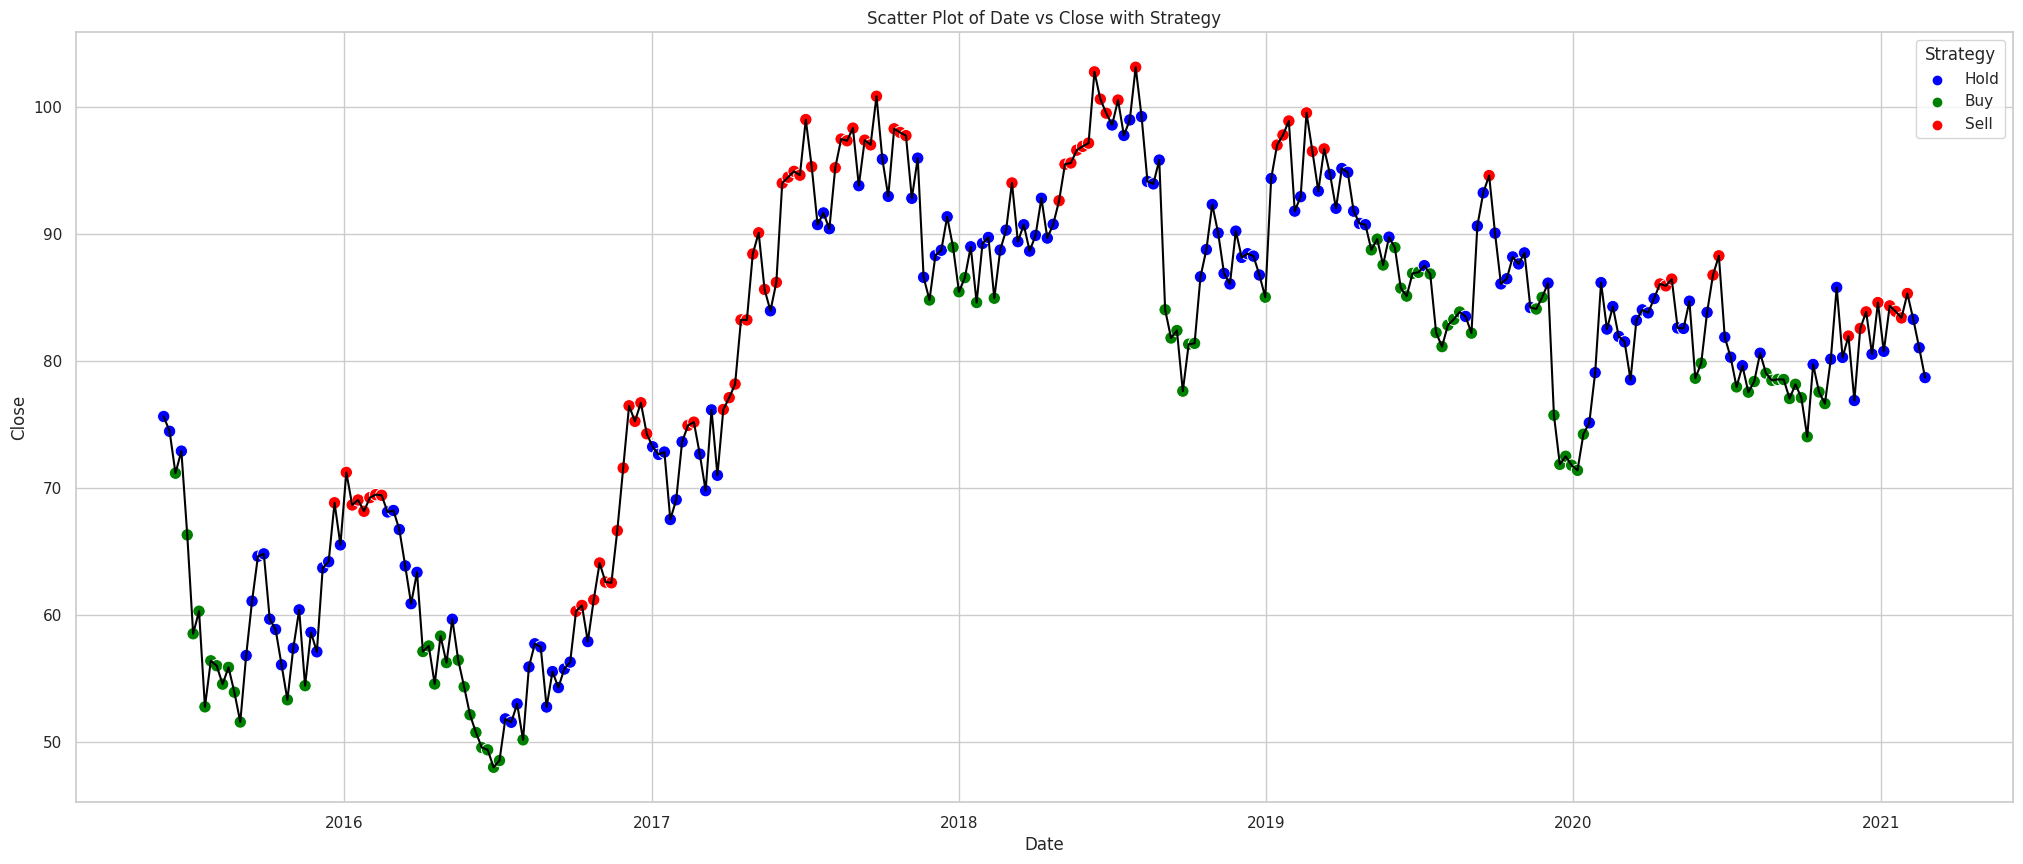

In [112]:
# df_plot = df_plot[df_plot.index > pd.to_datetime("2017-01-01", format='%Y-%m-%d')]
# df_plot = df_plot[df_plot.index < pd.to_datetime("2018-01-01", format='%Y-%m-%d')]
df_plot = df.copy()
plt.figure(figsize=(25, 10))
x_plot = 'Date'
y_plot = 'Close'
y_open = 'Open'

sns.set(style="whitegrid")

# Create the scatter plot with color-coded points
plt.figure(figsize=(25, 10))
sns.scatterplot(data = df_plot,x=x_plot, y=y_plot, hue='Strategy', palette=['blue', 'green', 'red'], s=80)
plt.plot(df_plot[y_plot], color = "black")

# sns.scatterplot(data = df_plot,x=x_plot, y=y_open, hue='Strategy', palette=['blue', 'green', 'red'], s=80)
# plt.plot(df_plot[y_open], color = "purple")
plt.title(f'Scatter Plot of {x_plot} vs {y_plot} with Strategy')
plt.show()

### Visualizing the Close column in the data

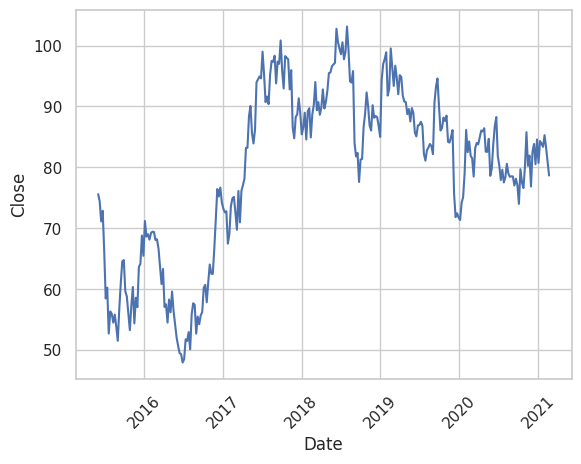

In [113]:
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df['Close'], )
plt.show()

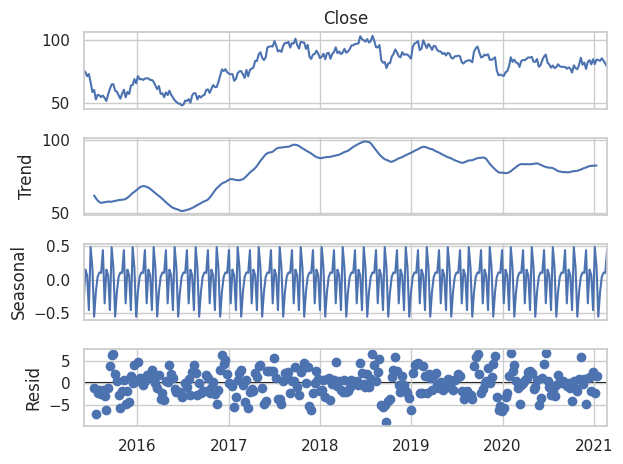

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='additive', period=12)
result.plot()
plt.show()

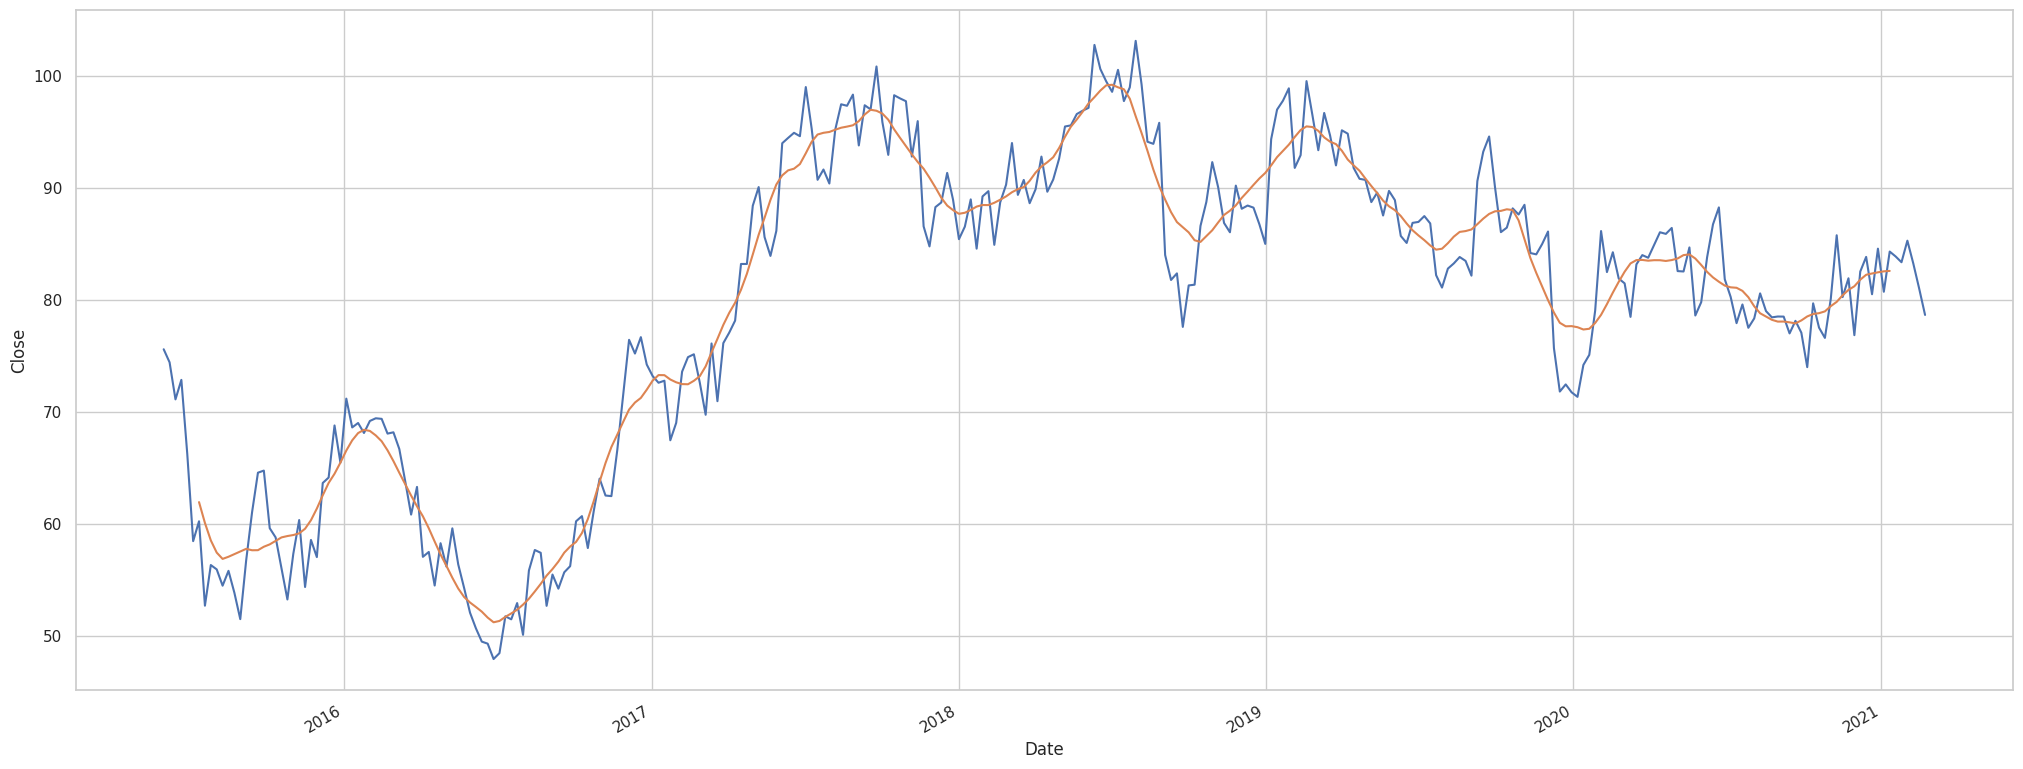

In [115]:
plt.figure(figsize=(25, 10))
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df['Close'], )
result.trend.plot()
plt.show()

### Feature Engineering

In [116]:
df_fe = df.copy()

df_fe['Lag1_Open'] = df_fe['Open'].shift(1)
df_fe['Lag2_Open'] = df_fe['Open'].shift(2)
df_fe['Lag3_Open'] = df_fe['Open'].shift(3)
df_fe['Lag4_Open'] = df_fe['Open'].shift(4)
df_fe['Lag5_Open'] = df_fe['Open'].shift(5)

df_fe['Lag1_Volume'] = df_fe['Volume'].shift(1)
df_fe['Lag2_Volume'] = df_fe['Volume'].shift(2)
df_fe['Lag3_Volume'] = df_fe['Volume'].shift(3)
df_fe['Lag4_Volume'] = df_fe['Volume'].shift(4)
df_fe['Lag5_Volume'] = df_fe['Volume'].shift(5)

df_fe['Open_Pct_Change'] = df_fe['Open'].pct_change()
df_fe['Volume_Pct_Change'] = df_fe['Volume'].pct_change()

result = seasonal_decompose(df_fe['Open'], model='additive', period=12)
df_fe['Trend_Open'] = result.trend
df_fe['Seasonal_Open'] = result.seasonal
df_fe['Residual_Open'] = result.resid

result = seasonal_decompose(df_fe['Volume'], model='additive', period=12)
df_fe['Trend_Volume'] = result.trend
df_fe['Seasonal_Volume'] = result.seasonal
df_fe['Residual_Volume'] = result.resid

df_fe['Residual_Open'] = df_fe['Open'] - df_fe['Trend_Open'] - df_fe['Seasonal_Open']
df_fe['Residual_Volume'] = df_fe['Volume'] - df_fe['Trend_Volume'] - df_fe['Seasonal_Volume']

df_fe['Ahead1_Open'] = df_fe['Open'].shift(-1)
df_fe['Ahead2_Open'] = df_fe['Open'].shift(-2)
df_fe['Ahead3_Open'] = df_fe['Open'].shift(-3)

# print(df_fe.head())

df_fe['MA_Open_3'] = df_fe['Open'].rolling(window=3).mean()

df_fe['MA_Open_5'] = df_fe['Open'].rolling(window=5).mean()
df_fe['MA_Volume_5'] = df_fe['Volume'].rolling(window=5).mean()

df_fe['MA_Open_10'] = df_fe['Open'].rolling(window=10).mean()
df_fe['MA_Volume_10'] = df_fe['Volume'].rolling(window=10).mean()


print(f"Shape Before: {df_fe.shape}")


df_fe['Ahead1_Open'] = df_fe['Ahead1_Open'].fillna(method='ffill')
df_fe['Ahead2_Open'] = df_fe['Ahead2_Open'].fillna(method='ffill')
df_fe['Ahead3_Open'] = df_fe['Ahead3_Open'].fillna(method='ffill')

df_fe['Lag1_Open'] = df_fe['Lag1_Open'].fillna(method = 'bfill')
df_fe['Lag2_Open'] = df_fe['Lag2_Open'].fillna(method = 'bfill')
df_fe['Lag3_Open'] = df_fe['Lag3_Open'].fillna(method = 'bfill')
df_fe['Lag4_Open'] = df_fe['Lag4_Open'].fillna(method = 'bfill')
df_fe['Lag5_Open'] = df_fe['Lag5_Open'].fillna(method = 'bfill')

df_fe['Lag1_Volume'] = df_fe['Lag1_Volume'].fillna(method = 'bfill')
df_fe['Lag2_Volume'] = df_fe['Lag2_Volume'].fillna(method = 'bfill')
df_fe['Lag3_Volume'] = df_fe['Lag3_Volume'].fillna(method = 'bfill')
df_fe['Lag4_Volume'] = df_fe['Lag4_Volume'].fillna(method = 'bfill')
df_fe['Lag5_Volume'] = df_fe['Lag5_Volume'].fillna(method = 'bfill')

df_fe['Open_Pct_Change'] = df_fe['Open_Pct_Change'].fillna(method = 'bfill')
df_fe['Volume_Pct_Change'] = df_fe['Volume_Pct_Change'].fillna(method = 'bfill')

df_fe['MA_Open_3'] = df_fe['MA_Open_3'].fillna(method = 'bfill')

df_fe['MA_Open_5'] = df_fe['MA_Open_5'].fillna(method = 'bfill')
df_fe['MA_Volume_5'] = df_fe['MA_Volume_5'].fillna(method = 'bfill')

df_fe['MA_Open_10'] = df_fe['MA_Open_10'].fillna(method = 'bfill')
df_fe['MA_Volume_10'] = df_fe['MA_Volume_10'].fillna(method = 'bfill')

df_fe['Trend_Open'] = df_fe['Trend_Open'].fillna(method='ffill')
df_fe['Trend_Open'] = df_fe['Trend_Open'].fillna(method='bfill')

df_fe['Trend_Volume'] = df_fe['Trend_Volume'].fillna(method='ffill')
df_fe['Trend_Volume'] = df_fe['Trend_Volume'].fillna(method='bfill')

df_fe['Residual_Volume'] = df_fe['Residual_Volume'].fillna(method='ffill')
df_fe['Residual_Volume'] = df_fe['Residual_Volume'].fillna(method='bfill')

# df_fe.dropna(inplace=True)
print(f"Shape After: {df_fe.shape}")

df_fe = df_fe.drop('Strategy', axis = 1)

df_fe.head()


#! BELOW CODE TO NOT DROP ALL NA VALUES BUT INSTEAD FILL IT WITH THE PREVIOUS OR THE AHEAD VALUES. Can be done to not lose data

# df_fe['COAhead1'] = df_fe['COAhead1'].fillna(method='ffill')
# df_fe['COAhead2'] = df_fe['COAhead2'].fillna(method='ffill')
# df_fe['COAhead3'] = df_fe['COAhead3'].fillna(method='ffill')

# df_fe['Ahead1_Open'] = df_fe['Ahead1_Open'].fillna(method='ffill')
# df_fe['Ahead2_Open'] = df_fe['Ahead2_Open'].fillna(method='ffill')
# df_fe['Ahead3_Open'] = df_fe['Ahead3_Open'].fillna(method='ffill')

# df_fe['Ahead1_Close'] = df_fe['Ahead1_Close'].fillna(method='ffill')
# df_fe['Ahead2_Close'] = df_fe['Ahead2_Close'].fillna(method='ffill')
# df_fe['Ahead3_Close'] = df_fe['Ahead3_Close'].fillna(method='ffill')

# df_fe['Lag1_Close'] = df_fe['Lag1_Close'].fillna(method = 'bfill')
# df_fe['Lag2_Close'] = df_fe['Lag2_Close'].fillna(method = 'bfill')
# df_fe['Lag3_Close'] = df_fe['Lag3_Close'].fillna(method = 'bfill')
# df_fe['Lag4_Close'] = df_fe['Lag4_Close'].fillna(method = 'bfill')
# df_fe['Lag5_Close'] = df_fe['Lag5_Close'].fillna(method = 'bfill')

# df_fe['Lag1_Open'] = df_fe['Lag1_Open'].fillna(method = 'bfill')
# df_fe['Lag2_Open'] = df_fe['Lag2_Open'].fillna(method = 'bfill')
# df_fe['Lag3_Open'] = df_fe['Lag3_Open'].fillna(method = 'bfill')
# df_fe['Lag4_Open'] = df_fe['Lag4_Open'].fillna(method = 'bfill')
# df_fe['Lag5_Open'] = df_fe['Lag5_Open'].fillna(method = 'bfill')

# df_fe['Lag1_Volume'] = df_fe['Lag1_Volume'].fillna(method = 'bfill')
# df_fe['Lag2_Volume'] = df_fe['Lag2_Volume'].fillna(method = 'bfill')
# df_fe['Lag3_Volume'] = df_fe['Lag3_Volume'].fillna(method = 'bfill')
# df_fe['Lag4_Volume'] = df_fe['Lag4_Volume'].fillna(method = 'bfill')
# df_fe['Lag5_Volume'] = df_fe['Lag5_Volume'].fillna(method = 'bfill')

# df_fe['COLag1'] = df_fe['COLag1'].fillna(method = 'bfill')
# df_fe['COLag2'] = df_fe['COLag2'].fillna(method = 'bfill')
# df_fe['COLag3'] = df_fe['COLag3'].fillna(method = 'bfill')

# df_fe['Trend_Open'] = df_fe['Trend_Open'].fillna(method='ffill')
# df_fe['Trend_Open'] = df_fe['Trend_Open'].fillna(method='bfill')

# df_fe['Trend_Close'] = df_fe['Trend_Close'].fillna(method='ffill')
# df_fe['Trend_Close'] = df_fe['Trend_Close'].fillna(method='bfill')

# df_fe['Trend_Volume'] = df_fe['Trend_Volume'].fillna(method='ffill')
# df_fe['Trend_Volume'] = df_fe['Trend_Volume'].fillna(method='bfill')

# for col in df_fe.columns:
#     if df_fe[col].isna().sum() > 0:
#         print(f"{col} : {df_fe[col].isna().sum()}")


# df_fe.head()

Shape Before: (300, 30)
Shape After: (300, 30)


Open      Close     Volume  Lag1_Open  Lag2_Open  Lag3_Open  \
Date                                                                           
2015-06-01  66.208486  75.609978  298506300  66.208486  66.208486  66.208486   
2015-06-08  64.116235  74.443331  227974800  66.208486  66.208486  66.208486   
2015-06-15  47.701942  71.140831  250670900  64.116235  66.208486  66.208486   
2015-06-22  54.754816  72.881344  223614300  47.701942  64.116235  66.208486   
2015-06-29  48.031899  66.284718  406814900  54.754816  47.701942  64.116235   

            Lag4_Open  Lag5_Open  Lag1_Volume  Lag2_Volume  ...  \
Date                                                        ...   
2015-06-01  66.208486  66.208486  298506300.0  298506300.0  ...   
2015-06-08  66.208486  66.208486  298506300.0  298506300.0  ...   
2015-06-15  66.208486  66.208486  227974800.0  298506300.0  ...   
2015-06-22  66.208486  66.208486  250670900.0  227974800.0  ...   
2015-06-29  66.208486  66.208486  223614300.0  250670900.0  ...   

            Seasonal_Volume  Residual_Volume  Ahead1_Open  Ahead2_Open  \
Date                                                                     
2015-06-01    -2.879892e+06     3.397119e+08    64.116235    47.701942   
2015-06-08    -9.864664e+05     3.397119e+08    47.701942    54.754816   
2015-06-15    -4.158181e+06     3.397119e+08    54.754816    48.031899   
2015-06-22    -8.123122e+05     3.397119e+08    48.031899    51.374399   
2015-06-29     8.809317e+06     3.397119e+08    51.374399    45.851376   

            Ahead3_Open  MA_Open_3  MA_Open_5  MA_Volume_5  MA_Open_10  \
Date                                                                     
2015-06-01    54.754816  59.342221  56.162676  281516240.0   51.974348   
2015-06-08    48.031899  59.342221  56.162676  281516240.0   51.974348   
2015-06-15    51.374399  59.342221  56.162676  281516240.0   51.974348   
2015-06-22    45.851376  55.524331  56.162676  281516240.0   51.974348   
2015-06-29    45.200332  50.162886  56.162676  281516240.0   51.974348   

            MA_Volume_10  
Date                      
2015-06-01   360090440.0  
2015-06-08   360090440.0  
2015-06-15   360090440.0  
2015-06-22   360090440.0  
2015-06-29   360090440.0  

[5 rows x 29 columns]

- We have engineered 29 features, we will now look at the correlation matrix to find the features which are correlated to the Close column.

<Axes: >

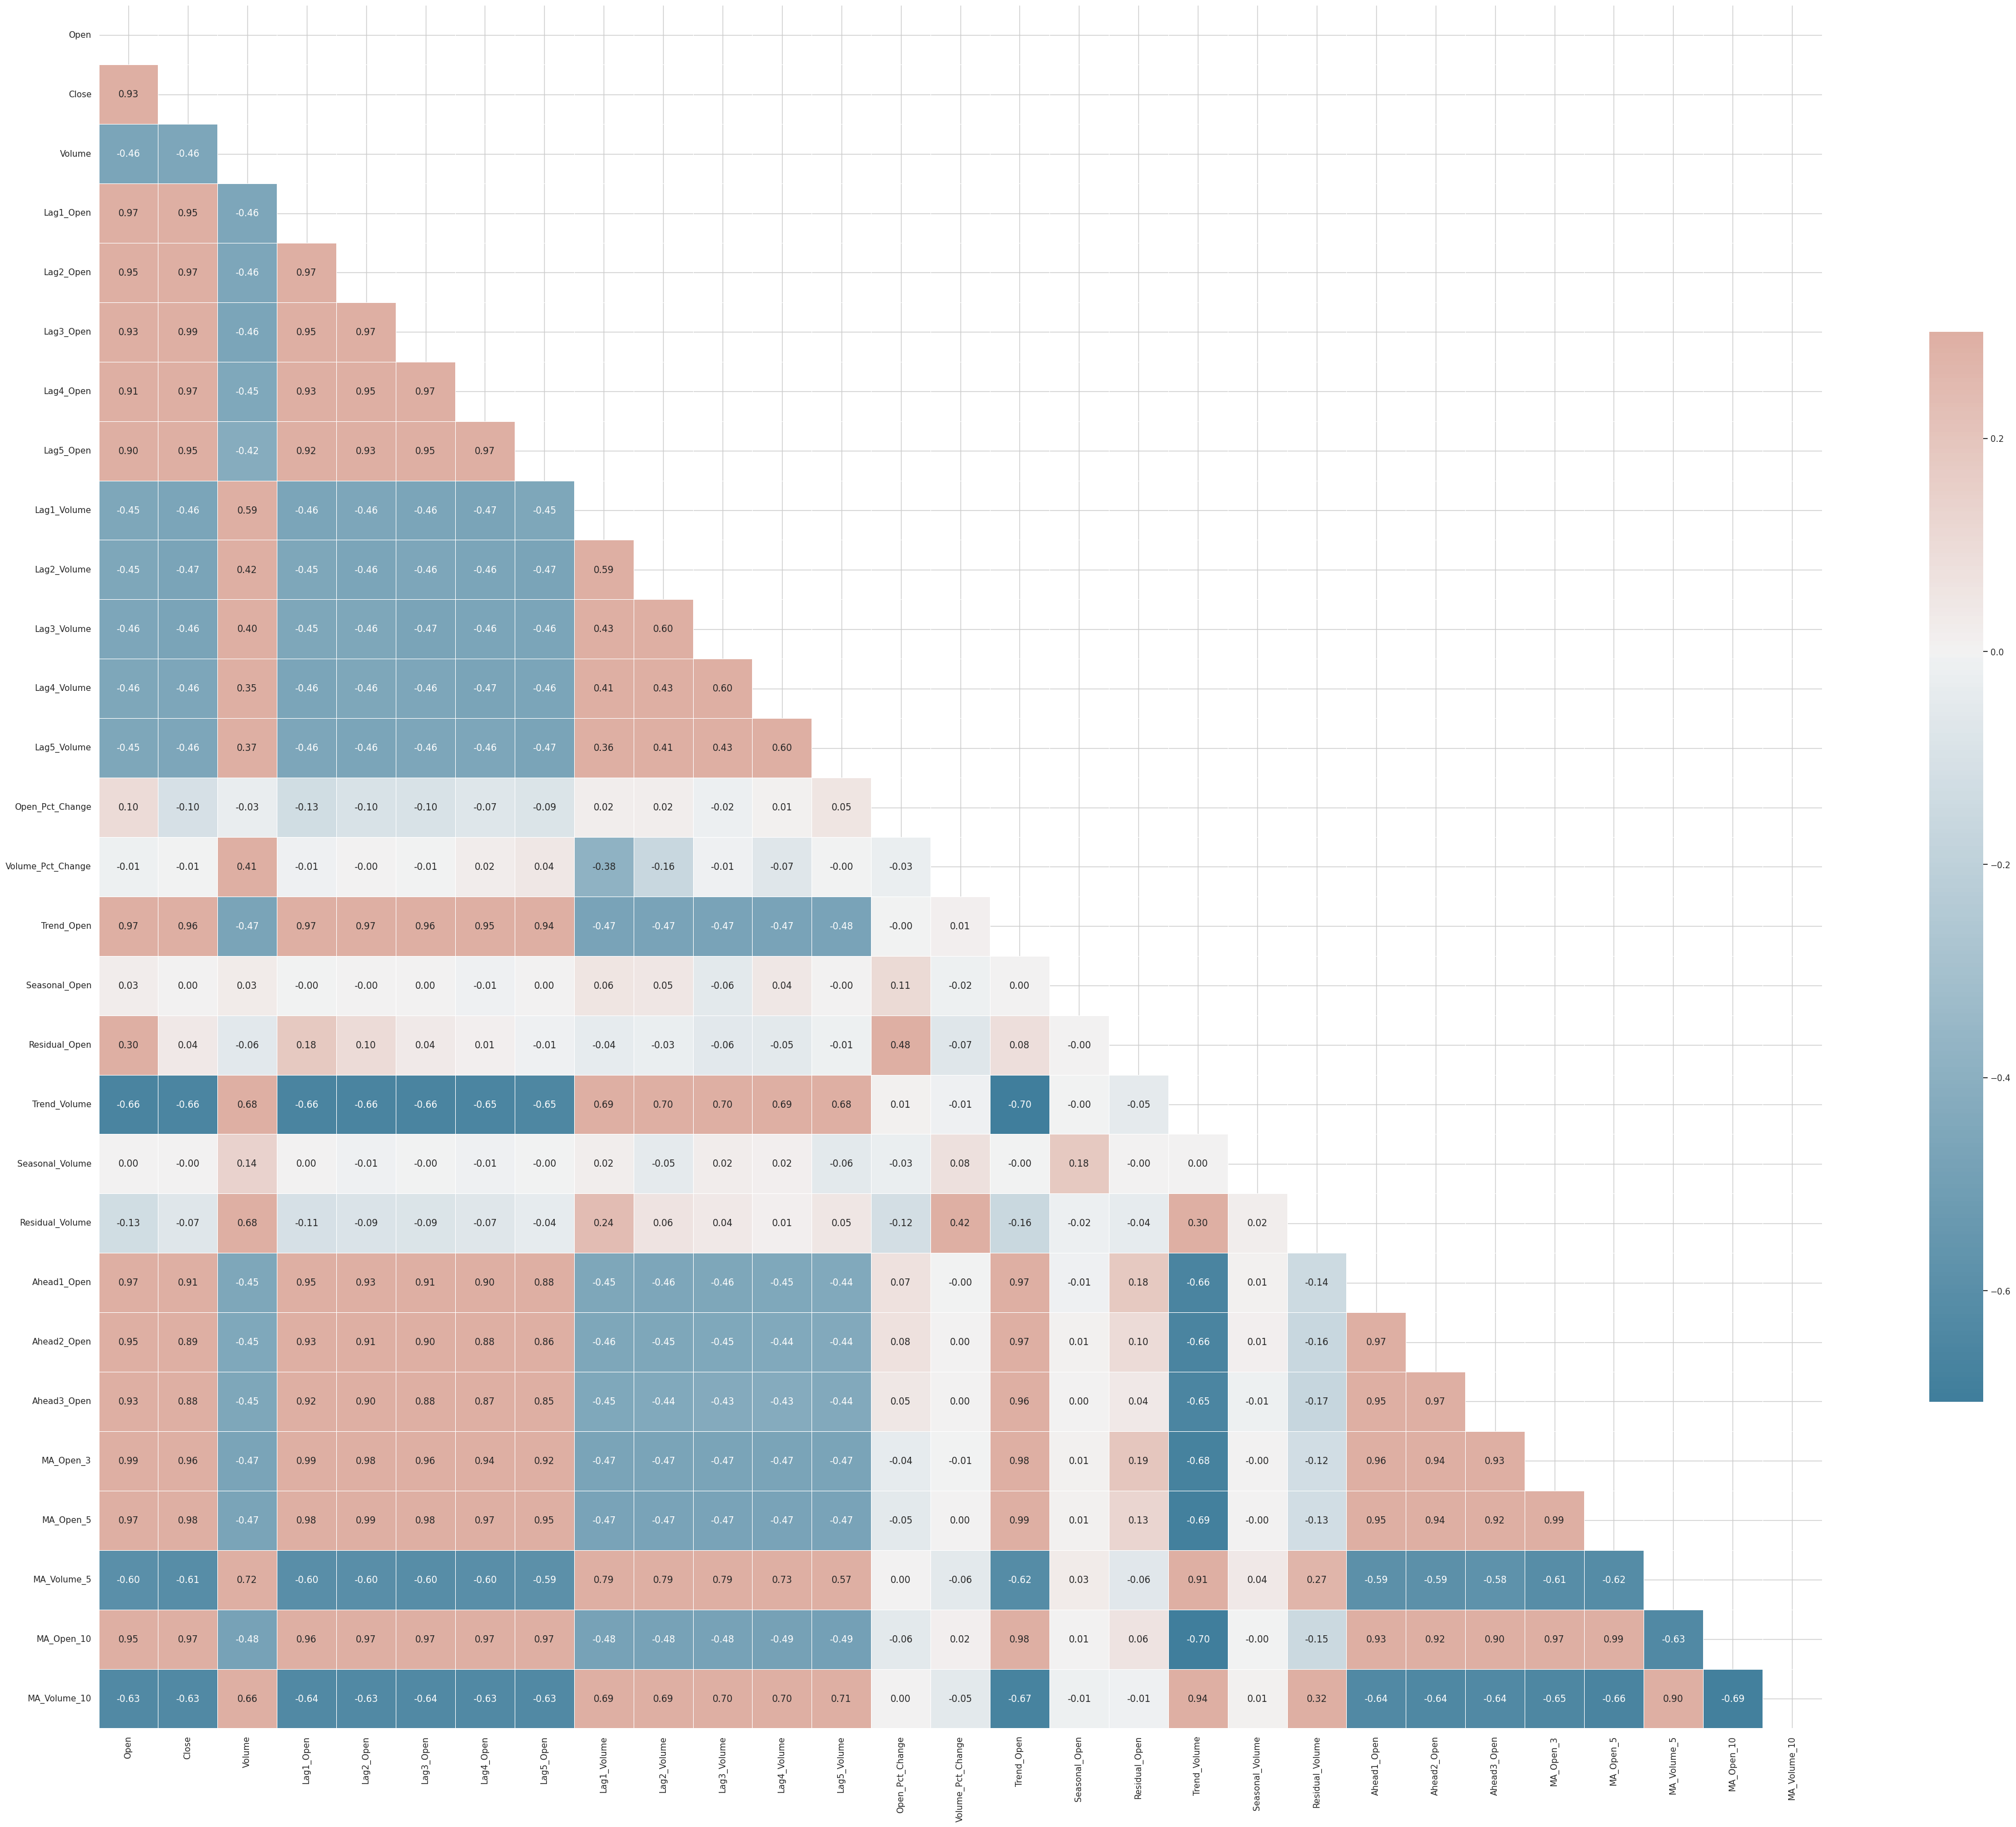

In [117]:
f, ax = plt.subplots(figsize=(50, 50))

mask = np.triu(np.ones_like(df_fe.corr(method='pearson'), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_fe.corr(method='pearson'), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, fmt=".2f")

In [12]:
df_corr = df_fe.corr(method='pearson')
df_corr.head()

Open     Close    Volume  Lag1_Open  Lag2_Open  Lag3_Open  \
Open       1.000000  0.927795 -0.461010   0.971378   0.949405   0.928449   
Close      0.927795  1.000000 -0.458788   0.949940   0.970465   0.990134   
Volume    -0.461010 -0.458788  1.000000  -0.457223  -0.458923  -0.463008   
Lag1_Open  0.971378  0.949940 -0.457223   1.000000   0.971398   0.949479   
Lag2_Open  0.949405  0.970465 -0.458923   0.971398   1.000000   0.971459   

           Lag4_Open  Lag5_Open  Lag1_Volume  Lag2_Volume  ...  \
Open        0.914179   0.898210    -0.453435    -0.451932  ...   
Close       0.973592   0.951677    -0.464329    -0.465074  ...   
Volume     -0.445869  -0.419789     0.587230     0.418696  ...   
Lag1_Open   0.928548   0.915126    -0.462361    -0.454971  ...   
Lag2_Open   0.949566   0.929518    -0.458483    -0.463883  ...   

           Seasonal_Volume  Residual_Volume  Ahead1_Open  Ahead2_Open  \
Open              0.002406        -0.129958     0.971358     0.949349   
Close            -0.001562        -0.072064     0.911458     0.893932   
Volume            0.141027         0.684827    -0.452103    -0.448576   
Lag1_Open         0.002249        -0.108600     0.949371     0.928317   
Lag2_Open        -0.007847        -0.090575     0.928358     0.913969   

           Ahead3_Open  MA_Open_3  MA_Open_5  MA_Volume_5  MA_Open_10  \
Open          0.930179   0.985041   0.972175    -0.598199    0.946760   
Close         0.881455   0.959662   0.978520    -0.605032    0.967264   
Volume       -0.450939  -0.466285  -0.469090     0.719336   -0.479990   
Lag1_Open     0.915760   0.992281   0.982625    -0.600124    0.957787   
Lag2_Open     0.898780   0.984887   0.985961    -0.599946    0.965614   

           MA_Volume_10  
Open          -0.634820  
Close         -0.634384  
Volume         0.660570  
Lag1_Open     -0.635189  
Lag2_Open     -0.634727  

[5 rows x 29 columns]

In [118]:
df_corr.columns

Index(['Open', 'Close', 'Volume', 'Lag1_Open', 'Lag2_Open', 'Lag3_Open',
       'Lag4_Open', 'Lag5_Open', 'Lag1_Volume', 'Lag2_Volume', 'Lag3_Volume',
       'Lag4_Volume', 'Lag5_Volume', 'Open_Pct_Change', 'Volume_Pct_Change',
       'Trend_Open', 'Seasonal_Open', 'Residual_Open', 'Trend_Volume',
       'Seasonal_Volume', 'Residual_Volume', 'Ahead1_Open', 'Ahead2_Open',
       'Ahead3_Open', 'MA_Open_3', 'MA_Open_5', 'MA_Volume_5', 'MA_Open_10',
       'MA_Volume_10'],
      dtype='object')

- We have correlations varying in different ranges between 0 and 1
- We will now perform feature extraction by creating a threshold, if the column has correlation above this threshold we will consider that feature.

In [119]:
features = set()
low_threshold = 0.65
high_threshold = 1
for col in df_corr.columns:
    if abs(df_corr[col]['Close']) <= high_threshold and abs(df_corr[col]['Close']) >= low_threshold:
        features.add(col)
print(f"{len(features)} / {len(df_corr.columns)} Features available over threshold\n")
print(features)

15 / 29 Features available over threshold

{'Ahead2_Open', 'Lag1_Open', 'Lag2_Open', 'Lag3_Open', 'Trend_Volume', 'Close', 'Ahead3_Open', 'MA_Open_3', 'Ahead1_Open', 'MA_Open_5', 'Open', 'MA_Open_10', 'Lag5_Open', 'Lag4_Open', 'Trend_Open'}


- Taking features whose correlation is between 0.65 and 1 gives us 15 features 
- We will be considering these values for our time series analysis

<Axes: >

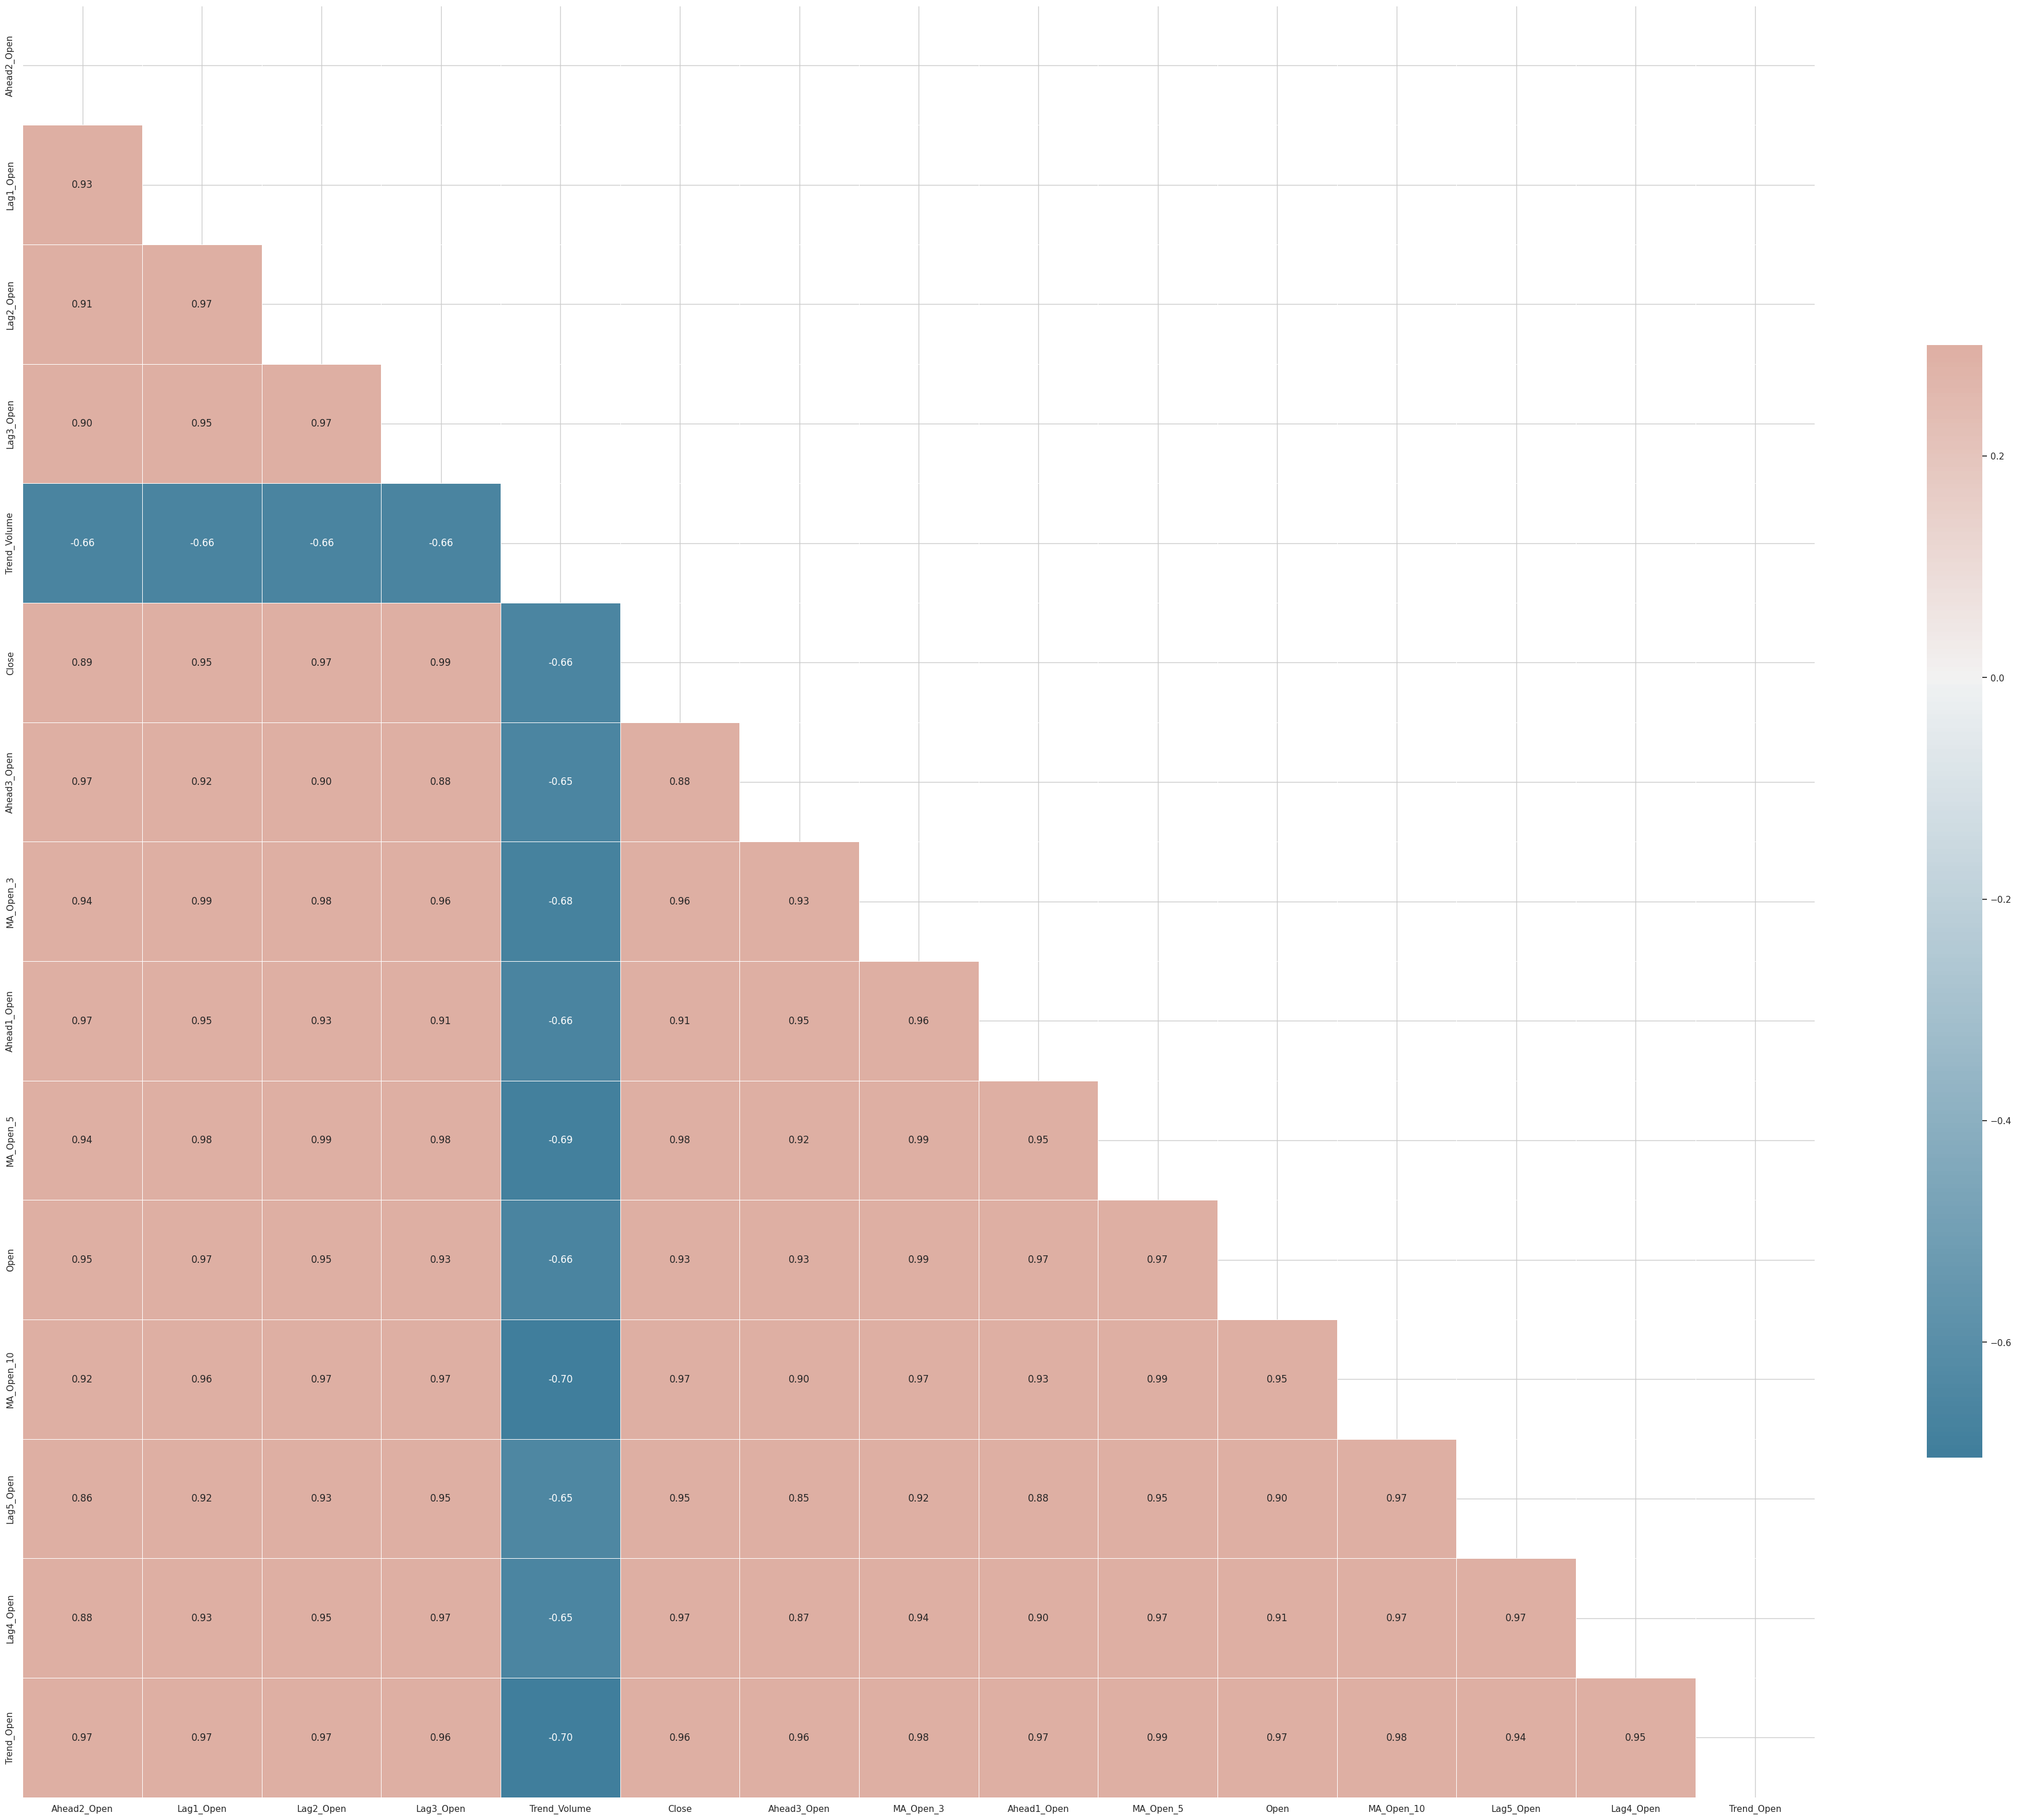

In [120]:
f, ax = plt.subplots(figsize=(50, 50))

mask = np.triu(np.ones_like(df_fe[list(features)].corr(method='pearson'), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_fe[list(features)].corr(method='pearson'), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, fmt=".2f")

In [16]:
#! Below Code to keep only 1 of the features which are above a certain threshold

# df_net_corr = df_fe[list(features)].corr(method='pearson')
# df_net_corr.head()

# net_features = set()
# between_threshold = 0.7
# for i in range(len(features)):
#     for j in range(i+1,len(features)):
#         if abs(df_net_corr[list(features)[i]][list(features)[j]]) <= between_threshold:
#             net_features.add(list(features)[i])
# print(net_features)
# print(features)
# len(features),len(net_features)
# features = net_features

In [124]:
df_fe = df_fe[list(features)]
print(df_fe.shape)
print(f"NA Values: {df.isna().sum().sum()}")
df_fe.head()

(300, 15)
NA Values: 0


Ahead2_Open  Lag1_Open  Lag2_Open  Lag3_Open  Trend_Volume  \
Date                                                                     
2015-06-01    47.701942  66.208486  66.208486  66.208486  3.429520e+08   
2015-06-08    54.754816  66.208486  66.208486  66.208486  3.429520e+08   
2015-06-15    48.031899  64.116235  66.208486  66.208486  3.429520e+08   
2015-06-22    51.374399  47.701942  64.116235  66.208486  3.429520e+08   
2015-06-29    45.851376  54.754816  47.701942  64.116235  3.429520e+08   

                Close  Ahead3_Open  MA_Open_3  Ahead1_Open  MA_Open_5  \
Date                                                                    
2015-06-01  75.609978    54.754816  59.342221    64.116235  56.162676   
2015-06-08  74.443331    48.031899  59.342221    47.701942  56.162676   
2015-06-15  71.140831    51.374399  59.342221    54.754816  56.162676   
2015-06-22  72.881344    45.851376  55.524331    48.031899  56.162676   
2015-06-29  66.284718    45.200332  50.162886    51.374399  56.162676   

                 Open  MA_Open_10  Lag5_Open  Lag4_Open  Trend_Open  
Date                                                                 
2015-06-01  66.208486   51.974348  66.208486  66.208486   50.927258  
2015-06-08  64.116235   51.974348  66.208486  66.208486   50.927258  
2015-06-15  47.701942   51.974348  66.208486  66.208486   50.927258  
2015-06-22  54.754816   51.974348  66.208486  66.208486   50.927258  
2015-06-29  48.031899   51.974348  66.208486  66.208486   50.927258

In [125]:
exog = df_fe[[x for x in df_fe if x != 'Close']]
exog.head()

Ahead2_Open  Lag1_Open  Lag2_Open  Lag3_Open  Trend_Volume  \
Date                                                                     
2015-06-01    47.701942  66.208486  66.208486  66.208486  3.429520e+08   
2015-06-08    54.754816  66.208486  66.208486  66.208486  3.429520e+08   
2015-06-15    48.031899  64.116235  66.208486  66.208486  3.429520e+08   
2015-06-22    51.374399  47.701942  64.116235  66.208486  3.429520e+08   
2015-06-29    45.851376  54.754816  47.701942  64.116235  3.429520e+08   

            Ahead3_Open  MA_Open_3  Ahead1_Open  MA_Open_5       Open  \
Date                                                                    
2015-06-01    54.754816  59.342221    64.116235  56.162676  66.208486   
2015-06-08    48.031899  59.342221    47.701942  56.162676  64.116235   
2015-06-15    51.374399  59.342221    54.754816  56.162676  47.701942   
2015-06-22    45.851376  55.524331    48.031899  56.162676  54.754816   
2015-06-29    45.200332  50.162886    51.374399  56.162676  48.031899   

            MA_Open_10  Lag5_Open  Lag4_Open  Trend_Open  
Date                                                      
2015-06-01   51.974348  66.208486  66.208486   50.927258  
2015-06-08   51.974348  66.208486  66.208486   50.927258  
2015-06-15   51.974348  66.208486  66.208486   50.927258  
2015-06-22   51.974348  66.208486  66.208486   50.927258  
2015-06-29   51.974348  66.208486  66.208486   50.927258

## Prediction of the Close Column

In [126]:
df_fe['Close'] = df['Close']

### Train Test Split
- We will have all data before 15 December 2019 as training
- All data after 15 December 2019 as testing
- 15 December 2019 gives us a proper 80 20 split, so we went with this value

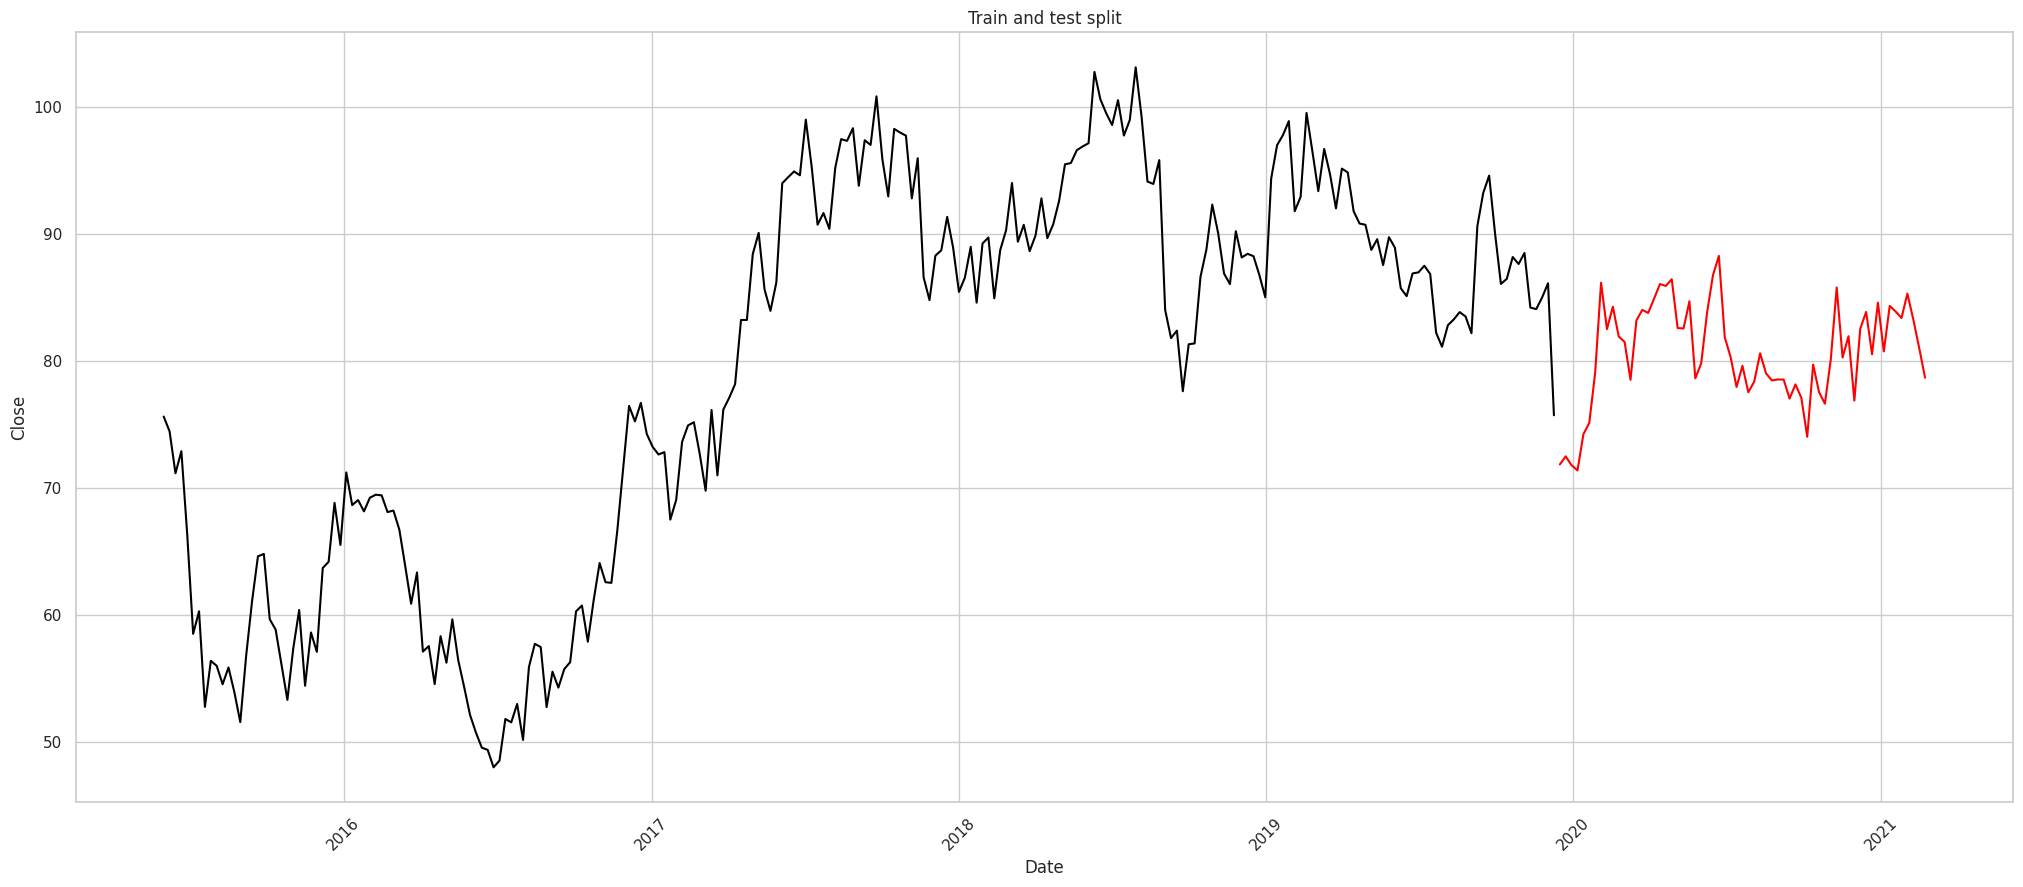

Number of training instances: 237
Number of testing instances: 63


In [127]:
split_date = "2019-12-15"
train = df_fe[df_fe.index < pd.to_datetime(split_date, format='%Y-%m-%d')]
test = df_fe[df_fe.index > pd.to_datetime(split_date, format='%Y-%m-%d')]

plt.figure(figsize=(25,10))
plt.plot(train['Close'], color = "black")
plt.plot(test['Close'], color = "red")

plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train and test split")

plt.show()
print(f"Number of training instances: {len(train)}")
print(f"Number of testing instances: {len(test)}")

In [128]:
train.head()

Ahead2_Open  Lag1_Open  Lag2_Open  Lag3_Open  Trend_Volume  \
Date                                                                     
2015-06-01    47.701942  66.208486  66.208486  66.208486  3.429520e+08   
2015-06-08    54.754816  66.208486  66.208486  66.208486  3.429520e+08   
2015-06-15    48.031899  64.116235  66.208486  66.208486  3.429520e+08   
2015-06-22    51.374399  47.701942  64.116235  66.208486  3.429520e+08   
2015-06-29    45.851376  54.754816  47.701942  64.116235  3.429520e+08   

                Close  Ahead3_Open  MA_Open_3  Ahead1_Open  MA_Open_5  \
Date                                                                    
2015-06-01  75.609978    54.754816  59.342221    64.116235  56.162676   
2015-06-08  74.443331    48.031899  59.342221    47.701942  56.162676   
2015-06-15  71.140831    51.374399  59.342221    54.754816  56.162676   
2015-06-22  72.881344    45.851376  55.524331    48.031899  56.162676   
2015-06-29  66.284718    45.200332  50.162886    51.374399  56.162676   

                 Open  MA_Open_10  Lag5_Open  Lag4_Open  Trend_Open  
Date                                                                 
2015-06-01  66.208486   51.974348  66.208486  66.208486   50.927258  
2015-06-08  64.116235   51.974348  66.208486  66.208486   50.927258  
2015-06-15  47.701942   51.974348  66.208486  66.208486   50.927258  
2015-06-22  54.754816   51.974348  66.208486  66.208486   50.927258  
2015-06-29  48.031899   51.974348  66.208486  66.208486   50.927258

### Normalizing data

In [129]:
from sklearn.preprocessing import StandardScaler

X_train = train[[x for x in df_fe if x != 'Close']]
y_train = train[['Close']]
X_test = test[[x for x in df_fe if x != 'Close']]
y_test = test[['Close']]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train[:5]

array([[-1.55335137, -0.52148408, -0.52032467, -0.51955564,  2.57548278,
        -1.17248876, -0.90758836, -0.63936851, -1.08413803, -0.5230571 ,
        -1.30051844, -0.51436768, -0.51802998, -1.41099552],
       [-1.16115289, -0.52148408, -0.52032467, -0.51955564,  2.57548278,
        -1.54821155, -0.90758836, -1.55170037, -1.08413803, -0.63934664,
        -1.30051844, -0.51436768, -0.51802998, -1.41099552],
       [-1.53500298, -0.63771746, -0.52032467, -0.51955564,  2.57548278,
        -1.36140972, -0.90758836, -1.15969068, -1.08413803, -1.5516707 ,
        -1.30051844, -0.51436768, -0.51802998, -1.41099552],
       [-1.34913222, -1.5496009 , -0.63651275, -0.51955564,  2.57548278,
        -1.6700742 , -1.12147664, -1.5333608 , -1.08413803, -1.15966436,
        -1.30051844, -0.51436768, -0.51802998, -1.41099552],
       [-1.65625824, -1.15778388, -1.54804082, -0.63571137,  2.57548278,
        -1.70645902, -1.42183897, -1.34757951, -1.08413803, -1.53333129,
        -1.30051844, -0.51

## Finding appropriate models
- Holt-Winters' Method
- ARIMA
- ARIMAX
- SARIMA
- SARIMAX
- XGBoost

## Holt-Winters' Method
- Additive Model: 0.02786538908226409
- Multiplicative: 0.023865055948968074



In [130]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(endog = y_train, seasonal = 'multiplicative')
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    Close   No. Observations:                  237
Model:             ExponentialSmoothing   SSE                           2068.177
Optimized:                         True   AIC                            621.428
Trend:                             None   BIC                            808.703
Seasonal:                Multiplicative   AICC                           656.895
Seasonal Periods:                    52   Date:                 Wed, 01 Nov 2023
Box-Cox:                          False   Time:                         18:10:15
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8929954                alpha                 True
smoothing_seasonal            3.472e-11                gamma                 True
initial_level                 60.476212                  l.0                 True
initial_seasons.0             1.2456150                  s.0                 True
initial_seasons.1             1.2632435                  s.1                 True
initial_seasons.2             1.2637615                  s.2                 True
initial_seasons.3             1.2601234                  s.3                 True
initial_seasons.4             1.2405670                  s.4                 True
initial_seasons.5             1.2348999                  s.5                 True
initial_seasons.6             1.2406984                  s.6                 True
initial_seasons.7             1.1948433                  s.7                 True
initial_seasons.8             1.1980862                  s.8                 True
initial_seasons.9             1.2000091                  s.9                 True
initial_seasons.10            1.2150510                 s.10                 True
initial_seasons.11            1.2124778                 s.11                 True
initial_seasons.12            1.2089332                 s.12                 True
initial_seasons.13            1.2035848                 s.13                 True
initial_seasons.14            1.1551736                 s.14                 True
initial_seasons.15            1.1963503                 s.15                 True
initial_seasons.16            1.2179410                 s.16                 True
initial_seasons.17            1.2240670                 s.17                 True
initial_seasons.18            1.1963587                 s.18                 True
initial_seasons.19            1.1716912                 s.19                 True
initial_seasons.20            1.1964406                 s.20                 True
initial_seasons.21            1.2101930                 s.21                 True
initial_seasons.22            1.2347735                 s.22                 True
initial_seasons.23            1.2152934                 s.23                 True
initial_seasons.24            1.1882125                 s.24                 True
initial_seasons.25            1.1695550                 s.25                 True
initial_seasons.26            1.1905937                 s.26                 True
initial_seasons.27            1.2270387                 s.27                 True
initial_seasons.28            1.1940770                 s.28                 True
initial_seasons.29            1.2275149                 s.29                 True
initial_seasons.30            1.1929422                 s.30                 True
initial_seasons.31            1.1857180                 s.31                 True
initial_seasons.32        

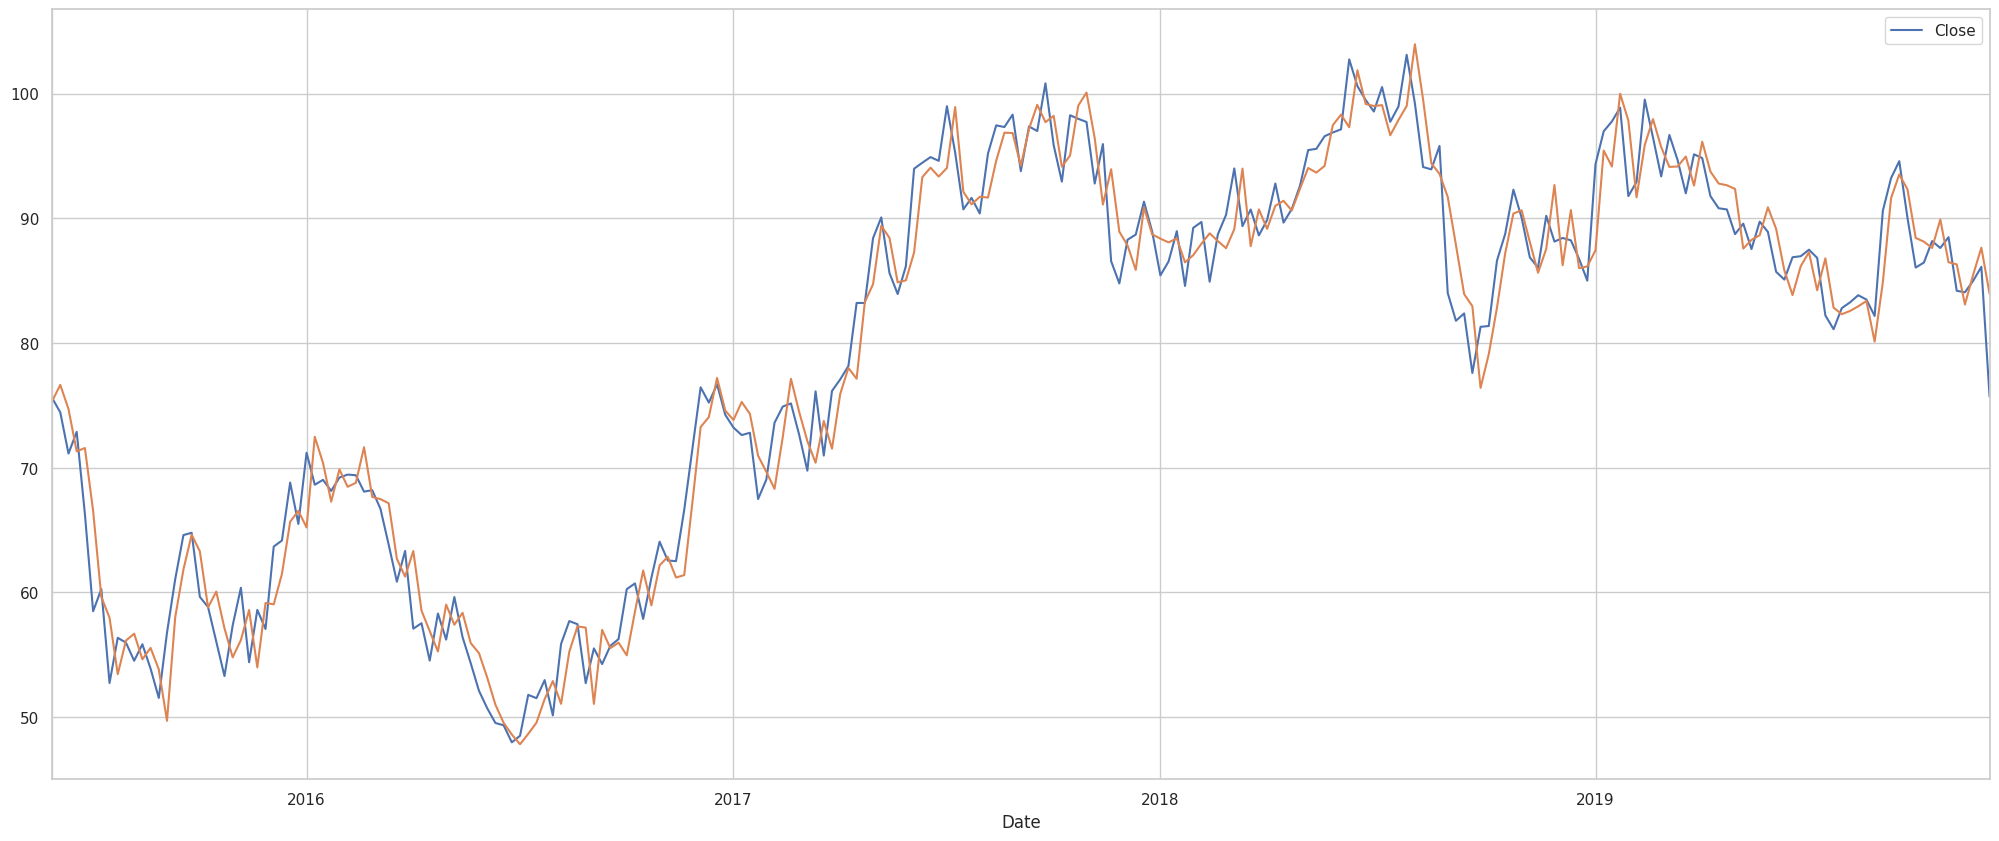

In [131]:
y_train.plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [132]:
predict = model_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1)
test['predicted'] = predict.values

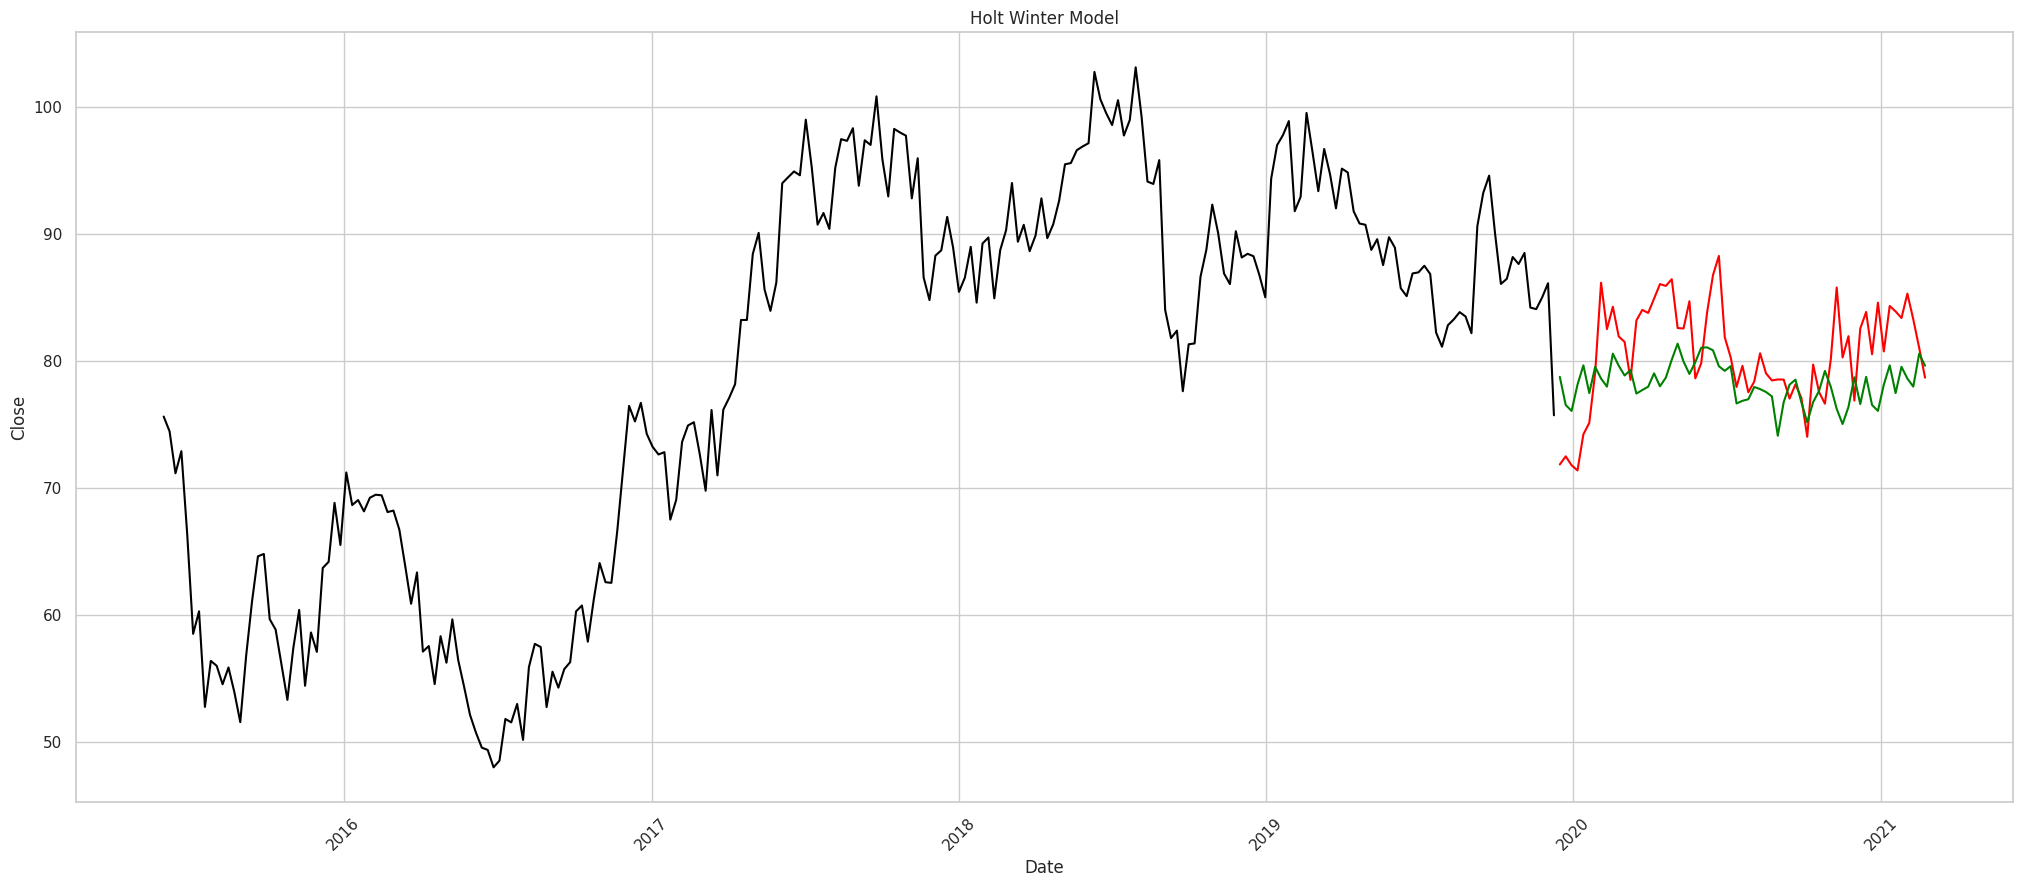

MAE: 3.7174640874429805
RMSE: 4.481838507144341
SMAPE:  0.023251744240210138


In [133]:
plt.figure(figsize=(25,10))

plt.plot(y_train, color = "black")
plt.plot(y_test, color = "red")
plt.plot(test['predicted'] , color='green', label = 'Holt Winter Prediction')

plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Holt Winter Model")

plt.show()

MAE = mean_absolute_error(y_test, test["predicted"])
RMSE = math.sqrt(mean_squared_error(y_test, test["predicted"]))
print("MAE:", MAE)
print("RMSE:", RMSE)
print("SMAPE: ",np.mean(np.abs(test["predicted"] - y_test['Close']) / (np.abs(test["predicted"]) + np.abs(y_test['Close']))))

## ARIMA Model
- SMAPE: 0.017998486616618146


In [27]:
ARIMARUN = False
# ARIMARUN = True
if ARIMARUN :
    import itertools
    p = q = range (0,7)
    d = [0,1]
    pdq = list(itertools.product (p, d, q))

    store = {}

    for i, param in enumerate(pdq):
        predictedValues = []
        try:
            model_arima = sm.tsa.arima.ARIMA (y_train, order = param)
            model_arima_fit = model_arima.fit()

            predict = model_arima_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1)
            predictedValues = predict.values

            smape =  np.mean(np.abs(predictedValues - y_test['Close']) / (np.abs(predictedValues) + np.abs(y_test['Close'])))
            store[param] = smape
            print(f"{i+1}/{len(pdq)}: {param} : SMAPE: {smape} : Lowest : {min(list(store.items()), key = lambda x: x[1])}")
        except:
            continue

    sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
    print(sorted_dict)

In [28]:
model_arima = sm.tsa.arima.ARIMA (y_train, order = (0,0,6))
model_arima_fit = model_arima.fit()

predict = model_arima_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1)
test['predicted'] = predict.values
smape =  np.mean(np.abs(test['predicted'] - y_test['Close']) / (np.abs(test['predicted']) + np.abs(y_test['Close'])))
smape

0.018496434646523938

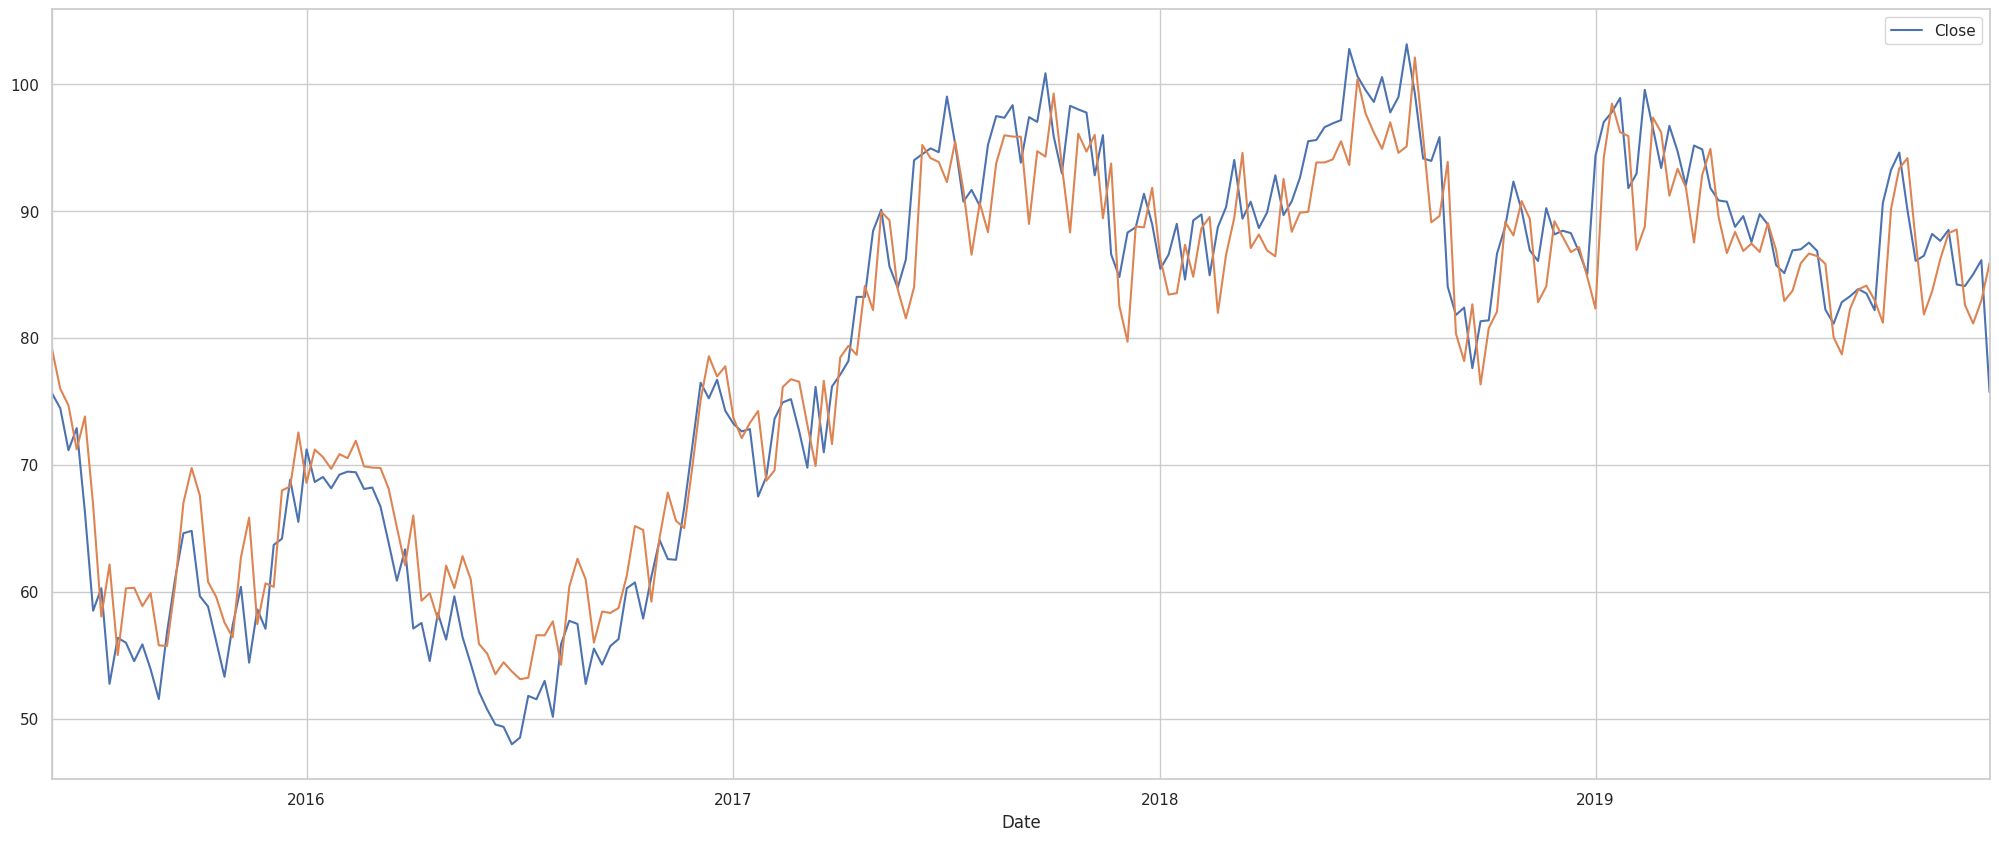

In [29]:
y_train.plot(figsize=(25,10))
model_arima_fit.fittedvalues.plot()
plt.show()

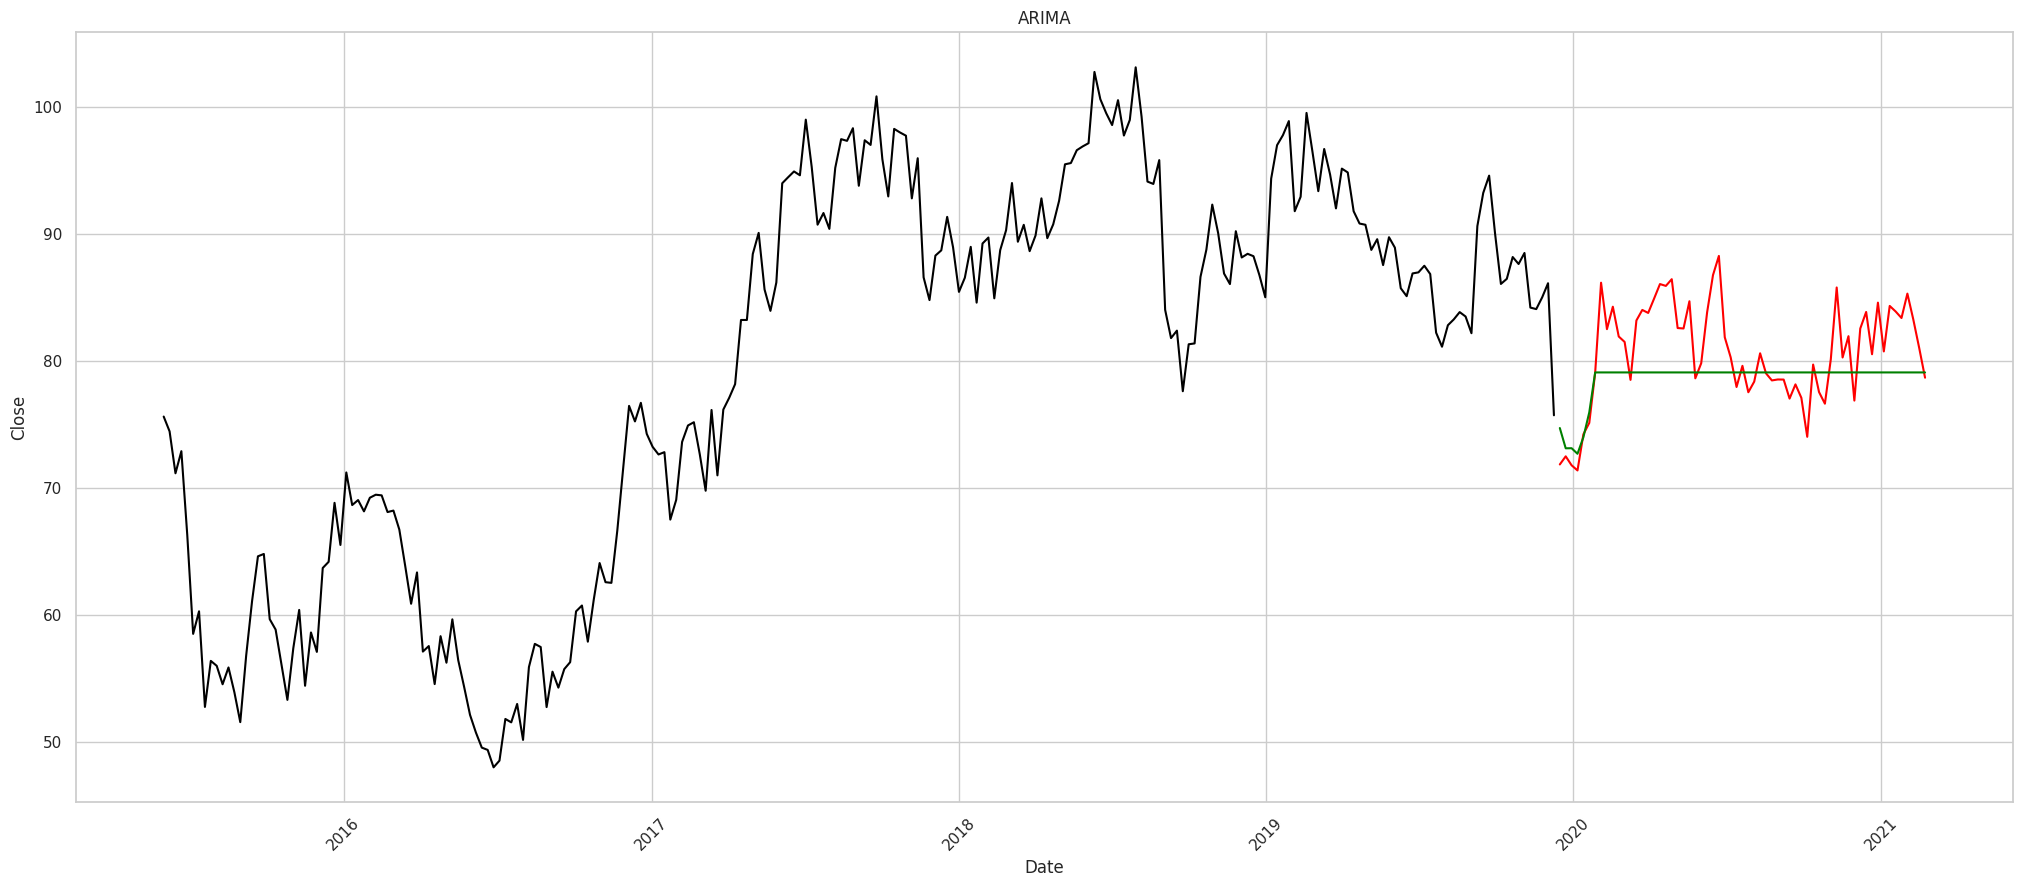

MAE: 2.991442198763197
RMSE: 3.783811226737672
SMAPE:  0.018496434646523938


In [30]:
plt.figure(figsize=(25,10))
plt.plot(y_train, color = "black")
plt.plot(y_test, color = "red")
plt.plot(test['predicted'] , color='green', label = 'ARIMA Prediction')
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("ARIMA")
plt.show()
MAE = mean_absolute_error(y_test, test["predicted"])
RMSE = math.sqrt(mean_squared_error(y_test, test["predicted"]))
print("MAE:", MAE)
print("RMSE:", RMSE)
print("SMAPE: ",np.mean(np.abs(test["predicted"] - y_test['Close']) / (np.abs(test["predicted"]) + np.abs(y_test['Close']))))

## ARIMAX Model
- SMAPE: 0.009535488853437654

In [134]:
print(X_train.shape)
print(X_test.shape)

(237, 14)
(63, 14)


In [32]:
ARIMAXRUN = False
# ARIMAXRUN = True
if ARIMAXRUN:
    import itertools
    p = q = range (0,7)
    d = [0,1]
    pdq = list(itertools.product (p, d, q))

    store = {}

    for i,param in enumerate(pdq):
        predictedValues = []
        try:
            model_arimax = sm.tsa.arima.ARIMA (y_train, order = param, exog = X_train)
            model_arimax_fit = model_arimax.fit()

            predict = model_arimax_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1,exog = X_test)
            predictedValues = predict.values

            smape =  np.mean(np.abs(predictedValues - y_test['Close']) / (np.abs(predictedValues) + np.abs(y_test['Close'])))
            store[param] = smape
            print(f"{i+1}/{len(pdq)}: {param} : SMAPE: {smape} : Lowest : {min(list(store.items()), key = lambda x: x[1])}")
        except:
            continue

    sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
    print(sorted_dict)

In [135]:
model_arimax = sm.tsa.arima.ARIMA (y_train, order = (2,0,4), exog = X_train)
model_arimax_fit = model_arimax.fit()

predict = model_arimax_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1,exog = X_test)
test['predicted_ARIMAX'] = predict.values

smape =  np.mean(np.abs(test['predicted_ARIMAX'] - y_test['Close']) / (np.abs(test['predicted_ARIMAX']) + np.abs(y_test['Close'])))
smape

0.009371078649071931

In [136]:
X_test.shape

(63, 14)

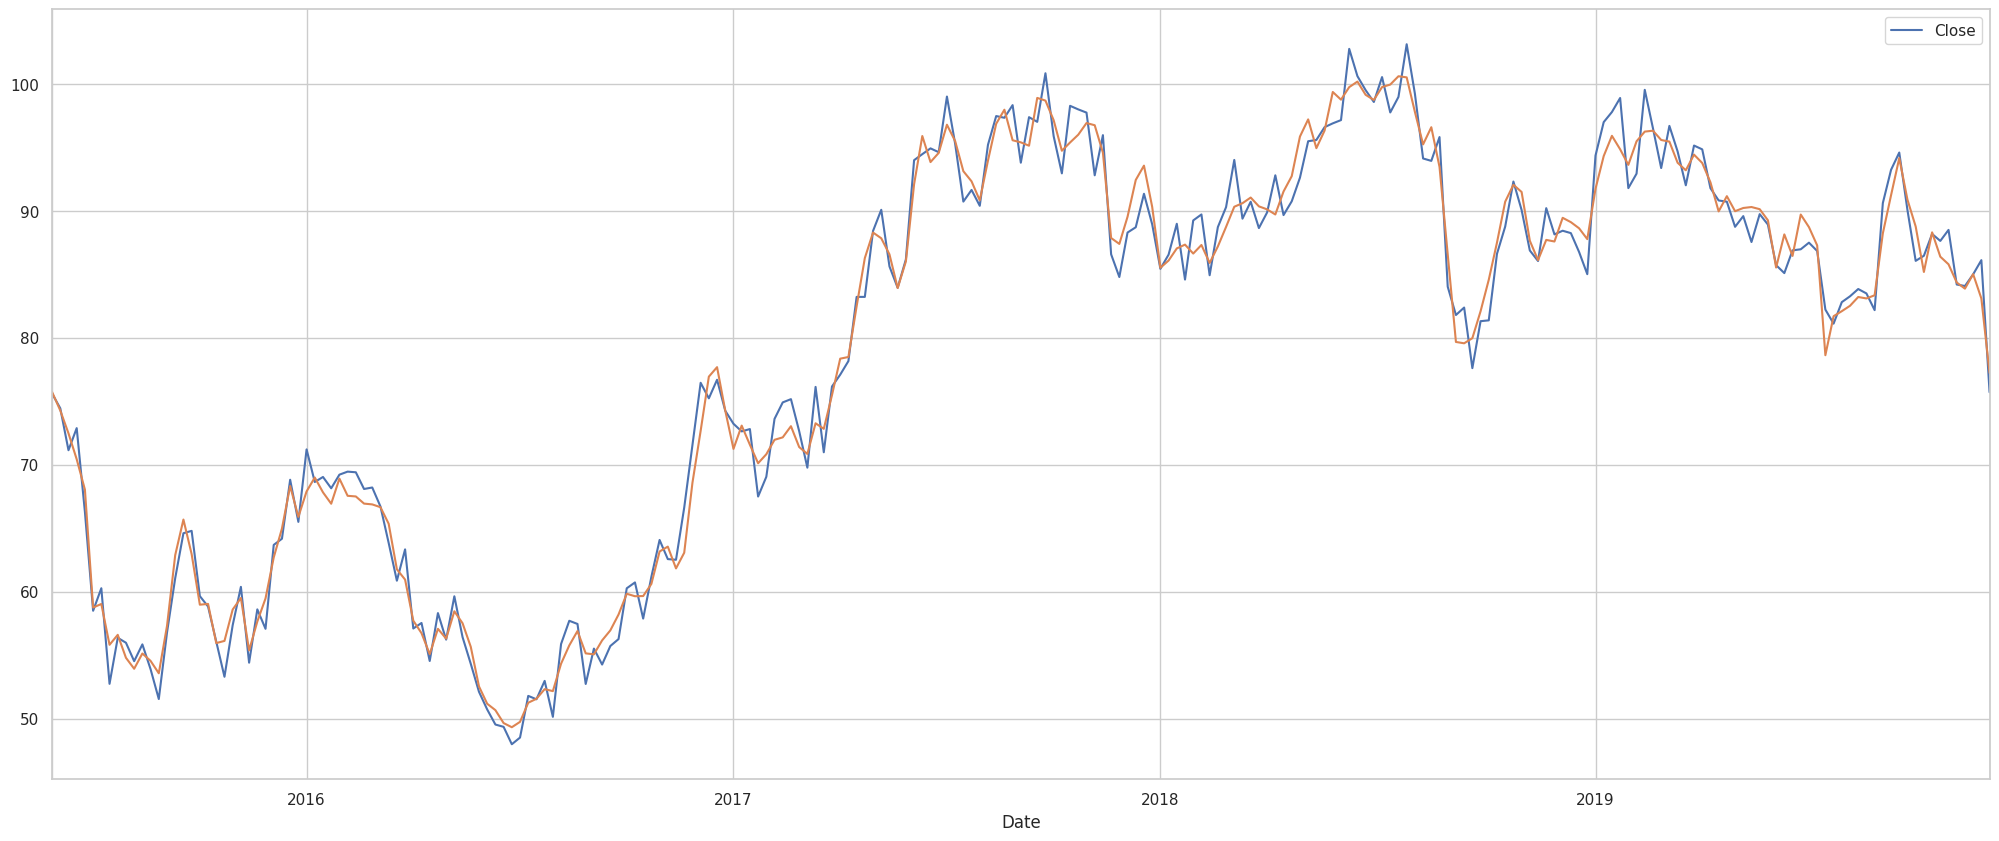

In [137]:
y_train.plot(figsize=(25,10))
model_arimax_fit.fittedvalues.plot()
plt.show()

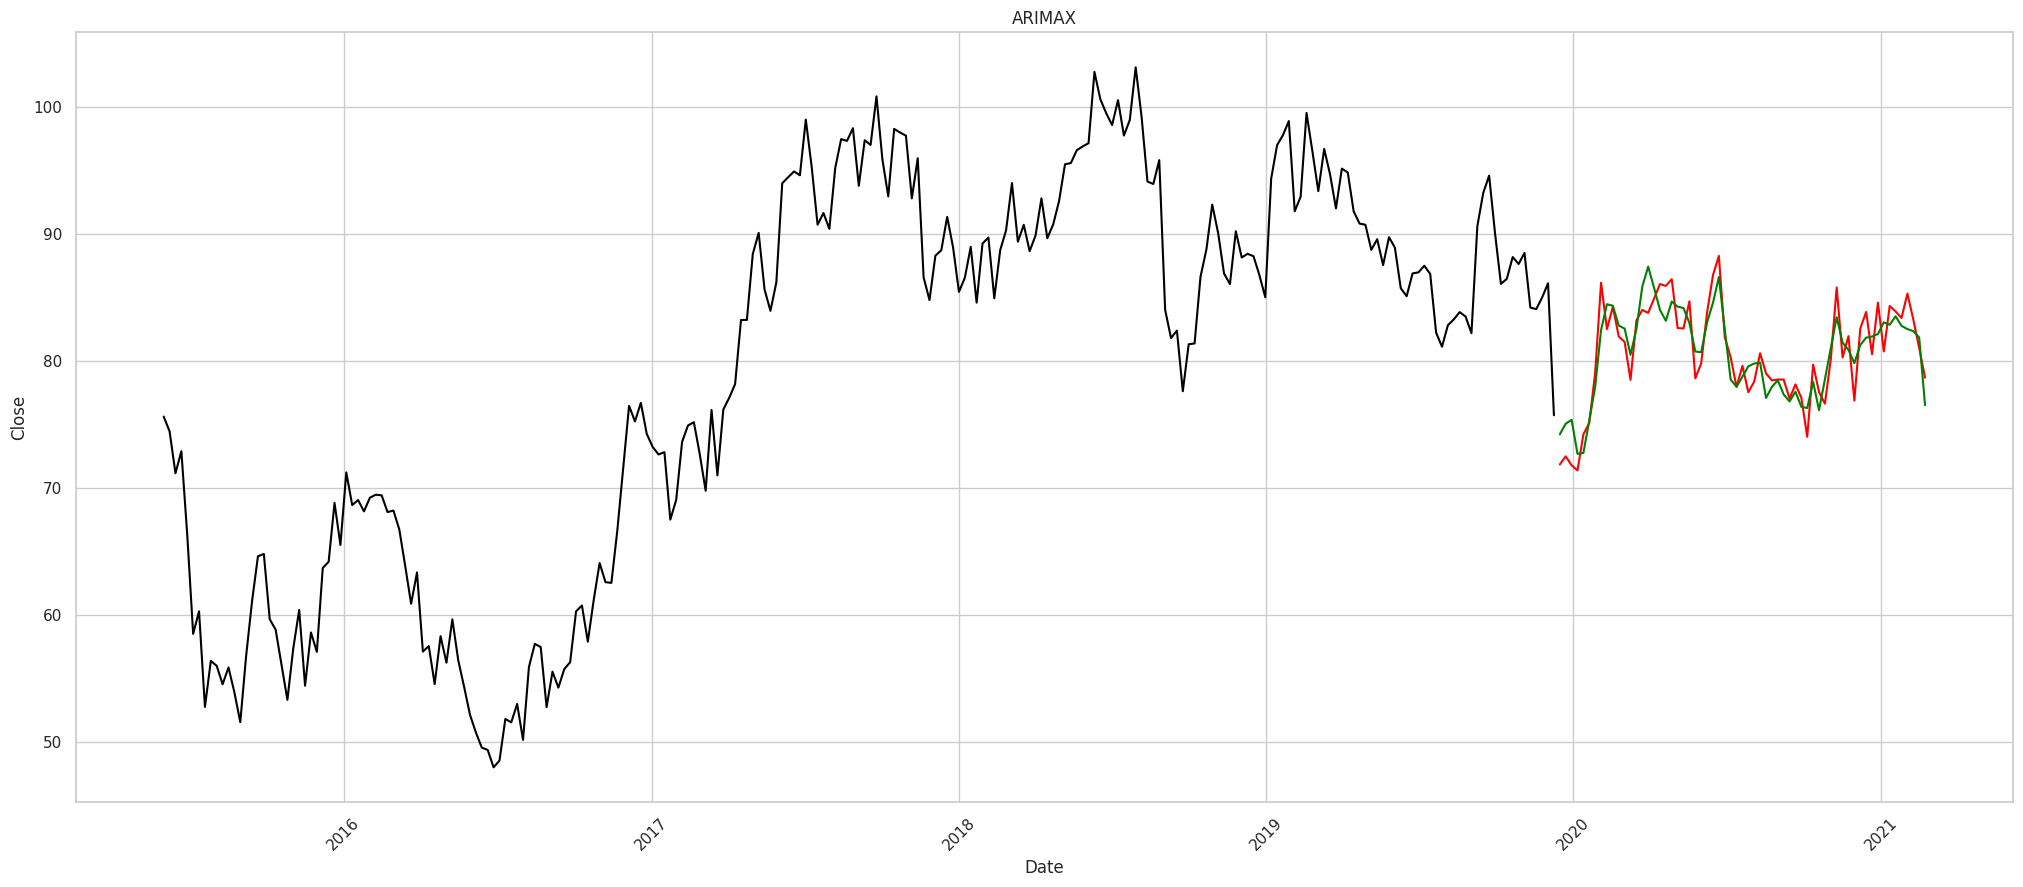

MAE: 1.510019786744599
RMSE: 1.7428362290417558
SMAPE:  0.009371078649071931


In [138]:
plt.figure(figsize=(25,10))
plt.plot(y_train, color = "black")
plt.plot(y_test, color = "red")
plt.plot(test['predicted_ARIMAX'] , color='green', label = 'ARIMAX Prediction')
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("ARIMAX")
plt.show()
MAE = mean_absolute_error(y_test, test["predicted_ARIMAX"])
RMSE = math.sqrt(mean_squared_error(y_test, test["predicted_ARIMAX"]))
print("MAE:", MAE)
print("RMSE:", RMSE)
print("SMAPE: ",np.mean(np.abs(test["predicted_ARIMAX"] - y_test['Close']) / (np.abs(test["predicted_ARIMAX"]) + np.abs(y_test['Close']))))

## Forecasting for the entire test dataset on ARIMAX

In [143]:
test_df = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')
test_df['Lag1_Open'] = test_df['Open'].shift(1)
test_df['Lag2_Open'] = test_df['Open'].shift(2)
test_df['Lag3_Open'] = test_df['Open'].shift(3)
test_df['Lag4_Open'] = test_df['Open'].shift(4)
test_df['Lag5_Open'] = test_df['Open'].shift(5)

test_df['Lag1_Volume'] = test_df['Volume'].shift(1)
test_df['Lag2_Volume'] = test_df['Volume'].shift(2)
test_df['Lag3_Volume'] = test_df['Volume'].shift(3)
test_df['Lag4_Volume'] = test_df['Volume'].shift(4)
test_df['Lag5_Volume'] = test_df['Volume'].shift(5)

test_df['Open_Pct_Change'] = test_df['Open'].pct_change()
test_df['Volume_Pct_Change'] = test_df['Volume'].pct_change()

result = seasonal_decompose(test_df['Open'], model='additive', period=12)
test_df['Trend_Open'] = result.trend
test_df['Seasonal_Open'] = result.seasonal
test_df['Residual_Open'] = result.resid

result = seasonal_decompose(test_df['Volume'], model='additive', period=12)
test_df['Trend_Volume'] = result.trend
test_df['Seasonal_Volume'] = result.seasonal
test_df['Residual_Volume'] = result.resid

test_df['Residual_Open'] = test_df['Open'] - test_df['Trend_Open'] - test_df['Seasonal_Open']
test_df['Residual_Volume'] = test_df['Volume'] - test_df['Trend_Volume'] - test_df['Seasonal_Volume']

test_df['Ahead1_Open'] = test_df['Open'].shift(-1) #
test_df['Ahead2_Open'] = test_df['Open'].shift(-2) #
test_df['Ahead3_Open'] = test_df['Open'].shift(-3) #

# print(test_df.head())

test_df['MA_Open_3'] = test_df['Open'].rolling(window=3).mean()

test_df['MA_Open_5'] = test_df['Open'].rolling(window=5).mean()
test_df['MA_Volume_5'] = test_df['Volume'].rolling(window=5).mean()

test_df['MA_Open_10'] = test_df['Open'].rolling(window=10).mean()
test_df['MA_Volume_10'] = test_df['Volume'].rolling(window=10).mean()

test_df['Ahead1_Open'] = test_df['Ahead1_Open'].fillna(method='ffill')
test_df['Ahead2_Open'] = test_df['Ahead2_Open'].fillna(method='ffill')
test_df['Ahead3_Open'] = test_df['Ahead3_Open'].fillna(method='ffill')

test_df['Lag1_Open'] = test_df['Lag1_Open'].fillna(method = 'bfill')
test_df['Lag2_Open'] = test_df['Lag2_Open'].fillna(method = 'bfill')
test_df['Lag3_Open'] = test_df['Lag3_Open'].fillna(method = 'bfill')
test_df['Lag4_Open'] = test_df['Lag4_Open'].fillna(method = 'bfill')
test_df['Lag5_Open'] = test_df['Lag5_Open'].fillna(method = 'bfill')

test_df['Lag1_Volume'] = test_df['Lag1_Volume'].fillna(method = 'bfill')
test_df['Lag2_Volume'] = test_df['Lag2_Volume'].fillna(method = 'bfill')
test_df['Lag3_Volume'] = test_df['Lag3_Volume'].fillna(method = 'bfill')
test_df['Lag4_Volume'] = test_df['Lag4_Volume'].fillna(method = 'bfill')
test_df['Lag5_Volume'] = test_df['Lag5_Volume'].fillna(method = 'bfill')

test_df['Open_Pct_Change'] = test_df['Open_Pct_Change'].fillna(method = 'bfill')
test_df['Volume_Pct_Change'] = test_df['Volume_Pct_Change'].fillna(method = 'bfill')

test_df['MA_Open_3'] = test_df['MA_Open_3'].fillna(method = 'bfill')
test_df['MA_Open_5'] = test_df['MA_Open_5'].fillna(method = 'bfill')
test_df['MA_Volume_5'] = test_df['MA_Volume_5'].fillna(method = 'bfill')
test_df['MA_Open_10'] = test_df['MA_Open_10'].fillna(method = 'bfill')
test_df['MA_Volume_10'] = test_df['MA_Volume_10'].fillna(method = 'bfill')

test_df['Trend_Open'] = test_df['Trend_Open'].fillna(method='ffill')
test_df['Trend_Open'] = test_df['Trend_Open'].fillna(method='bfill')

test_df['Trend_Volume'] = test_df['Trend_Volume'].fillna(method='ffill')
test_df['Trend_Volume'] = test_df['Trend_Volume'].fillna(method='bfill')

test_df['Residual_Open'] = test_df['Residual_Open'].fillna(method='ffill')
test_df['Residual_Open'] = test_df['Residual_Open'].fillna(method='bfill')

test_df['Residual_Volume'] = test_df['Residual_Volume'].fillna(method='ffill')
test_df['Residual_Volume'] = test_df['Residual_Volume'].fillna(method='bfill')


for col in test_df.columns:
    if test_df[col].isna().sum() > 0:
        print(f"{col} : {test_df[col].isna().sum()}")

test_df = test_df.drop(['id'],axis = 1)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.index = test_df.Date
test_df = test_df.drop(['Date'],axis = 1)
print(f"Shape Before: {test_df.shape}")
test_df = test_df[[x for x in list(features) if x!= 'Close']]
print(f"Shape After: {test_df.shape}")

test_df_scaled = scaler.transform(test_df)

test_df_scaled[:5]

Shape Before: (100, 28)
Shape After: (100, 14)


array([[-0.27946619, -0.16039018, -0.1593715 , -0.15870294,  0.1773846 ,
        -0.30617515, -0.18671379, -0.12831558, -0.24883823, -0.16178873,
        -0.24990822, -0.15381549, -0.15734694, -0.27197515],
       [-0.29915723, -0.16039018, -0.1593715 , -0.15870294,  0.1773846 ,
        -0.41781994, -0.18671379, -0.27842838, -0.24883823, -0.12829808,
        -0.24990822, -0.15381549, -0.15734694, -0.27197515],
       [-0.41024555, -0.12691571, -0.1593715 , -0.15870294,  0.1773846 ,
        -0.34141891, -0.18671379, -0.29810994, -0.24883823, -0.2784096 ,
        -0.24990822, -0.15381549, -0.15734694, -0.27197515],
       [-0.33422532, -0.27695473, -0.12591007, -0.15870294,  0.1773846 ,
        -0.20609691, -0.23250883, -0.40914479, -0.24883823, -0.29809099,
        -0.24990822, -0.15381549, -0.15734694, -0.27197515],
       [-0.1995778 , -0.29662662, -0.27589062, -0.12525083,  0.1773846 ,
        -0.24076508, -0.32686145, -0.33316115, -0.24883823, -0.40912489,
        -0.24990822, -0.15

In [144]:
forecast_test = model_arimax_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)+len(test_df_scaled)-1,exog = np.concatenate([X_test,test_df_scaled])).values

print(forecast_test[-100:])

[77.00701487 76.80307778 76.74515943 76.87444162 76.84815353 75.18008348
 74.13212882 73.43384836 73.82612776 75.84013841 75.51055164 74.82054635
 73.68609656 74.78057066 74.87187067 77.35877688 77.15260153 76.82022269
 75.33558343 73.02795795 72.25374975 74.11558218 75.53382395 77.52513717
 79.00631469 81.19637932 81.94965683 81.97726684 82.33114969 83.51491714
 81.70134196 83.63497184 82.03090487 82.16856011 83.73416016 86.16696949
 85.26864027 85.93642397 86.79905653 85.40818106 89.2567387  89.60157323
 82.22968834 79.0627296  77.18794706 74.79754765 74.96677428 75.39533327
 73.20848549 74.63638521 77.55195455 76.32751173 76.29541138 77.9071558
 78.83924178 77.64835768 82.33892691 82.34061181 81.45460869 80.16883462
 82.22189235 83.65013136 85.76308294 84.18649972 82.45694638 78.55952206
 77.67251508 77.19914474 75.28291537 73.03670518 71.72739686 71.57507695
 70.35976951 68.82376352 67.93594754 67.39995091 69.05497749 69.3672944
 68.36247074 64.38207157 61.94271212 61.68803541 66.0

In [145]:
test_df['Close_Arimax'] = forecast_test[-100:]
test_df.head()

Ahead2_Open  Lag1_Open  Lag2_Open  Lag3_Open  Trend_Volume  \
Date                                                                     
2021-03-01    70.610119  72.708331  72.708331  72.708331  2.012458e+08   
2021-03-08    70.256017  72.708331  72.708331  72.708331  2.012458e+08   
2021-03-15    68.258324  73.310886  72.708331  72.708331  2.012458e+08   
2021-03-22    69.625390  70.610119  73.310886  72.708331  2.012458e+08   
2021-03-29    72.046746  70.256017  70.610119  73.310886  2.012458e+08   

            Ahead3_Open  MA_Open_3  Ahead1_Open  MA_Open_5       Open  \
Date                                                                    
2021-03-01    70.256017  72.209779    73.310886  71.028735  72.708331   
2021-03-08    68.258324  72.209779    70.610119  71.028735  73.310886   
2021-03-15    69.625390  72.209779    70.256017  71.028735  70.610119   
2021-03-22    72.046746  71.392341    68.258324  71.028735  70.256017   
2021-03-29    71.426418  69.708153    69.625390  71.028735  68.258324   

            MA_Open_10  Lag5_Open  Lag4_Open  Trend_Open  Close_Arimax  
Date                                                                    
2021-03-01   70.678602  72.708331  72.708331   70.790178     77.007015  
2021-03-08   70.678602  72.708331  72.708331   70.790178     76.803078  
2021-03-15   70.678602  72.708331  72.708331   70.790178     76.745159  
2021-03-22   70.678602  72.708331  72.708331   70.790178     76.874442  
2021-03-29   70.678602  72.708331  72.708331   70.790178     76.848154

### Plotting Forecasted values

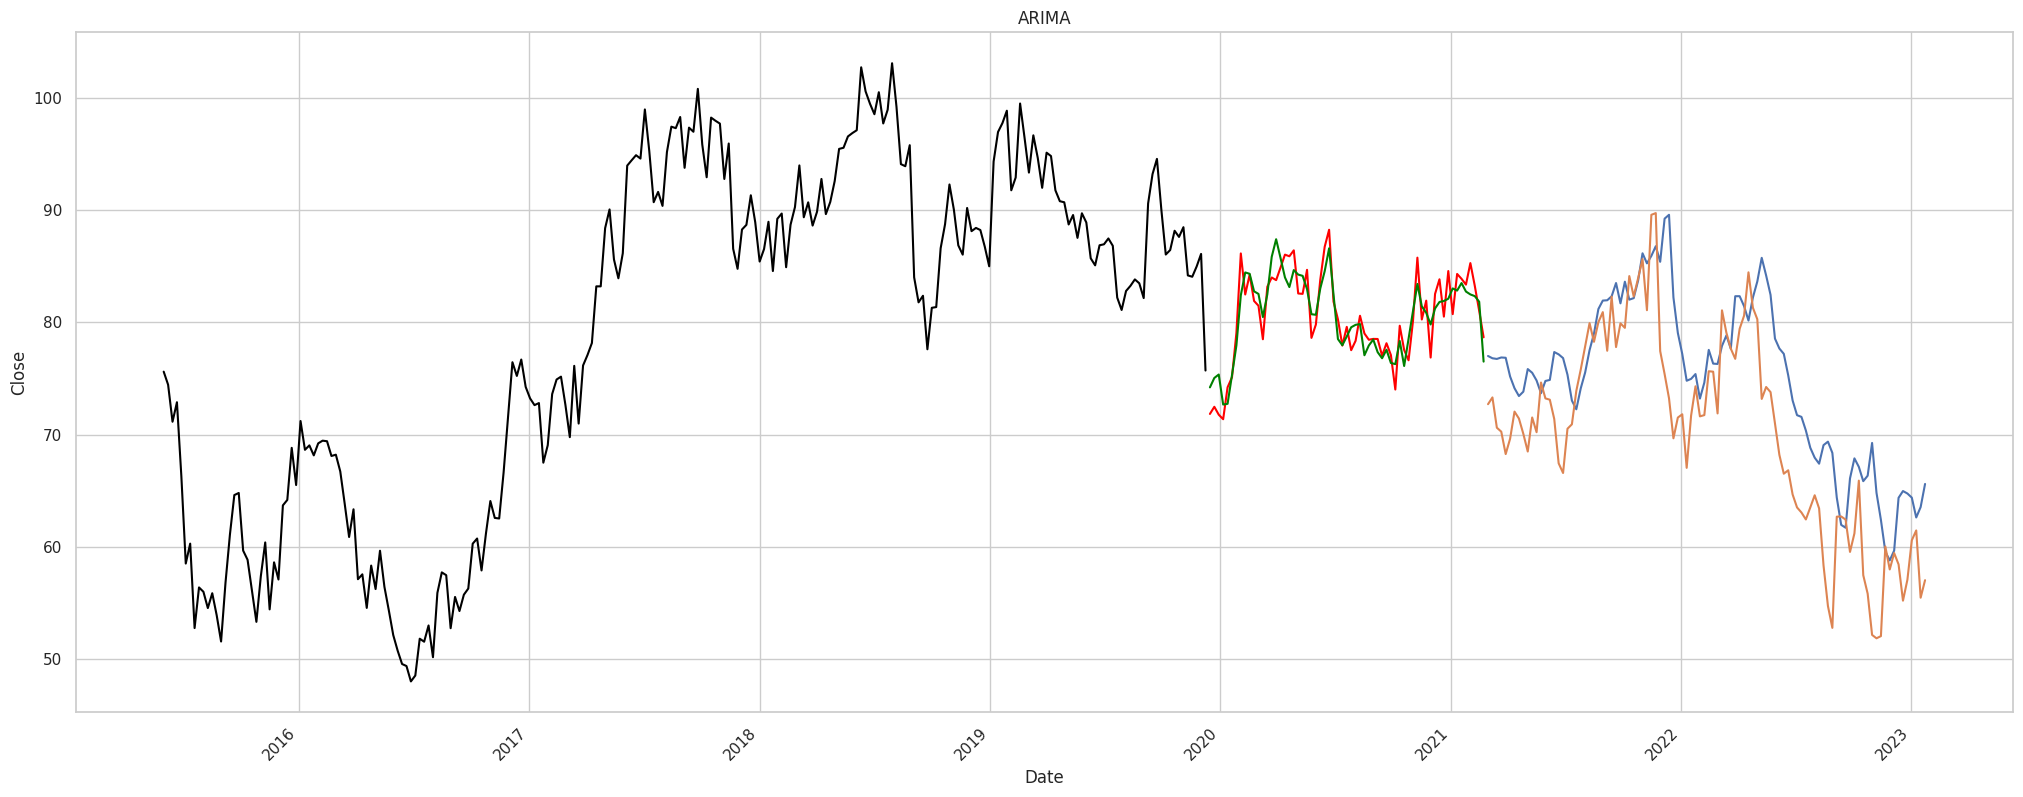

In [146]:
plt.figure(figsize=(25,10))
plt.plot(y_train, color = "black")
plt.plot(y_test, color = "red")
plt.plot(test['predicted_ARIMAX'] , color='green', label = 'ARIMAX Prediction')
test_df['Close_Arimax'].plot()
test_df['Open'].plot()
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("ARIMA")
plt.show()

- In the EDA Phase we noticed that Close is linearly related with Open column.
- The variation of the above forecast is similar to Open column, hence we can consider that this model is performing good.
- But since there is seasonal pattern, SARIMA *might* perform little bit better, so we will be going with SARIMA and SARIMAX as well

## SARIMA Model
- SMAPE: 0.022476473413754274

In [41]:
SARIMARUN = False
# SARIMARUN = True
if SARIMARUN:
    import itertools
    p = q = range (0,5)
    d = [0,1]
    s = [52]

    pdq = list(itertools.product (p, d, q, s))

    print(len(pdq))
    contin = int(input())

    if contin:
        store = {}
        for i,param in enumerate(pdq):
            predictedValues = []
            try:
                model_sarima = sm.tsa.arima.ARIMA (y_train, order = (6,0,3), seasonal_order = param)
                model_sarima_fit = model_sarima.fit()
                
                predict = model_sarima_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1)
                predictedValues = predict.values
                
                smape =  np.mean(np.abs(predictedValues - y_test['Close']) / (np.abs(predictedValues) + np.abs(y_test['Close'])))
                store[param] = smape
                
                print(f"{i+1}/{len(pdq)}: {param} : SMAPE: {smape} : Lowest : {min(list(store.items()), key = lambda x: x[1])}")
            except:
                continue

        sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
        print(sorted_dict)

In [147]:
model_sarima = sm.tsa.arima.ARIMA (y_train, order = (6,0,3), seasonal_order = (4,1,3,12))
model_sarima_fit = model_sarima.fit()

predict = model_sarima_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1)
test['predicted'] = predict.values

smape =  np.mean(np.abs(test['predicted'] - y_test['Close']) / (np.abs(test['predicted']) + np.abs(y_test['Close'])))
smape

0.02320813557247966

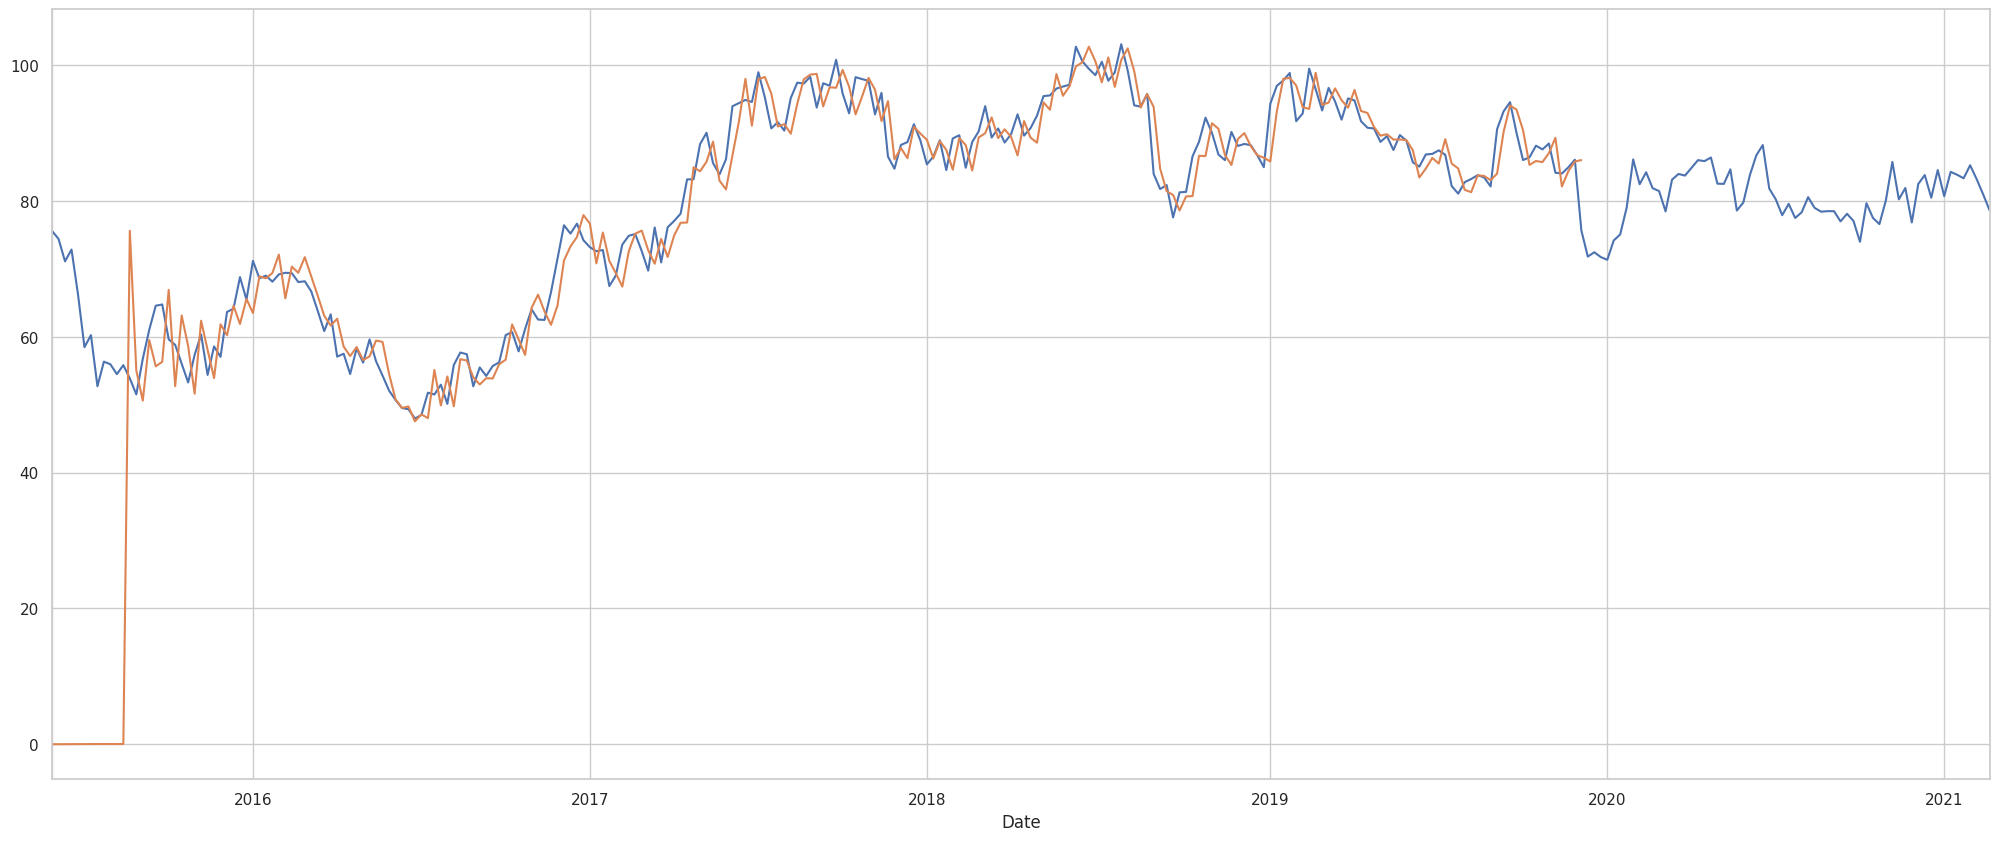

In [148]:
df_fe['Close'].plot(figsize=(25,10))
model_sarima_fit.fittedvalues.plot()
plt.show()

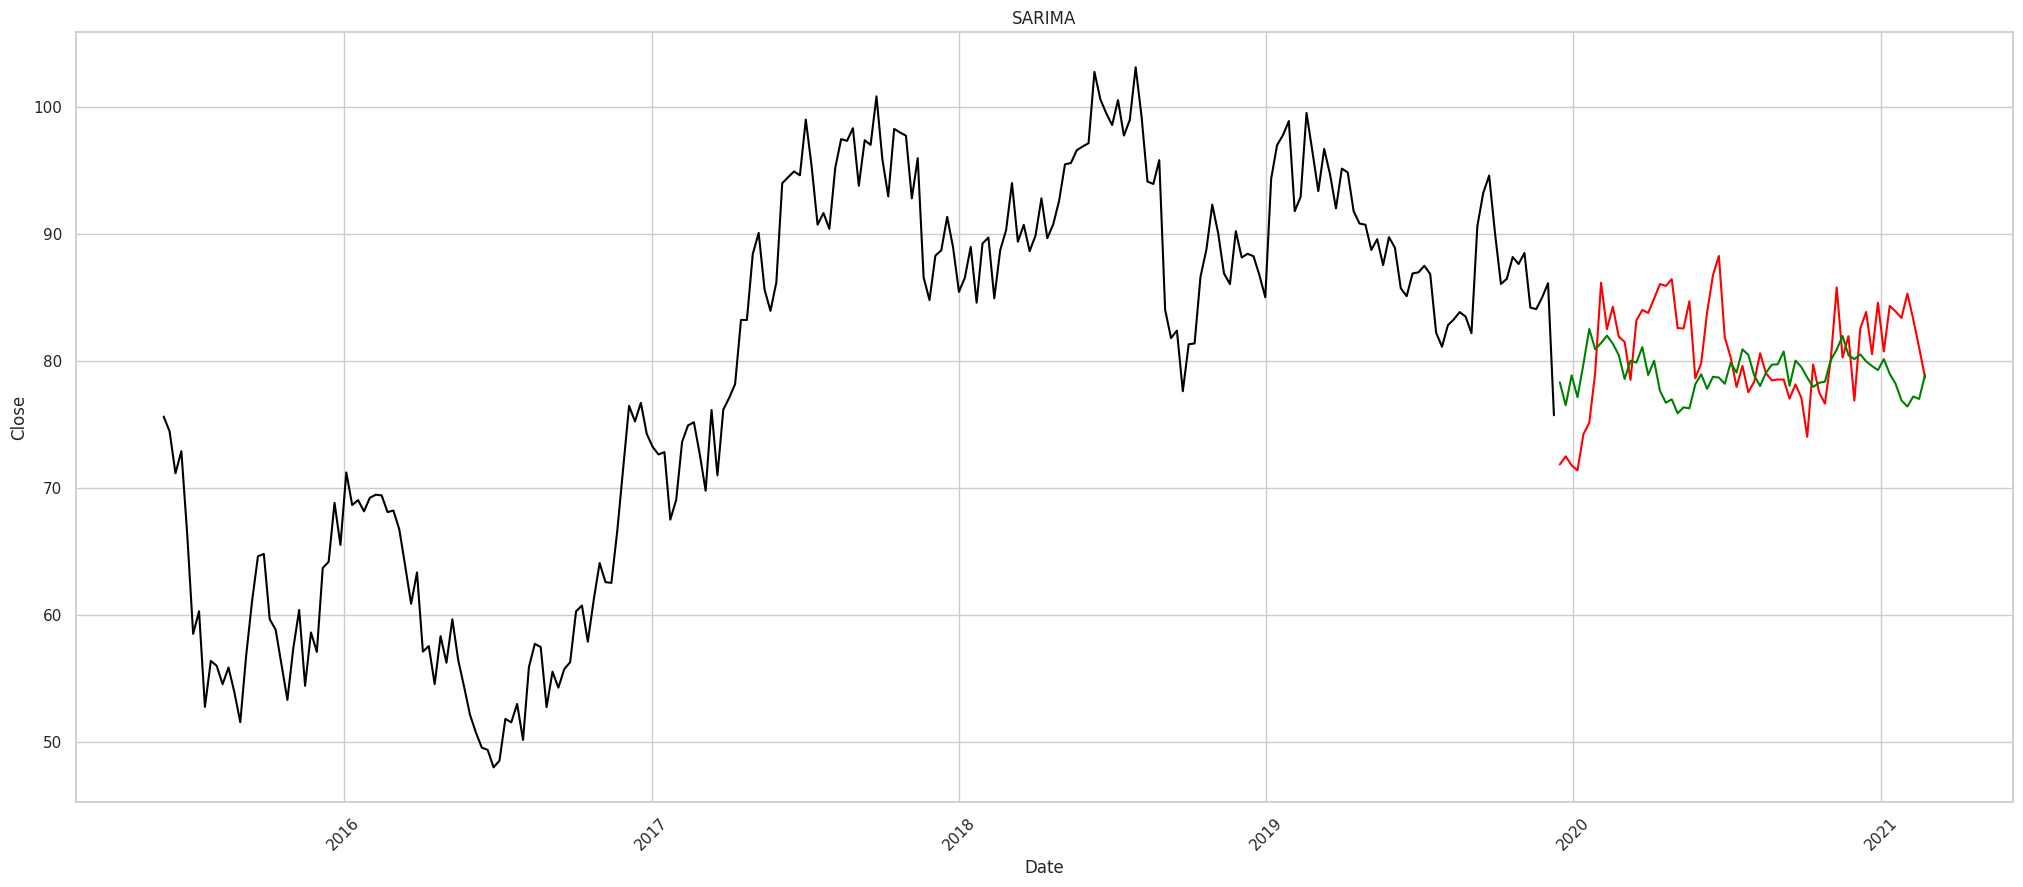

MAE: 3.7146560108482016
RMSE: 4.607811183069874
SMAPE:  0.02320813557247966


In [149]:
plt.figure(figsize=(25,10))
plt.plot(y_train, color = "black")
plt.plot(y_test, color = "red")
plt.plot(test['predicted'] , color='green', label = 'SARIMA Prediction')

plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("SARIMA")
plt.show()

MAE = mean_absolute_error(y_test, test["predicted"])
RMSE = math.sqrt(mean_squared_error(y_test, test["predicted"]))

print("MAE:", MAE)
print("RMSE:", RMSE)
print("SMAPE: ",np.mean(np.abs(test["predicted"] - y_test['Close']) / (np.abs(test["predicted"]) + np.abs(y_test['Close']))))

We did not get better results than ARIMA with SARIMA, regardless we will go ahead with SARIMAX.

## SARIMAX Model
- SMAPE: 0.009145104493503574

In [45]:
SARIMAXRUN = False
# SARIMAXRUN = True
if SARIMAXRUN:
    import itertools
    p = q = range (0,5)
    d = [0,1]
    s = [12]

    pdq = list(itertools.product (p, d, q, s))

    print(len(pdq))
    contin = int(input())

    if contin:
        store = {}
        for i,param in enumerate(pdq):
            predictedValues = []
            try:
                model_SARIMAX = sm.tsa.arima.ARIMA (y_train, order = (6,0,3), seasonal_order = param, exog = X_train)
                model_SARIMAX_fit = model_SARIMAX.fit()
                
                predict = model_SARIMAX_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1, exog = X_test)
                predictedValues = predict.values
                
                smape =  np.mean(np.abs(predictedValues - y_test['Close']) / (np.abs(predictedValues) + np.abs(y_test['Close'])))
                store[param] = smape
                
                print(f"{i+1}/{len(pdq)}: {param} : SMAPE: {smape} : Lowest : {min(list(store.items()), key = lambda x: x[1])}")
            except:
                continue

        sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
        print(sorted_dict)

In [150]:
len(y_train) 

237

In [151]:
len(y_train)+len(y_test)

300

In [152]:
model_sarima = sm.tsa.arima.ARIMA (y_train, order = (6,0,3), seasonal_order = (1,0,1,12), exog = X_train)
model_sarima_fit = model_sarima.fit()

predict = model_sarima_fit.predict(start = len(y_train),end = len(y_train)+len(y_test)-1, exog = X_test)
test['predicted_Sarimax'] = predict.values

smape =  np.mean(np.abs(test['predicted_Sarimax'] - y_test['Close']) / (np.abs(test['predicted_Sarimax']) + np.abs(y_test['Close'])))
smape

0.009008065974543001

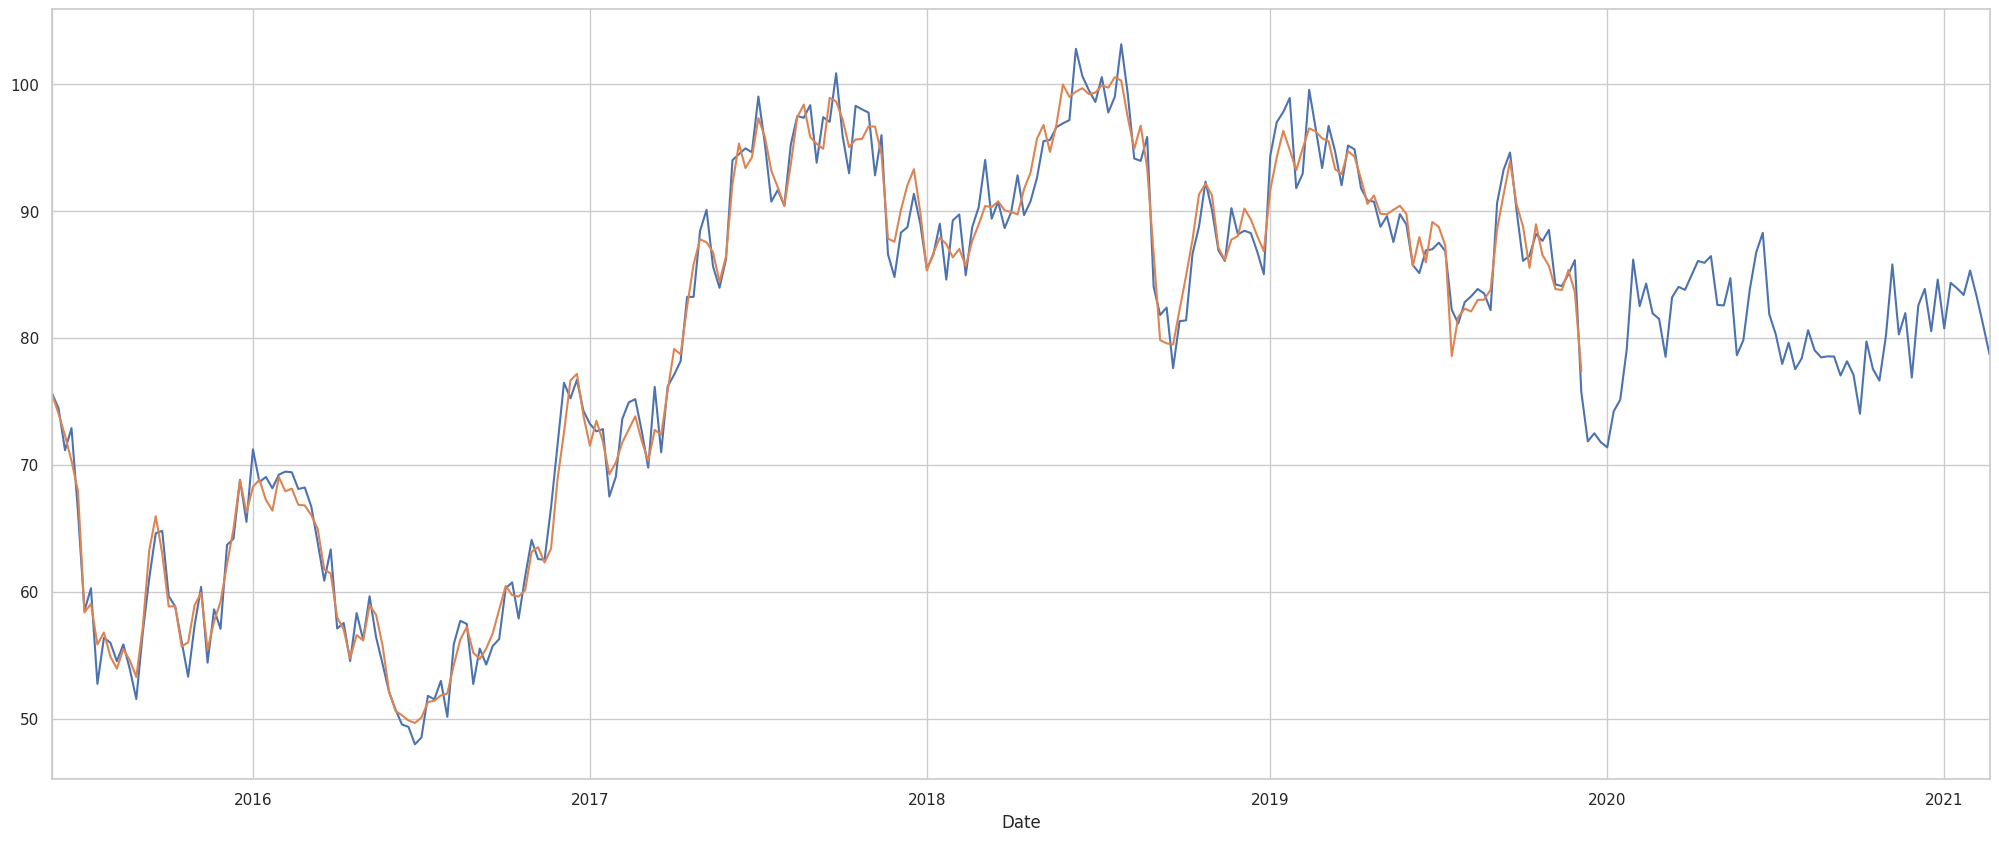

In [153]:
df_fe['Close'].plot(figsize=(25,10))
model_sarima_fit.fittedvalues.plot()
plt.show()

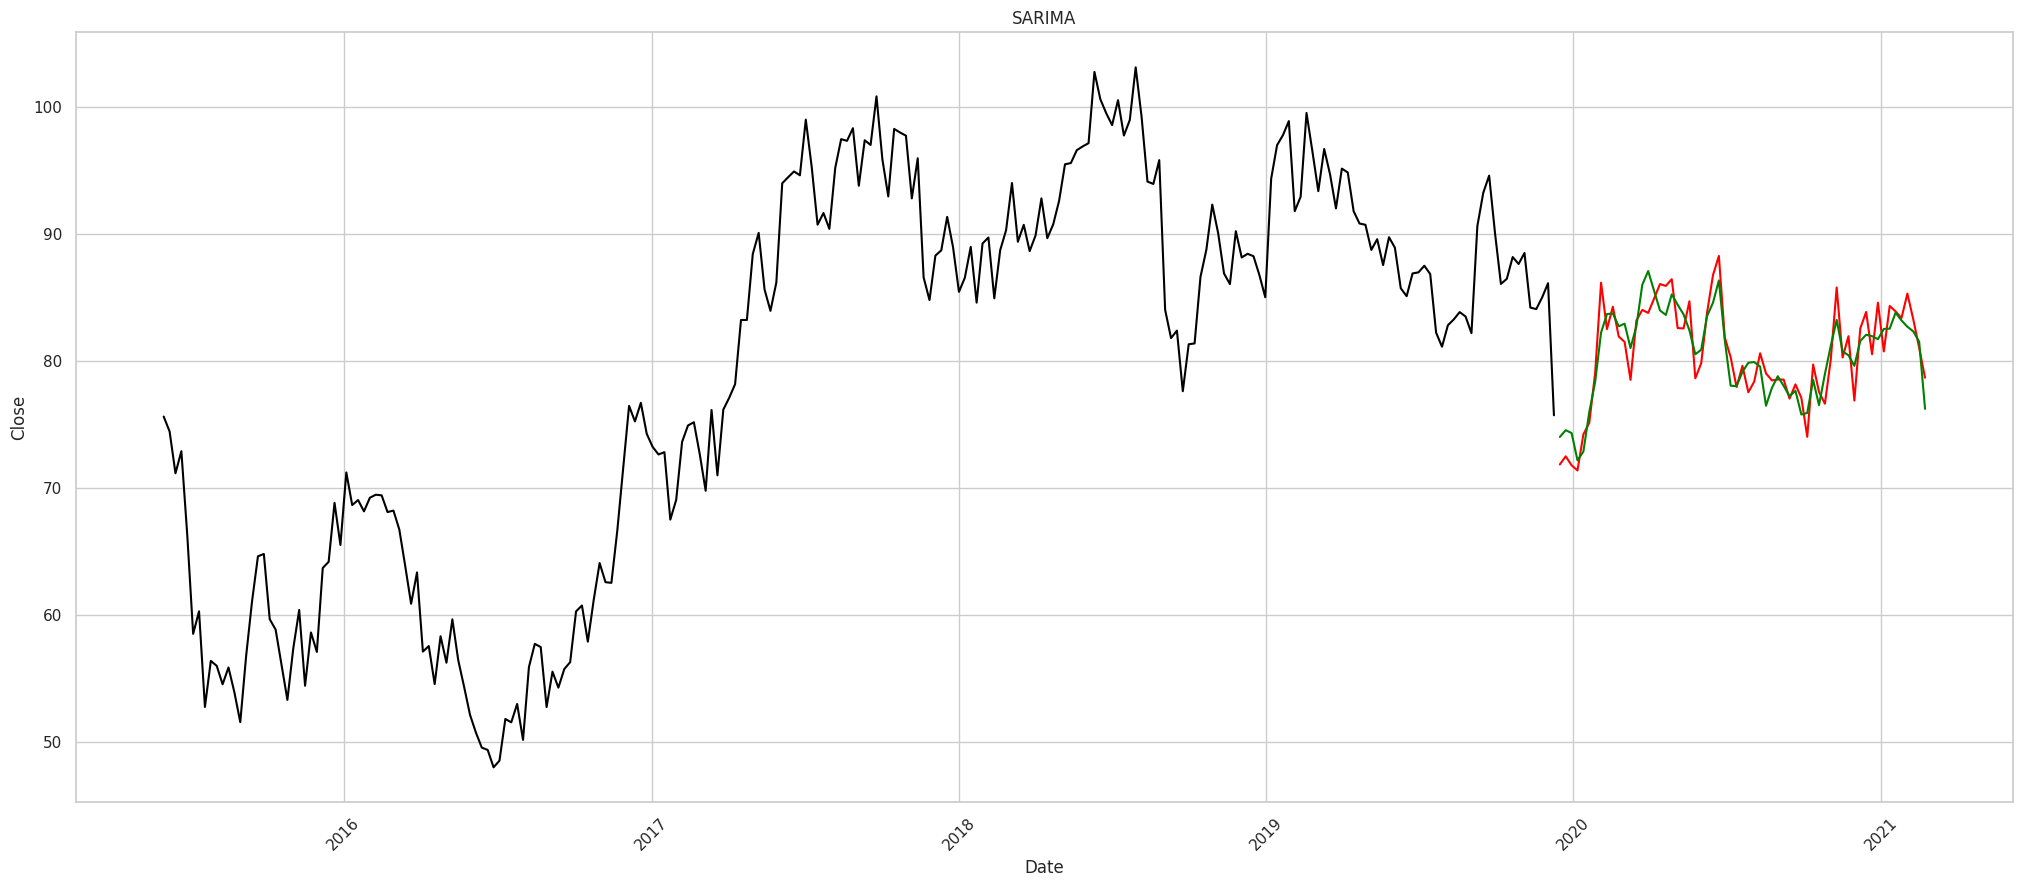

MAE: 1.4519239945128617
RMSE: 1.7006502949421252
SMAPE:  0.009008065974543001


In [154]:
plt.figure(figsize=(25,10))
plt.plot(y_train, color = "black")
plt.plot(y_test, color = "red")
plt.plot(test['predicted_Sarimax'] , color='green', label = 'SARIMA Prediction')

plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("SARIMA")
plt.show()

MAE = mean_absolute_error(y_test, test["predicted_Sarimax"])
RMSE = math.sqrt(mean_squared_error(y_test, test["predicted_Sarimax"]))

print("MAE:", MAE)
print("RMSE:", RMSE)
print("SMAPE: ",np.mean(np.abs(test["predicted_Sarimax"] - y_test['Close']) / (np.abs(test["predicted_Sarimax"]) + np.abs(y_test['Close']))))

## Forecasting for the entire test dataset for SARIMAX

In [155]:
len(y_train)+len(y_test)+len(test_df_scaled)-1 - len(y_train)

162

In [156]:
np.concatenate([X_test,test_df_scaled]).shape

(163, 14)

In [157]:
print(test_df_scaled.shape)
print(X_test.shape)
print(X_train.shape)

(100, 14)
(63, 14)
(237, 14)


In [158]:
forecast_test = model_sarima_fit.predict(start = 300,end = 400-1,exog = np.concatenate([X_test, test_df_scaled])).values

print(forecast_test[-100:])

[77.09601623 77.22585303 77.00714888 76.93372409 76.63606405 74.85730244
 73.87789798 73.49754991 74.20504977 76.10668257 75.3934428  74.19866062
 73.17759579 74.62625134 75.19210931 77.77702667 77.19641981 76.44424214
 74.89523763 72.68396614 72.27373433 74.61062457 75.91844493 77.75181289
 78.81304432 80.95573124 81.72878744 82.08813484 82.7122562  83.82776246
 81.48597917 83.31542983 81.67109641 82.03311631 83.9803655  86.34823871
 85.21351593 85.65090481 86.5083924  85.09201552 89.48316811 89.88392653
 82.18382689 78.97467564 76.93869433 74.56108605 75.06998871 75.85266694
 73.496604   74.95916739 77.50825646 75.92311876 76.06621892 78.13016658
 79.07394762 77.75118195 82.51250149 82.04540442 81.00429438 79.82334456
 82.32276655 83.88055389 86.05145016 84.06143613 82.05011982 78.05599593
 77.64828631 77.51849946 75.5515588  73.14875899 71.59331103 71.45758494
 70.24296645 68.96323062 68.17916683 67.64110529 69.1549407  69.26729622
 68.09788408 64.17136125 61.98379374 61.87574535 66

In [159]:
test_df['Close_Sarimax'] = forecast_test[-100:]
test_df.head()

Ahead2_Open  Lag1_Open  Lag2_Open  Lag3_Open  Trend_Volume  \
Date                                                                     
2021-03-01    70.610119  72.708331  72.708331  72.708331  2.012458e+08   
2021-03-08    70.256017  72.708331  72.708331  72.708331  2.012458e+08   
2021-03-15    68.258324  73.310886  72.708331  72.708331  2.012458e+08   
2021-03-22    69.625390  70.610119  73.310886  72.708331  2.012458e+08   
2021-03-29    72.046746  70.256017  70.610119  73.310886  2.012458e+08   

            Ahead3_Open  MA_Open_3  Ahead1_Open  MA_Open_5       Open  \
Date                                                                    
2021-03-01    70.256017  72.209779    73.310886  71.028735  72.708331   
2021-03-08    68.258324  72.209779    70.610119  71.028735  73.310886   
2021-03-15    69.625390  72.209779    70.256017  71.028735  70.610119   
2021-03-22    72.046746  71.392341    68.258324  71.028735  70.256017   
2021-03-29    71.426418  69.708153    69.625390  71.028735  68.258324   

            MA_Open_10  Lag5_Open  Lag4_Open  Trend_Open  Close_Arimax  \
Date                                                                     
2021-03-01   70.678602  72.708331  72.708331   70.790178     77.007015   
2021-03-08   70.678602  72.708331  72.708331   70.790178     76.803078   
2021-03-15   70.678602  72.708331  72.708331   70.790178     76.745159   
2021-03-22   70.678602  72.708331  72.708331   70.790178     76.874442   
2021-03-29   70.678602  72.708331  72.708331   70.790178     76.848154   

            Close_Sarimax  
Date                       
2021-03-01      77.096016  
2021-03-08      77.225853  
2021-03-15      77.007149  
2021-03-22      76.933724  
2021-03-29      76.636064

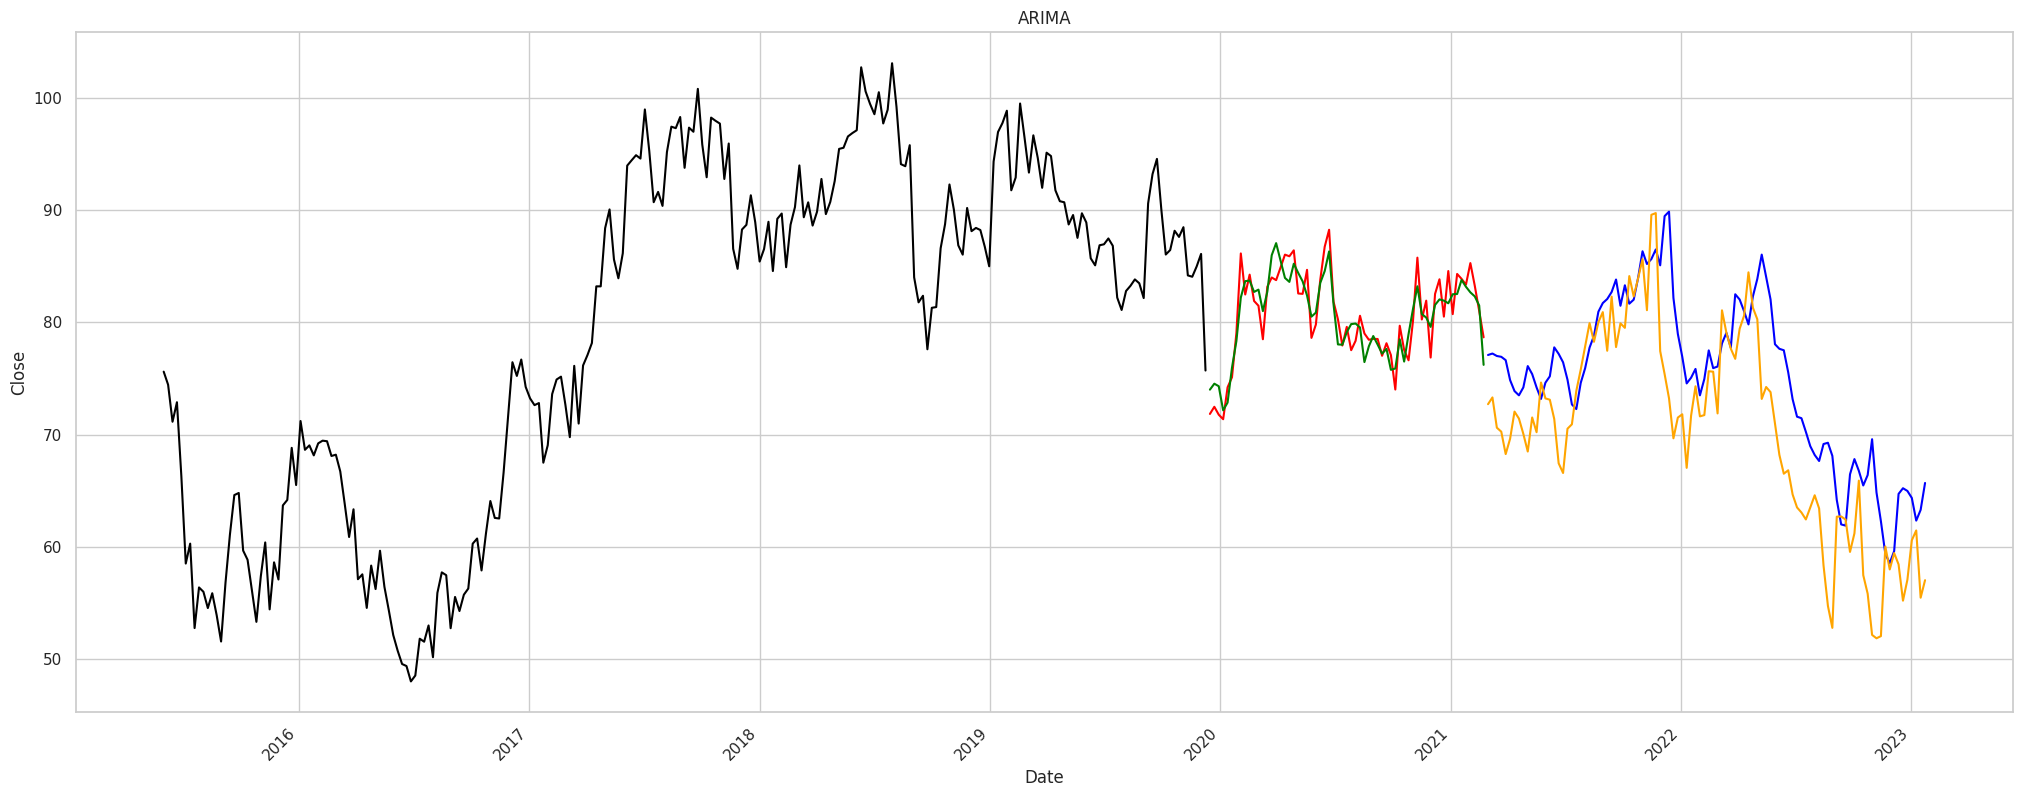

In [160]:
plt.figure(figsize=(25,10))
plt.plot(y_train, color = "black")
plt.plot(y_test, color = "red")
plt.plot(test['predicted_Sarimax'] , color='green', label = 'SARIMAX Prediction')
# test_df['Close_Arimax'].plot(color = 'purple')
test_df['Close_Sarimax'].plot(color = 'blue')
test_df['Open'].plot(color = 'orange')
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("ARIMA")
plt.show()


- We will insert the predictions in the submission dataframe

In [161]:
df_submission = pd.read_csv('/kaggle/input/ue21cs342aa2/sample_submission.csv')
df_submission['Close'] = test_df['Close_Sarimax'].values
df_submission.head(50)

id        Date      Close Strategy
0    0  2021-03-01  77.096016      Buy
1    1  2021-03-08  77.225853      Buy
2    2  2021-03-15  77.007149      Buy
3    3  2021-03-22  76.933724      Buy
4    4  2021-03-29  76.636064      Buy
5    5  2021-04-05  74.857302      Buy
6    6  2021-04-12  73.877898      Buy
7    7  2021-04-19  73.497550      Buy
8    8  2021-04-26  74.205050      Buy
9    9  2021-05-03  76.106683      Buy
10  10  2021-05-10  75.393443      Buy
11  11  2021-05-17  74.198661      Buy
12  12  2021-05-24  73.177596      Buy
13  13  2021-05-31  74.626251      Buy
14  14  2021-06-07  75.192109      Buy
15  15  2021-06-14  77.777027      Buy
16  16  2021-06-21  77.196420      Buy
17  17  2021-06-28  76.444242      Buy
18  18  2021-07-05  74.895238      Buy
19  19  2021-07-12  72.683966      Buy
20  20  2021-07-19  72.273734      Buy
21  21  2021-07-26  74.610625      Buy
22  22  2021-08-02  75.918445      Buy
23  23  2021-08-09  77.751813      Buy
24  24  2021-08-16  78.813044      Buy
25  25  2021-08-23  80.955731      Buy
26  26  2021-08-30  81.728787      Buy
27  27  2021-09-06  82.088135      Buy
28  28  2021-09-13  82.712256      Buy
29  29  2021-09-20  83.827762      Buy
30  30  2021-09-27  81.485979      Buy
31  31  2021-10-04  83.315430      Buy
32  32  2021-10-11  81.671096      Buy
33  33  2021-10-18  82.033116      Buy
34  34  2021-10-25  83.980365      Buy
35  35  2021-11-01  86.348239      Buy
36  36  2021-11-08  85.213516      Buy
37  37  2021-11-15  85.650905      Buy
38  38  2021-11-22  86.508392      Buy
39  39  2021-11-29  85.092016      Buy
40  40  2021-12-06  89.483168     Hold
41  41  2021-12-13  89.883927     Hold
42  42  2021-12-20  82.183827     Hold
43  43  2021-12-27  78.974676     Hold
44  44  2022-01-03  76.938694     Hold
45  45  2022-01-10  74.561086     Hold
46  46  2022-01-17  75.069989     Hold
47  47  2022-01-24  75.852667     Hold
48  48  2022-01-31  73.496604     Hold
49  49  2022-02-07  74.959167     Hold

<Axes: >

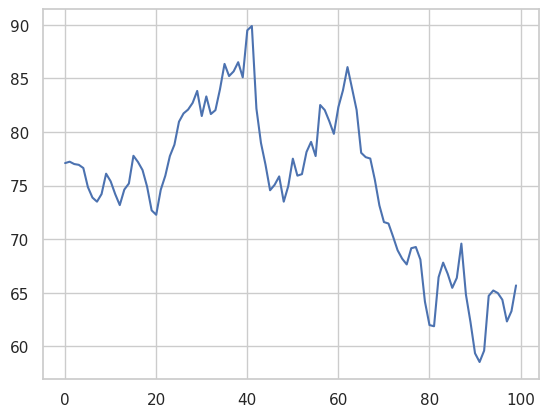

In [162]:
df_submission['Close'].plot()

- We now have to predict the Strategy
- Since strategy is a categorical data which can have 3 values, Sell, Hold and Buy, we will be using a classification model
- We will be using multiple classfication model to check which will give an accurate result
- We will start off with the Data cleaning part now

## Predicting for Strategy

### EDA

In [163]:
df.head()

Open      Close     Volume Strategy
Date                                                
2015-06-01  66.208486  75.609978  298506300     Hold
2015-06-08  64.116235  74.443331  227974800     Hold
2015-06-15  47.701942  71.140831  250670900      Buy
2015-06-22  54.754816  72.881344  223614300     Hold
2015-06-29  48.031899  66.284718  406814900      Buy

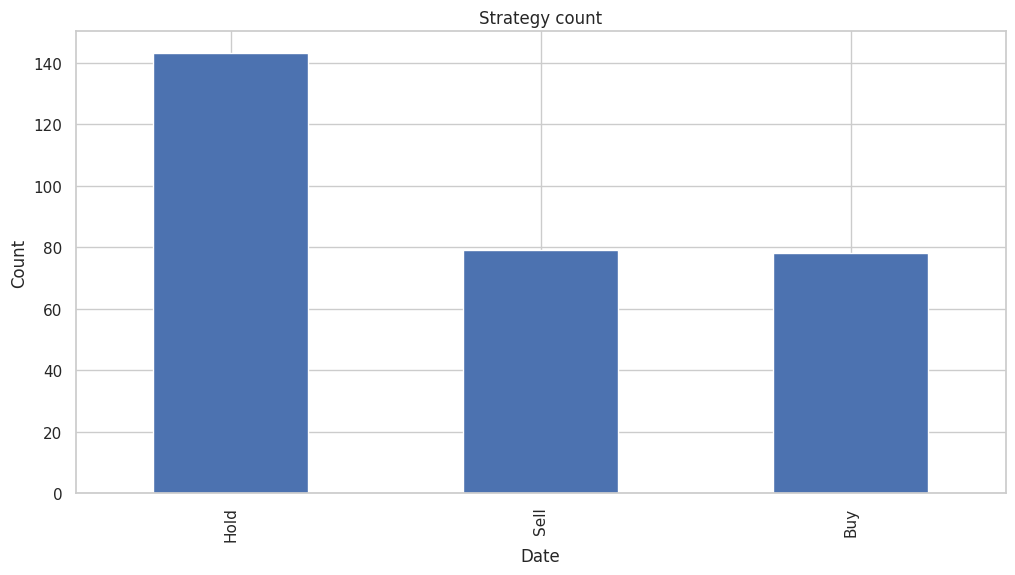

In [164]:
plt.figure(figsize=(12, 6))
df['Strategy'].value_counts().plot(kind='bar')
plt.title('Strategy count')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

<Figure size 2500x1000 with 0 Axes>

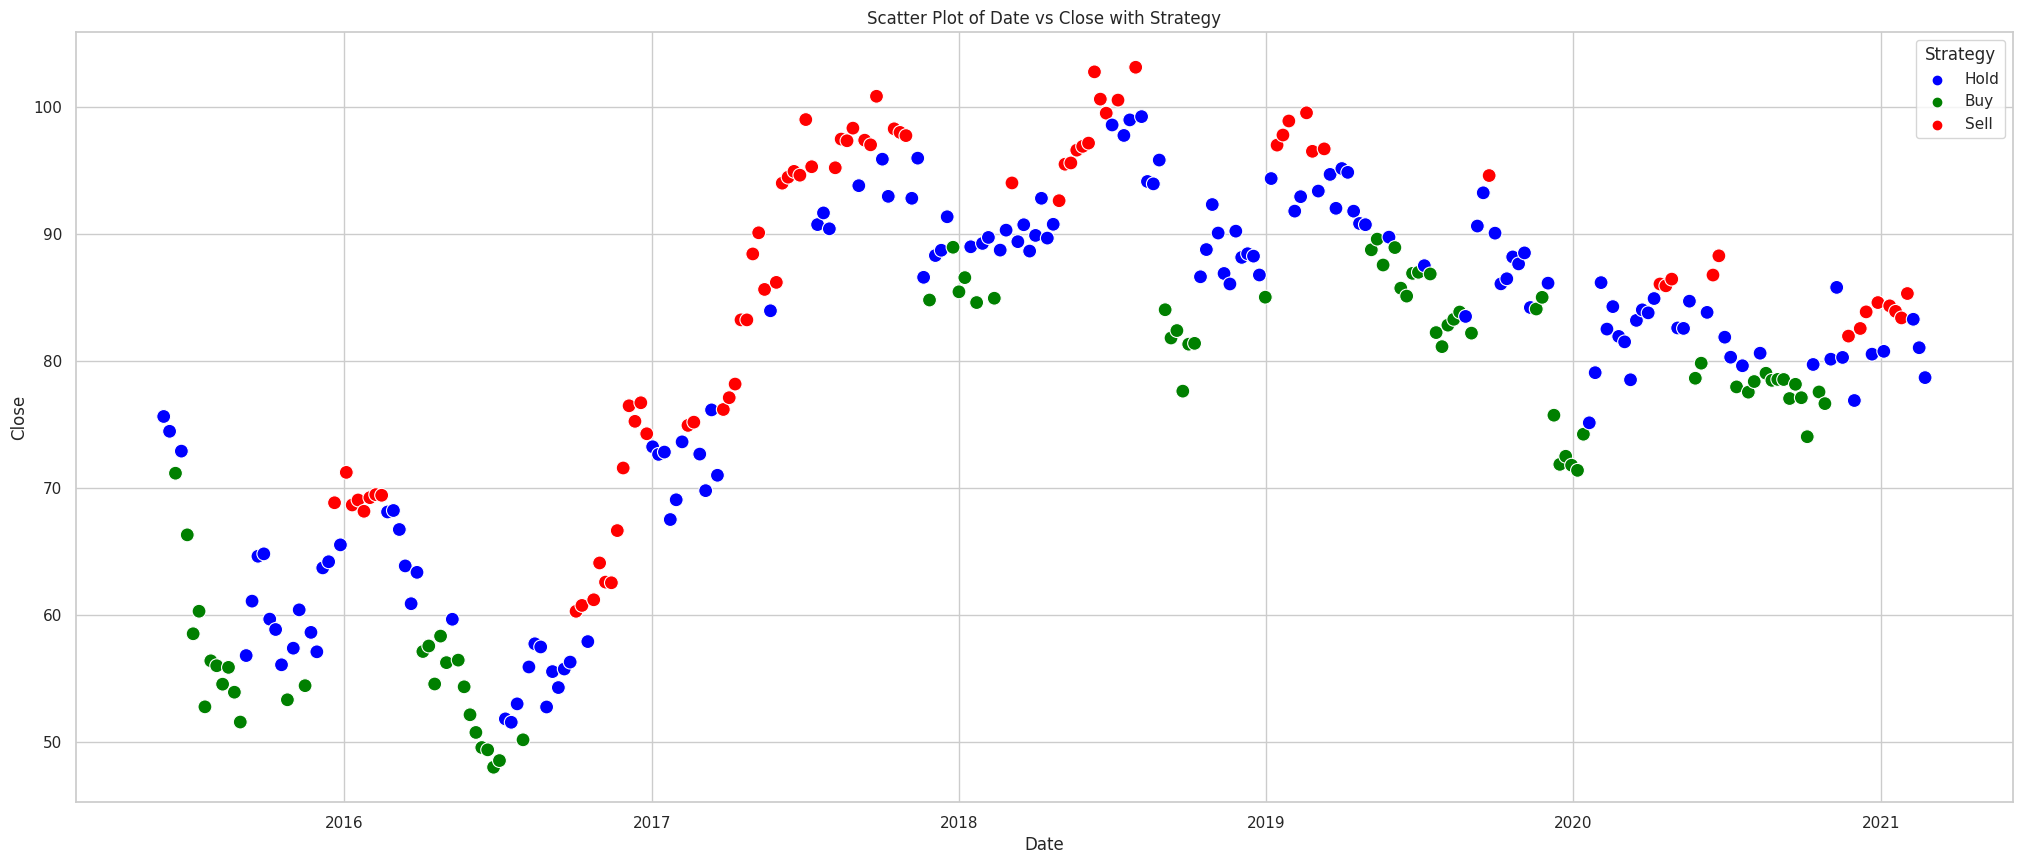

In [165]:
plt.figure(figsize=(25, 10))
x_plot = 'Date'
y_plot = 'Close'

sns.set(style="whitegrid")

plt.figure(figsize=(25, 10))
sns.scatterplot(data = df,x = x_plot, y = y_plot, hue = 'Strategy', palette = ['blue', 'green', 'red'], s = 100)
plt.title(f'Scatter Plot of {x_plot} vs {y_plot} with Strategy')
plt.show()

<Figure size 2500x1000 with 0 Axes>

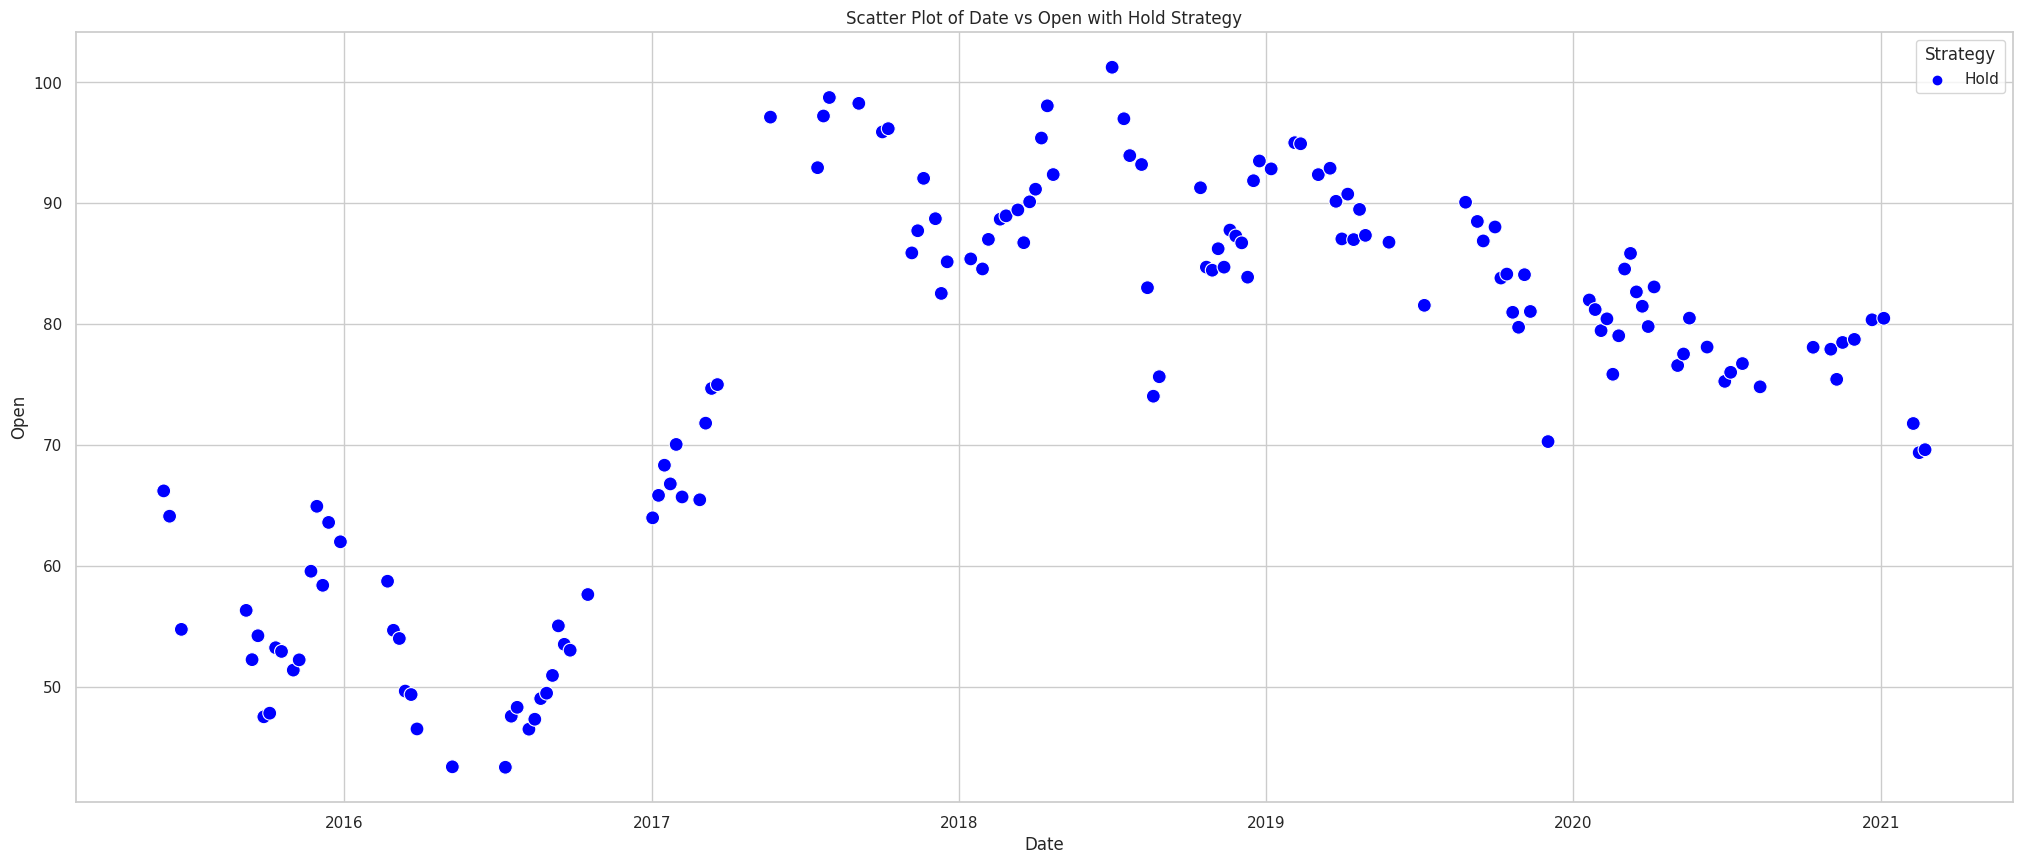

In [166]:
plt.figure(figsize=(25, 10))
x_plot = 'Date'
y_plot = 'Open'

sns.set(style="whitegrid")

plt.figure(figsize=(25, 10))
sns.scatterplot(data = df[df['Strategy'] == 'Hold'],x=x_plot, y=y_plot, hue='Strategy', palette=['blue', 'green', 'red'], s=100)
plt.title(f'Scatter Plot of {x_plot} vs {y_plot} with Hold Strategy')
plt.show()

<Figure size 2500x1000 with 0 Axes>

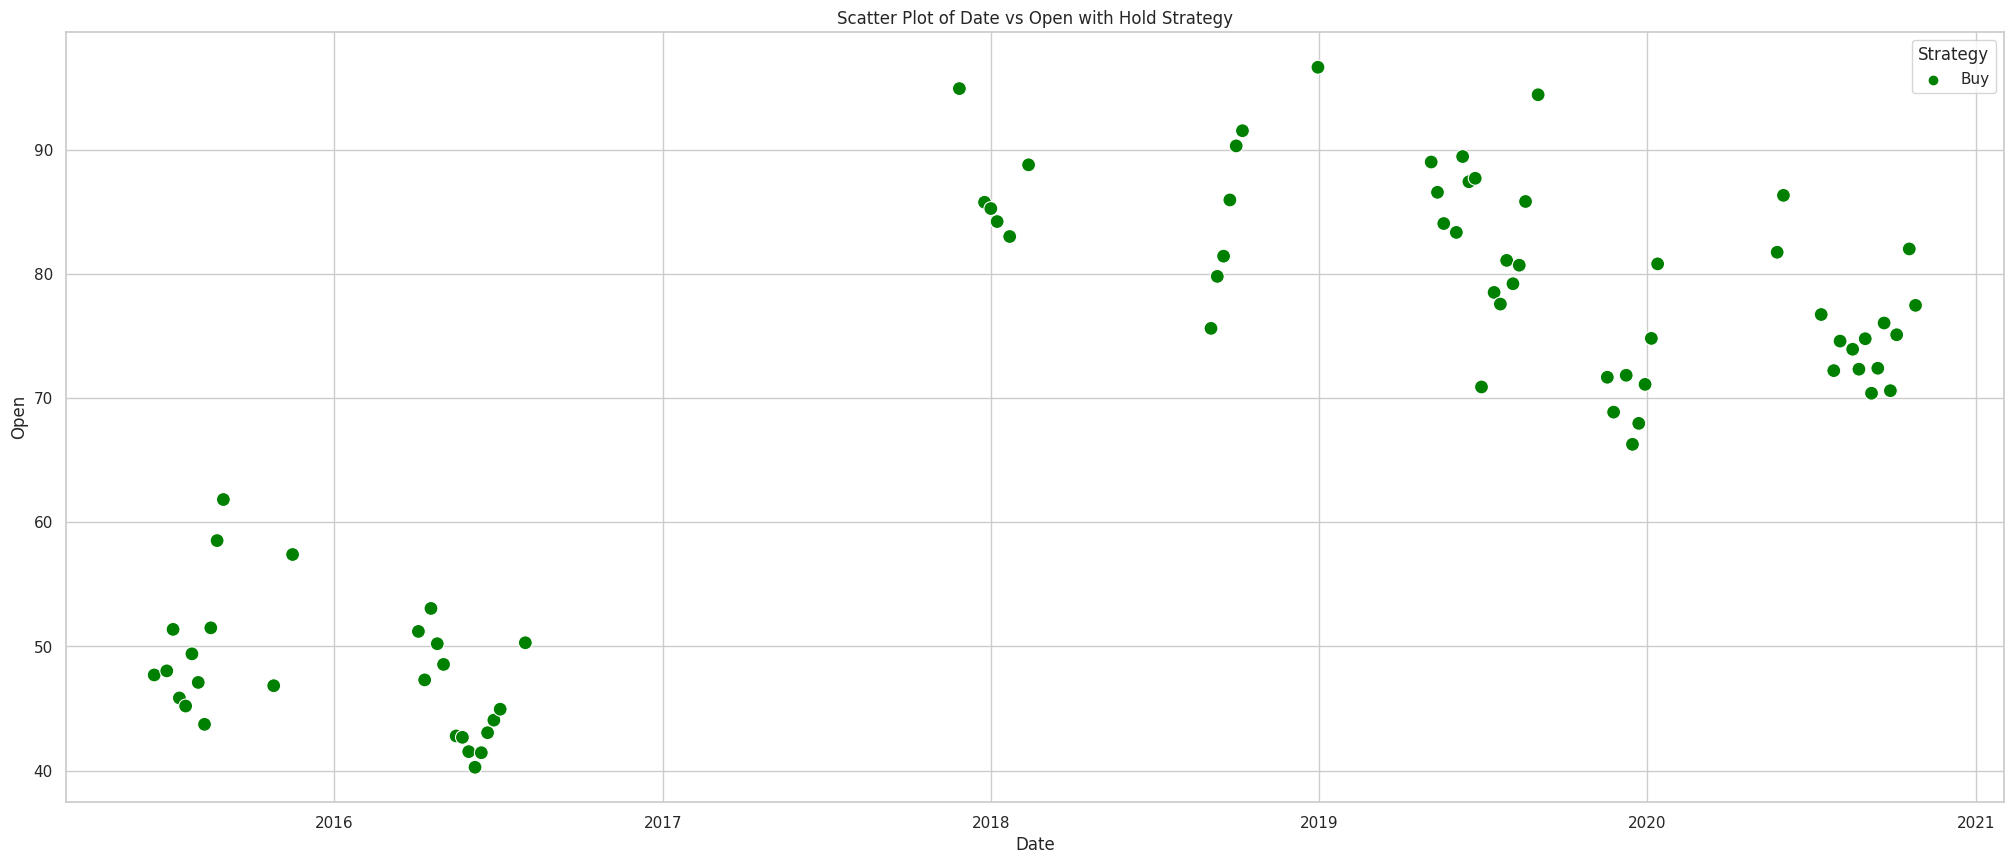

In [167]:
plt.figure(figsize=(25, 10))
x_plot = 'Date'
y_plot = 'Open'

sns.set(style="whitegrid")

plt.figure(figsize=(25, 10))
sns.scatterplot(data = df[df['Strategy'] == 'Buy'],x=x_plot, y=y_plot, hue='Strategy', palette=['green'], s=100)
plt.title(f'Scatter Plot of {x_plot} vs {y_plot} with Hold Strategy')
plt.show()

<Figure size 2500x1000 with 0 Axes>

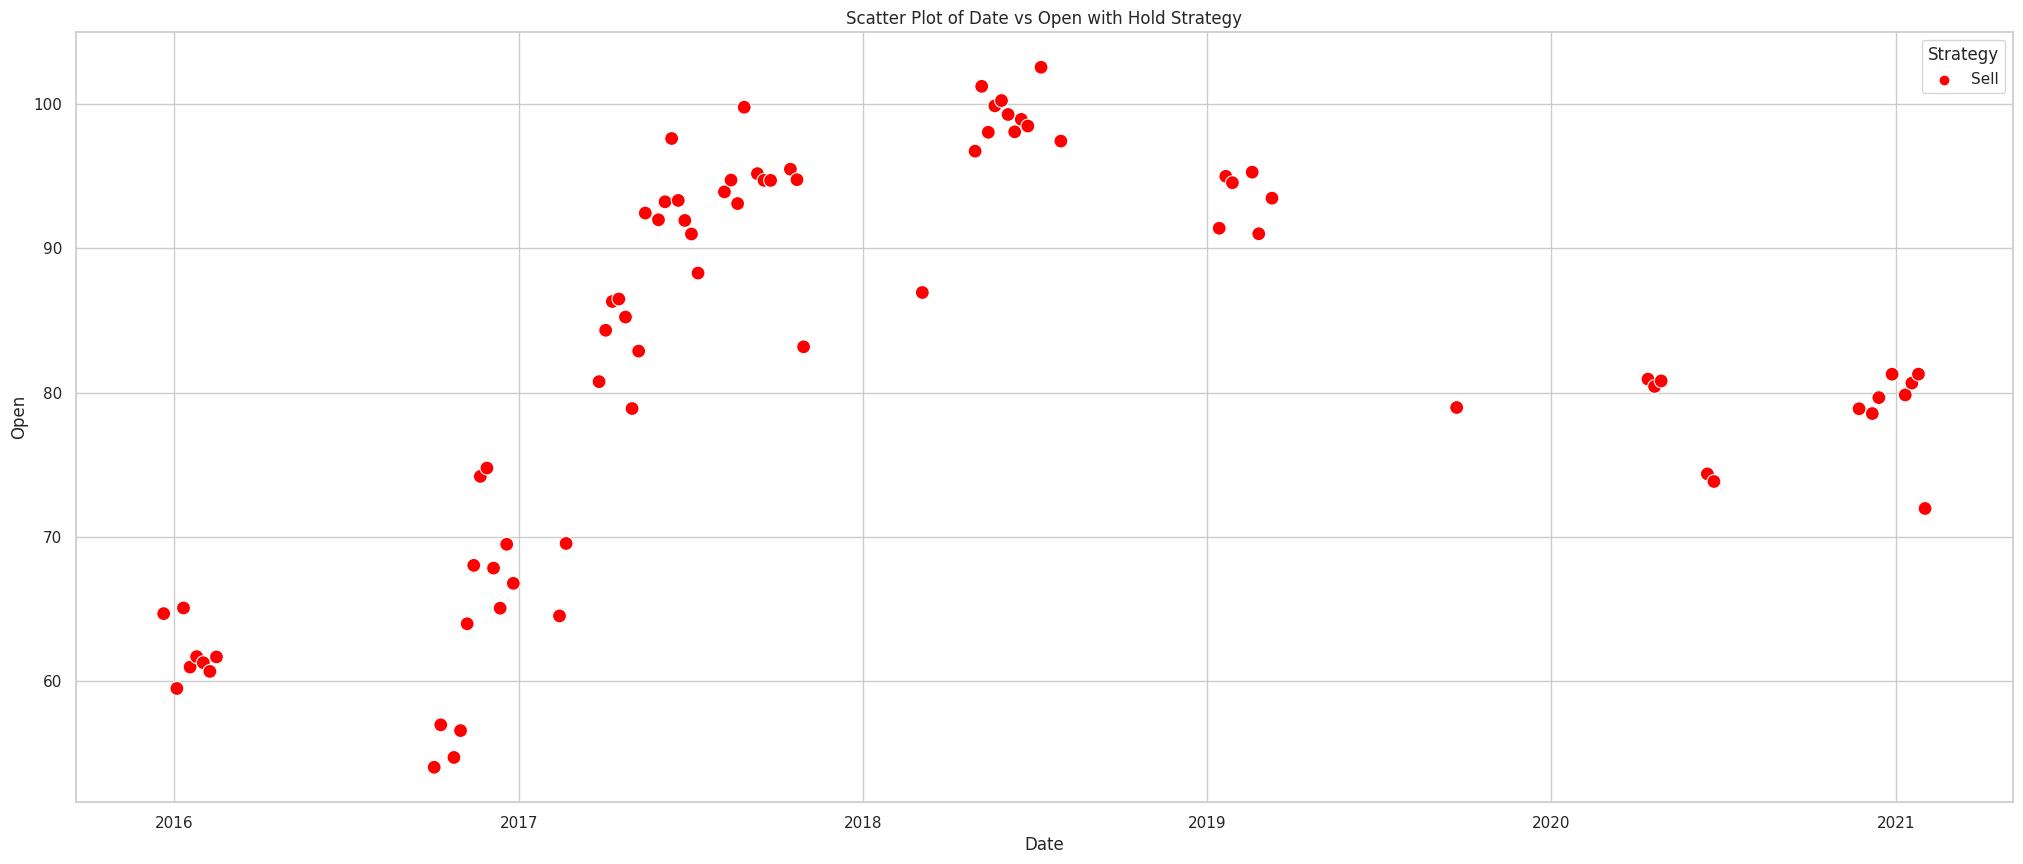

In [168]:
plt.figure(figsize=(25, 10))
x_plot = 'Date'
y_plot = 'Open'

sns.set(style="whitegrid")

plt.figure(figsize=(25, 10))
sns.scatterplot(data = df[df['Strategy'] == 'Sell'],x=x_plot, y=y_plot, hue='Strategy', palette=['red'], s=100)
plt.title(f'Scatter Plot of {x_plot} vs {y_plot} with Hold Strategy')
plt.show()

### Data Cleaning and Preparation

In [169]:
df.head()

Open      Close     Volume Strategy
Date                                                
2015-06-01  66.208486  75.609978  298506300     Hold
2015-06-08  64.116235  74.443331  227974800     Hold
2015-06-15  47.701942  71.140831  250670900      Buy
2015-06-22  54.754816  72.881344  223614300     Hold
2015-06-29  48.031899  66.284718  406814900      Buy

- Since its stock prediction, we will make a column which will be the difference between the Close and Open columns

In [170]:
df_sgy = df.copy()
df_sgy['Close-Open'] = df_sgy['Close'] - df_sgy['Open']
print(f"Shape: {df_sgy.shape}")
df_sgy.head()

Shape: (300, 5)


Open      Close     Volume Strategy  Close-Open
Date                                                            
2015-06-01  66.208486  75.609978  298506300     Hold    9.401492
2015-06-08  64.116235  74.443331  227974800     Hold   10.327096
2015-06-15  47.701942  71.140831  250670900      Buy   23.438890
2015-06-22  54.754816  72.881344  223614300     Hold   18.126527
2015-06-29  48.031899  66.284718  406814900      Buy   18.252818

In [171]:
df_sgy.shape

(300, 5)

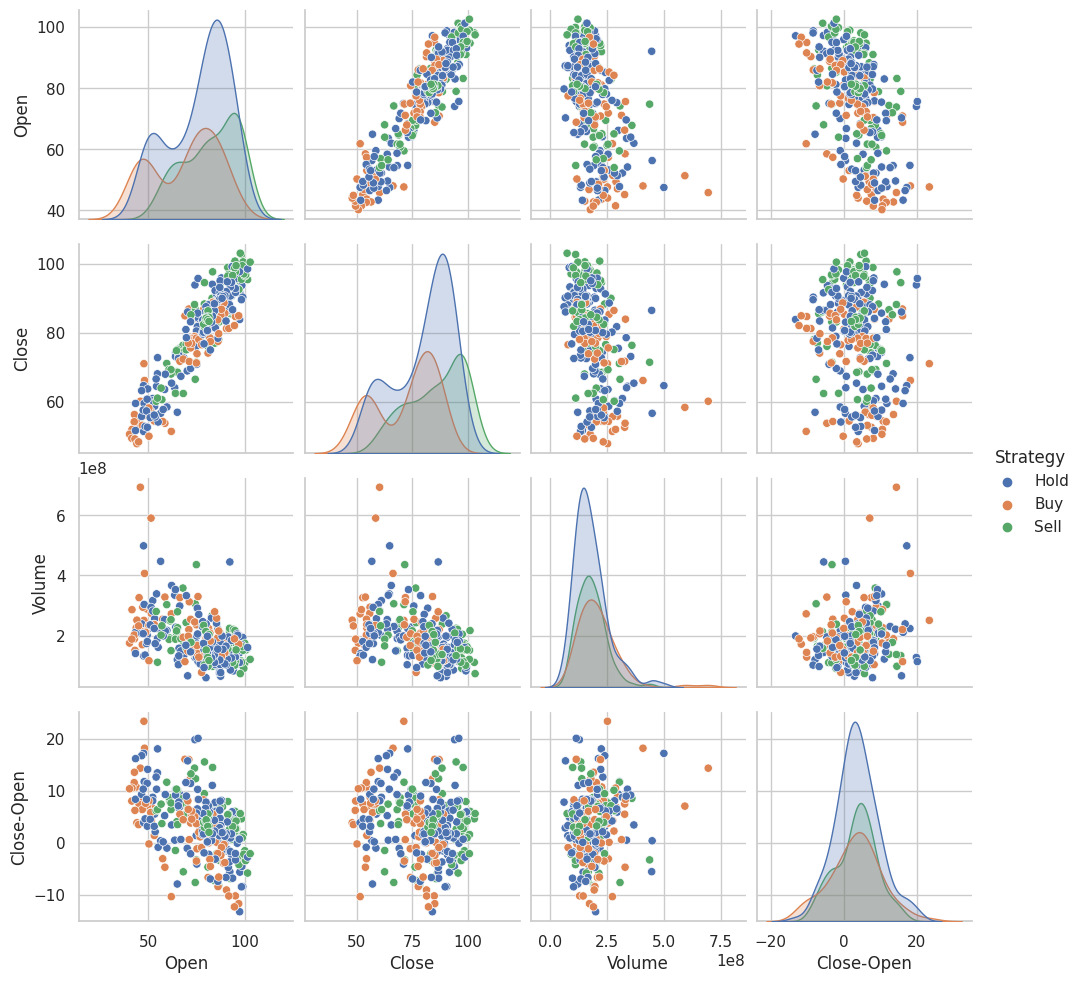

In [172]:
sns.pairplot(df_sgy, hue = 'Strategy')

In [173]:
df_sgy[['Open','Close','Volume','Close-Open']].corr(method='spearman')

Open     Close    Volume  Close-Open
Open        1.000000  0.900690 -0.465491   -0.571480
Close       0.900690  1.000000 -0.504802   -0.203084
Volume     -0.465491 -0.504802  1.000000    0.174180
Close-Open -0.571480 -0.203084  0.174180    1.000000

In [174]:
df_sgy[['Open','Close','Volume','Close-Open']].corr(method='kendall')

Open     Close    Volume  Close-Open
Open        1.000000  0.732397 -0.309164   -0.398528
Close       0.732397  1.000000 -0.342742   -0.130925
Volume     -0.309164 -0.342742  1.000000    0.110457
Close-Open -0.398528 -0.130925  0.110457    1.000000

### Feature Engineering and Train Test Split
- We will get all the features that can be engineered from the given data
- We will then plot the correlation matrix and get the relavent features
- After getting relavent features we will standardize the data and train the model

In [175]:
df_sgy.head()

Open      Close     Volume Strategy  Close-Open
Date                                                            
2015-06-01  66.208486  75.609978  298506300     Hold    9.401492
2015-06-08  64.116235  74.443331  227974800     Hold   10.327096
2015-06-15  47.701942  71.140831  250670900      Buy   23.438890
2015-06-22  54.754816  72.881344  223614300     Hold   18.126527
2015-06-29  48.031899  66.284718  406814900      Buy   18.252818

In [206]:
from sklearn.model_selection import train_test_split

X = df_sgy[['Open','Close','Volume']]
y = df_sgy[['Strategy']]

X['MA_Open_10'] = X['Open'].rolling(window=10).mean()
X['MA_Volume_10'] = X['Volume'].rolling(window=10).mean()

X['Open_Pct_Change'] = X['Open'].pct_change()
X['Volume_Pct_Change'] = X['Volume'].pct_change()

# X['Lag1_Open'] = X['Open'].shift(1)
# X['Lag1_Open'] = X['Lag1_Open'].fillna(method = 'bfill')

def calculate_obv(df):
    obv = [0]
    df_obv = df.reset_index()
    for i in range(1, len(df_obv)):
        if df_obv.loc[i, 'Close'] > df_obv.loc[i - 1, 'Close']:
            obv.append(obv[-1] + df_obv.loc[i, 'Volume'])
        elif df_obv.loc[i, 'Close'] < df_obv.loc[i - 1, 'Close']:
            obv.append(obv[-1] - df_obv.loc[i, 'Volume'])
        else:
            obv.append(obv[-1])
    df_obv['OBV'] = obv
    return df_obv

X = calculate_obv(X)

X['Date'] = pd.to_datetime(X['Date'])
X.index = X.Date
X = X.drop(['Date'],axis = 1)


# # np.array(X[:-1]['Close'])
# X['Lag1_Close'] = X['Close'].shift(1)
# X['Lag2_Close'] = X['Close'].shift(2)
# X['Lag3_Close'] = X['Close'].shift(3)
# X['Lag4_Close'] = X['Close'].shift(4)
# X['Lag5_Close'] = X['Close'].shift(5)

# X['Ahead1_Close'] = X['Close'].shift(-1)
# X['Ahead2_Close'] = X['Close'].shift(-2)
# X['Ahead3_Close'] = X['Close'].shift(-3)

# X['Lag1_Open'] = X['Open'].shift(1)
# X['Lag2_Open'] = X['Open'].shift(2)
# X['Lag3_Open'] = X['Open'].shift(3)
# X['Lag4_Open'] = X['Open'].shift(4)
# X['Lag5_Open'] = X['Open'].shift(5)

# X['Lag1_Volume'] = X['Volume'].shift(1)
# X['Lag2_Volume'] = X['Volume'].shift(2)
# X['Lag3_Volume'] = X['Volume'].shift(3)
# X['Lag4_Volume'] = X['Volume'].shift(4)
# X['Lag5_Volume'] = X['Volume'].shift(5)

# X['Open_Pct_Change'] = X['Open'].pct_change(periods = 3)
# X['Close_Pct_Change'] = X['Close'].pct_change(periods = 3)
# X['Volume_Pct_Change'] = X['Volume'].pct_change(periods = 3)

# result = seasonal_decompose(X['Open'], model='additive', period=12)
# X['Trend_Open'] = result.trend
# X['Seasonal_Open'] = result.seasonal
# X['Residual_Open'] = result.resid

# result = seasonal_decompose(X['Close'], model='additive', period=12)
# X['Trend_Close'] = result.trend
# X['Seasonal_Close'] = result.seasonal
# X['Residual_Close'] = result.resid

# result = seasonal_decompose(X['Volume'], model='additive', period=12)
# X['Trend_Volume'] = result.trend
# X['Seasonal_Volume'] = result.seasonal
# X['Residual_Volume'] = result.resid

# X['Residual_Open'] = X['Open'] - X['Trend_Open'] - X['Seasonal_Open']
# X['Residual_Close'] = X['Close'] - X['Trend_Close'] - X['Seasonal_Close']
# X['Residual_Volume'] = X['Volume'] - X['Trend_Volume'] - X['Seasonal_Volume']

# X['Ahead1_Open'] = X['Open'].shift(-1)
# X['Ahead2_Open'] = X['Open'].shift(-2)
# X['Ahead3_Open'] = X['Open'].shift(-3)

# X['Close-Open'] = X['Close']-X['Open']
# X['COLag1'] = X['Close-Open'].shift(1)
# X['COLag2'] = X['Close-Open'].shift(2)
# X['COLag3'] = X['Close-Open'].shift(3)

# X['COAhead1'] = X['Close-Open'].shift(-1)
# X['COAhead2'] = X['Close-Open'].shift(-2)
# X['COAhead3'] = X['Close-Open'].shift(-3)
# # print(X.head())

# X['MA_Open_3'] = X['Open'].rolling(window=3).mean()
# X['MA_Close_3'] = X['Close'].rolling(window=3).mean()

# X['MA_Close_5'] = X['Close'].rolling(window=5).mean()
# X['MA_Open_5'] = X['Open'].rolling(window=5).mean()
# X['MA_Volume_5'] = X['Volume'].rolling(window=5).mean()

# X['MA_Close_10'] = X['Close'].rolling(window=10).mean()
# X['MA_Open_10'] = X['Open'].rolling(window=10).mean()
# X['MA_Volume_10'] = X['Volume'].rolling(window=10).mean()


print(len(X))

X.dropna(inplace=True)

y = y.iloc[9:]

print("X:",len(X))
print("y:",len(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# X_train = X.iloc[:int(X.shape[0]*0.8),:]
# X_test = X.iloc[int(X.shape[0]*0.8):,:]
# y_train = y.iloc[:int(y.shape[0]*0.8),:]
# y_test = y.iloc[int(y.shape[0]*0.8):,:]

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
X.head()

300
X: 291
y: 291
261
261
30
30


Open      Close     Volume  MA_Open_10  MA_Volume_10  \
Date                                                                    
2015-08-03  47.101190  55.975242  294538600   51.974348   360090440.0   
2015-08-10  43.727277  54.522764  225627700   49.726227   352802580.0   
2015-08-17  51.497676  55.846273  274069600   48.464371   357412060.0   
2015-08-24  58.525817  53.890542  328151900   49.546759   365160160.0   
2015-08-31  61.833756  51.540116  272386700   50.254653   370037400.0   

            Open_Pct_Change  Volume_Pct_Change         OBV  
Date                                                        
2015-08-03        -0.046589           0.022234  -891764500  
2015-08-10        -0.071631          -0.233962 -1117392200  
2015-08-17         0.177701           0.214698  -843322600  
2015-08-24         0.136475           0.197331 -1171474500  
2015-08-31         0.056521          -0.169937 -1443861200

In [207]:
X.head()

Open      Close     Volume  MA_Open_10  MA_Volume_10  \
Date                                                                    
2015-08-03  47.101190  55.975242  294538600   51.974348   360090440.0   
2015-08-10  43.727277  54.522764  225627700   49.726227   352802580.0   
2015-08-17  51.497676  55.846273  274069600   48.464371   357412060.0   
2015-08-24  58.525817  53.890542  328151900   49.546759   365160160.0   
2015-08-31  61.833756  51.540116  272386700   50.254653   370037400.0   

            Open_Pct_Change  Volume_Pct_Change         OBV  
Date                                                        
2015-08-03        -0.046589           0.022234  -891764500  
2015-08-10        -0.071631          -0.233962 -1117392200  
2015-08-17         0.177701           0.214698  -843322600  
2015-08-24         0.136475           0.197331 -1171474500  
2015-08-31         0.056521          -0.169937 -1443861200

In [208]:
print(X_train.columns)
print(len(X_train.columns))

Index(['Open', 'Close', 'Volume', 'MA_Open_10', 'MA_Volume_10',
       'Open_Pct_Change', 'Volume_Pct_Change', 'OBV'],
      dtype='object')
8


- We will now standardize the data
- From the above plots we can see that the Close and Open plots are not normally distributed, hence we will be using RobustScaler
- The Volume column is normally distributed hence we will be using StandardScaler function to scale it

## Label Encoding the Strategy Column

In [209]:
# y_train = pd.get_dummies(y_train, columns=['Strategy'])
# y_test = pd.get_dummies(y_test, columns=['Strategy'])
# y_test.head()


from sklearn.preprocessing import LabelEncoder

sgy_encoder = LabelEncoder()

y_train_encoded = sgy_encoder.fit_transform(y_train)
y_test_encoded = sgy_encoder.transform(y_test)
y_test_encoded

array([1, 1, 0, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       2, 2, 1, 1, 0, 1, 1, 0])

### Correlation plot for the feature engineered columns

In [210]:
X_train.corr(method='pearson').head()

Open     Close    Volume  MA_Open_10  MA_Volume_10  \
Open          1.000000  0.926692 -0.436776    0.945458     -0.614424   
Close         0.926692  1.000000 -0.454411    0.974179     -0.654391   
Volume       -0.436776 -0.454411  1.000000   -0.473500      0.631521   
MA_Open_10    0.945458  0.974179 -0.473500    1.000000     -0.676919   
MA_Volume_10 -0.614424 -0.654391  0.631521   -0.676919      1.000000   

              Open_Pct_Change  Volume_Pct_Change       OBV  
Open                 0.074318          -0.030499  0.875180  
Close               -0.147968          -0.018739  0.935782  
Volume               0.055402           0.461200 -0.488757  
MA_Open_10          -0.107131           0.003462  0.931215  
MA_Volume_10         0.099373          -0.051425 -0.712747

<Axes: >

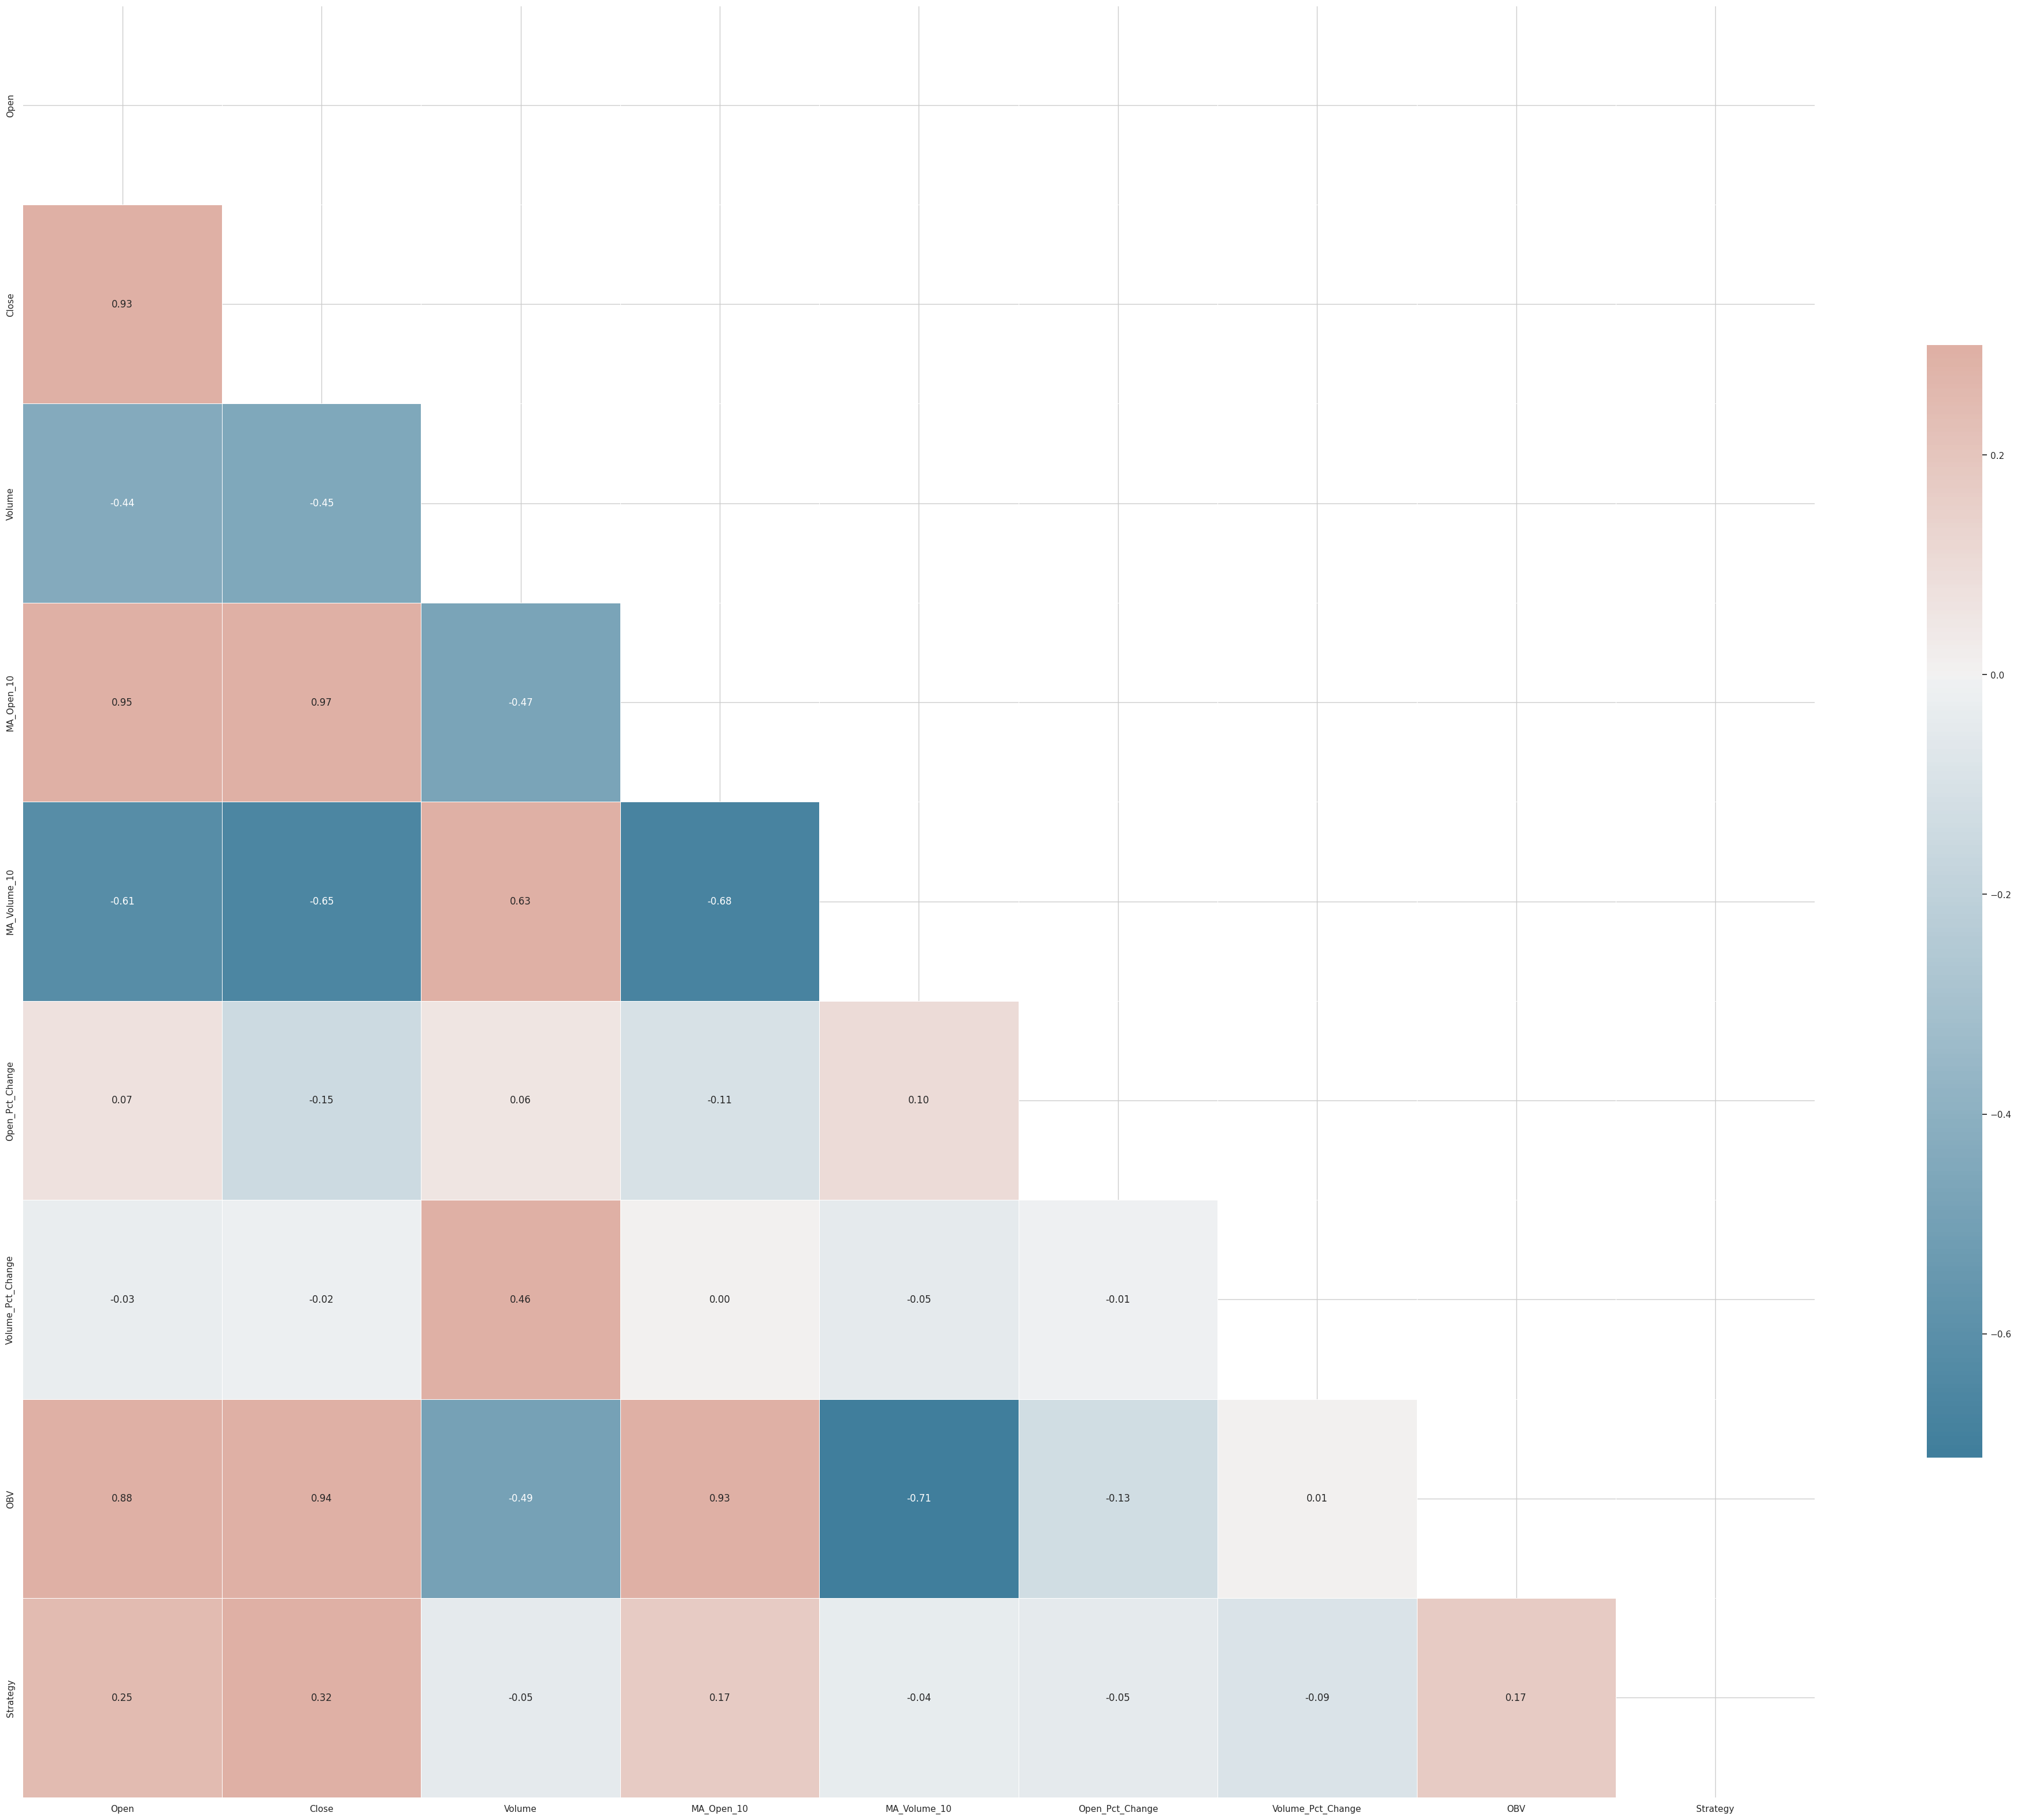

In [211]:
df_train = X_train.copy()
df_train['Strategy'] = y_train_encoded
df_train.head()

f, ax = plt.subplots(figsize=(50, 50))

mask = np.triu(np.ones_like(df_train.corr(method='pearson'), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_train.corr(method='pearson'), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, fmt=".2f")

- Pearsons correlation only takes numerical values to correlate, hence we had to label encode it
- There is a python module called Dython which allows us to correlate categorical columns as well.
- We will be using this for our analysis


In [ ]:
!pip install dython

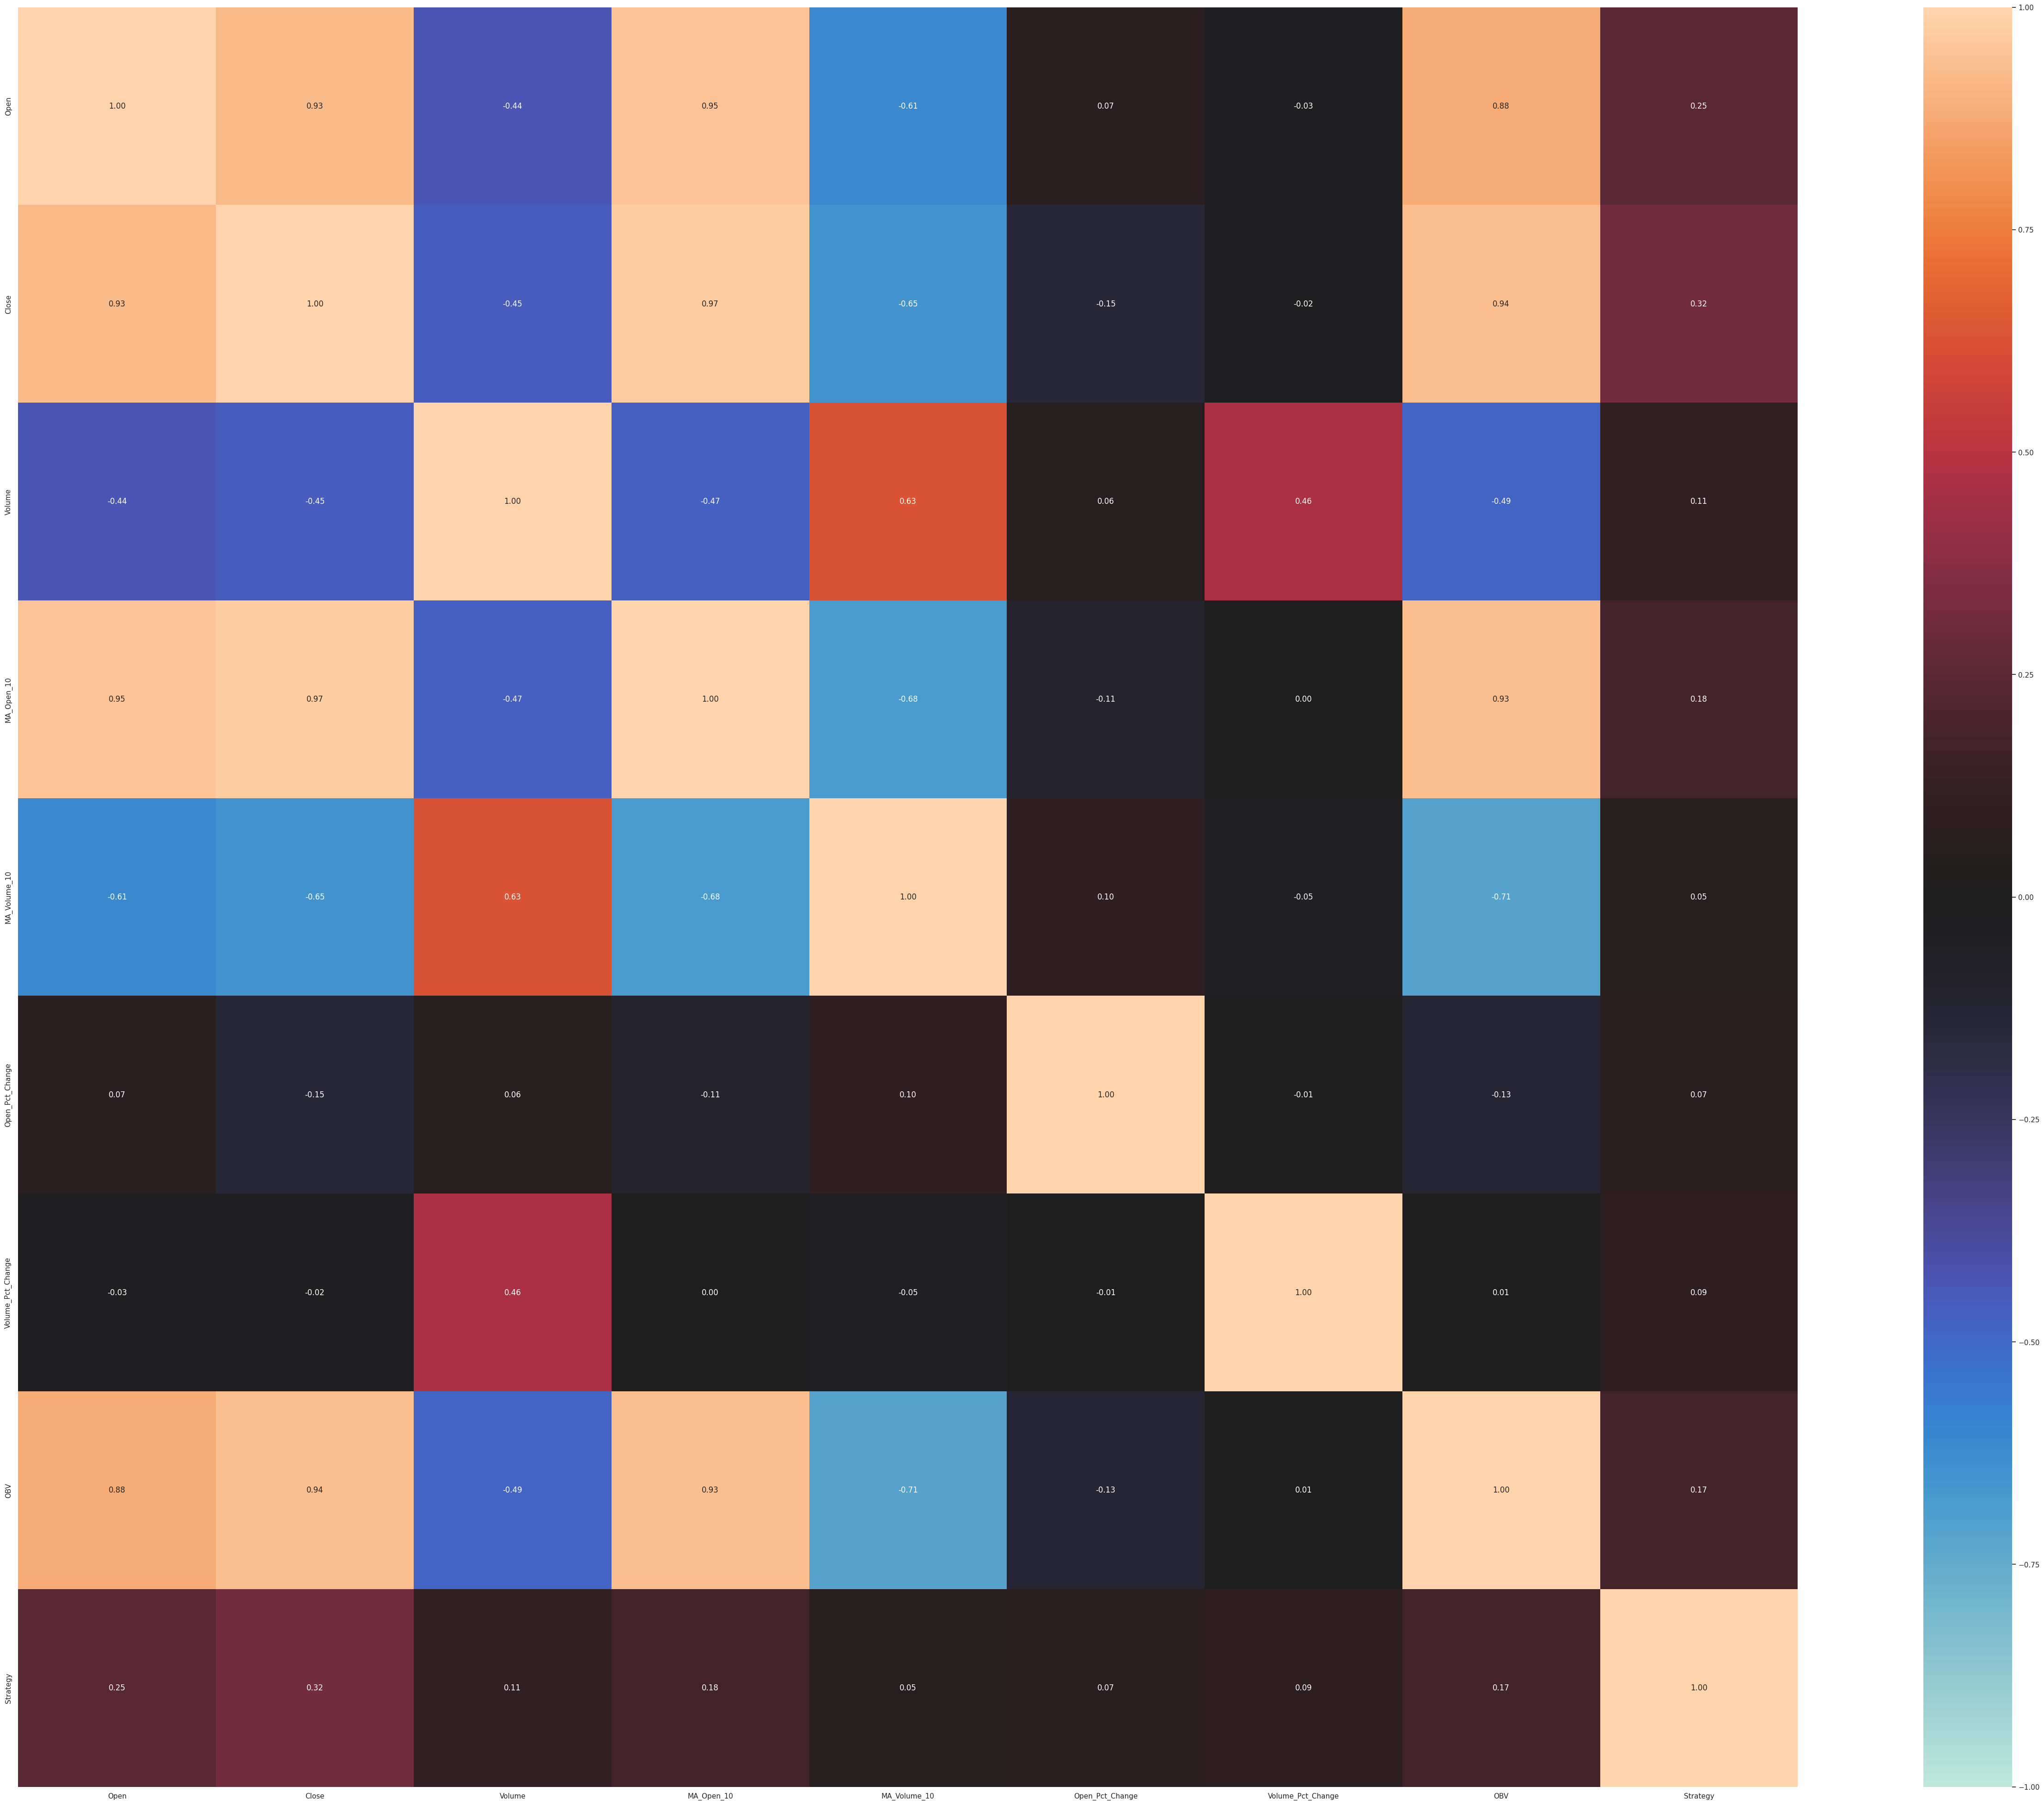

In [212]:
from dython.nominal import associations

df_train = X_train.copy()
df_train['Strategy'] = y_train['Strategy'].values

complete_correlation = associations(df_train, filename= 'complete_correlation.png', figsize=(70,50))

In [213]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.head()

Open     Close    Volume  MA_Open_10  MA_Volume_10  \
Open          1.000000  0.926692 -0.436776    0.945458     -0.614424   
Close         0.926692  1.000000 -0.454411    0.974179     -0.654391   
Volume       -0.436776 -0.454411  1.000000   -0.473500      0.631521   
MA_Open_10    0.945458  0.974179 -0.473500    1.000000     -0.676919   
MA_Volume_10 -0.614424 -0.654391  0.631521   -0.676919      1.000000   

              Open_Pct_Change  Volume_Pct_Change       OBV  Strategy  
Open                 0.074318          -0.030499  0.875180  0.247661  
Close               -0.147968          -0.018739  0.935782  0.318073  
Volume               0.055402           0.461200 -0.488757  0.106786  
MA_Open_10          -0.107131           0.003462  0.931215  0.177826  
MA_Volume_10         0.099373          -0.051425 -0.712747  0.051667

- We will take all features we have made. We have made many models and the features above which are uncommented are the ones which gave the best results
- Hence the high threshold is 1 and low is 0

In [214]:
features = set()
low_threshold = 0.0
high_threshold = 1
for col in df_complete_corr.columns:
    if abs(df_complete_corr[col]['Strategy']) <= high_threshold and abs(df_complete_corr[col]['Strategy']) >= low_threshold:
        features.add(col)
print(f"{len(features)} / {len(df_complete_corr.columns)} Features available over threshold\n")
print(features)

9 / 9 Features available over threshold

{'MA_Volume_10', 'Close', 'Volume_Pct_Change', 'MA_Open_10', 'Open', 'Open_Pct_Change', 'Volume', 'Strategy', 'OBV'}


In [215]:
X_train = X_train[[x for x in list(features) if x != 'Strategy']]
X_test = X_test[[x for x in list(features) if x != 'Strategy']]
X_test.head()

MA_Volume_10      Close  Volume_Pct_Change  MA_Open_10       Open  \
Date                                                                            
2017-03-13   160713520.0  76.127955          -0.061915   68.276135  74.684910   
2020-07-20   178418910.0  79.606191          -0.197254   77.967043  76.742992   
2016-06-13   214598580.0  49.532482           0.075298   45.122976  41.439967   
2018-12-17   138030170.0  88.241340          -0.109608   86.900042  91.868388   
2018-04-30   133717180.0  92.607534           0.131440   91.597775  96.742411   

            Open_Pct_Change     Volume         OBV  
Date                                                
2017-03-13         0.039990  174248600   434558300  
2020-07-20         0.000107  105776600  1167708700  
2016-06-13         0.029067  188346200 -1163099400  
2018-12-17         0.095092  142899700  1972323700  
2018-04-30         0.047251  110174000  1965238000

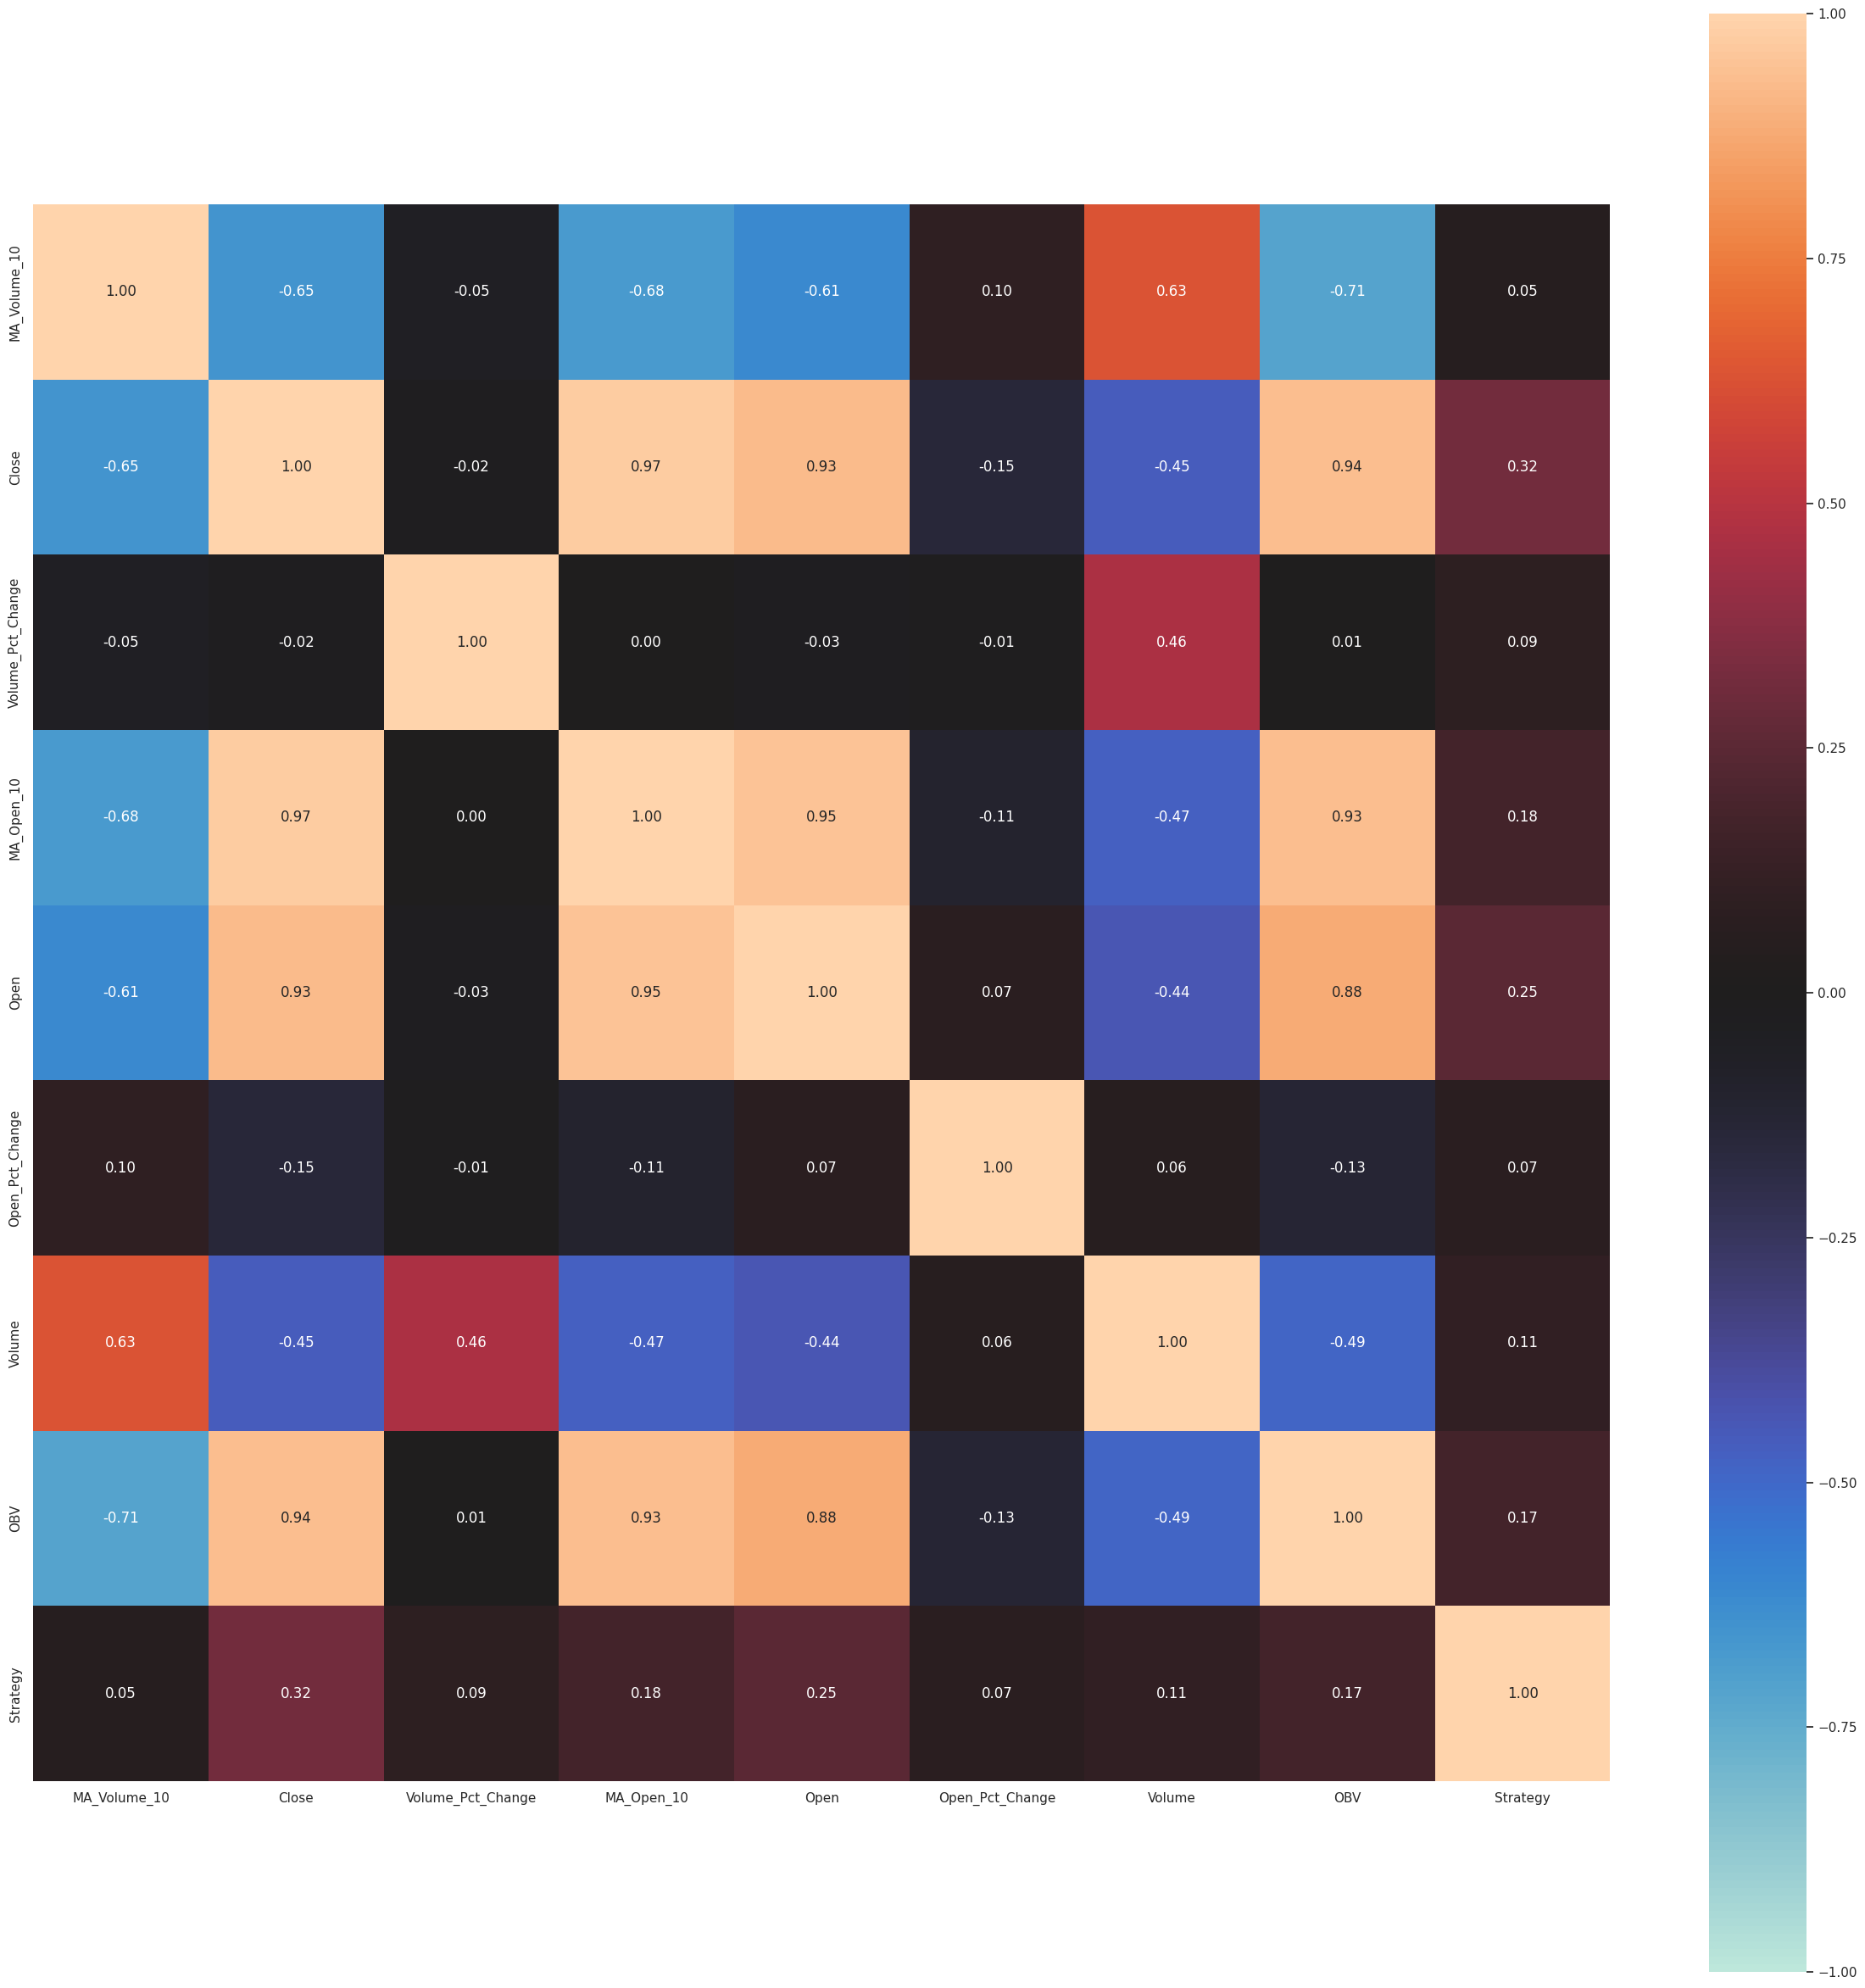

In [216]:
df_train = X_train.copy()
df_train['Strategy'] = y_train['Strategy'].values

complete_correlation = associations(df_train, filename= 'complete_correlation.png', figsize=(30,30))

### Standardizing values

In [217]:
X_train.head()

MA_Volume_10      Close  Volume_Pct_Change  MA_Open_10       Open  \
Date                                                                            
2016-05-23   216847050.0  54.315850           0.066122   47.508228  42.680313   
2016-08-29   177558840.0  52.726115           0.038258   47.086187  49.476763   
2021-01-04   179613230.0  80.740975          -0.026677   78.982029  80.490487   
2017-10-30   174407200.0  97.734784          -0.354896   94.818258  83.176688   
2016-09-19   172125200.0  55.717026           0.074721   49.801301  53.519055   

            Open_Pct_Change     Volume         OBV  
Date                                                
2016-05-23        -0.002579  201817100  -513360600  
2016-08-29         0.009096  180114000 -1246189100  
2021-01-04        -0.009694  197906200  1049679100  
2017-10-30        -0.122271   98044400  1218499700  
2016-09-19        -0.027725  173135900  -998502800

In [218]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("Standardization Done!\n")
X_train[:5]

Standardization Done!



array([[ 6.42738913e-01, -1.87025134e+00,  3.76822253e-03,
        -1.84952691e+00, -2.17817281e+00, -1.01387741e-01,
         3.22429639e-01, -1.51280687e+00],
       [-1.17868083e-01, -1.98553702e+00, -6.25392728e-02,
        -1.87644562e+00, -1.74697226e+00,  1.19886926e-01,
        -1.57711442e-03, -2.24884469e+00],
       [-7.80957589e-02,  4.60669377e-02, -2.17064308e-01,
         1.57939901e-01,  2.20692613e-01, -2.36224138e-01,
         2.64043601e-01,  5.70779522e-02],
       [-1.78882810e-01,  1.27843755e+00, -9.98124211e-01,
         1.16800866e+00,  3.91118602e-01, -2.36980930e+00,
        -1.22679861e+00,  2.26637879e-01],
       [-2.23061590e-01, -1.76863976e+00,  2.42322850e-02,
        -1.70326981e+00, -1.49050914e+00, -5.77955783e-01,
        -1.05753547e-01, -2.00007368e+00]])

In [219]:
X_test[:5]

array([[-0.44398801, -0.28846371, -0.30092088, -0.5249051 , -0.14764207,
         0.70539467, -0.08914199, -0.56073668],
       [-0.10121741, -0.03622622, -0.62298498,  0.09320191, -0.01706708,
        -0.050481  , -1.11136418,  0.17562445],
       [ 0.59920926, -2.21713544,  0.02560457, -2.00166342, -2.25686654,
         0.49839307,  0.12132184, -2.16539111],
       [-0.88313031,  0.58998441, -0.41441554,  0.66296777,  0.94256326,
         1.74971012, -0.55715141,  0.98376315],
       [-0.96662839,  0.90661553,  0.15920586,  0.96259934,  1.25179547,
         0.84300929, -1.04571516,  0.97664642]])

- We have made the split and now we will be going ahead with the model building

### Model Building
- We will start off with the classification model making
- We will use a block of code which will run multiple models and give the model with the best accuracy


In [ ]:
!pip install catboost -q

In [220]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.naive_bayes import GaussianNB

classifiers = [
    SVC(random_state=42, C = 4),
    SVC(random_state=42, C = 0.01),
    SVC(random_state=42, kernel = 'rbf', C = 4),
    SVC(random_state=42, kernel = 'rbf', C = 0.01),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    BaggingClassifier(random_state=42),
    ExtraTreesClassifier(random_state = 42),
    RandomForestClassifier(random_state = 42),
    ExtraTreesClassifier(random_state = 42, max_features='auto', min_samples_split=10, n_estimators=500),
    HistGradientBoostingClassifier(random_state=42),
    xgb.XGBClassifier(random_state = 42),
    DecisionTreeClassifier(random_state = 42),
    SGDClassifier(random_state = 42),
    MLPClassifier(random_state = 42),
    lgb.LGBMClassifier(random_state = 42),
    lgb.DaskLGBMClassifier(random_state = 42),
    LogisticRegression(random_state = 42),
    CatBoostClassifier(random_state=42,verbose = False)
]

MODEL = classifiers

name = []
models = []
accuracy_list = []
predictions = []

for i , classifier in enumerate(MODEL):
    print(f"[{i}]Executing - {type(classifier).__name__}",end=' ')
    try:
        classifier.fit(X_train, y_train_encoded)
    except Exception as e:
        print(f" : Error on [{i}] - {type(classifier).__name__}")
        print(e)
        continue

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    print("1 - Accuracy: ", 1 - accuracy)

    accuracy_list.append(accuracy)
    predictions.append(y_pred)
    name.append(type(classifier).__name__)
    models.append(classifier)

df_score = pd.DataFrame(list(zip(name, accuracy_list, models,predictions)),columns=['name','accuracy','model','prediction'])
df_score.set_index('name',inplace=True)
df_score.sort_values(by=['accuracy'], ascending= False, inplace=True)
df_score

[0]Executing - SVC 1 - Accuracy:  0.4
[1]Executing - SVC 1 - Accuracy:  0.43333333333333335
[2]Executing - SVC 1 - Accuracy:  0.4
[3]Executing - SVC 1 - Accuracy:  0.43333333333333335
[4]Executing - KNeighborsClassifier 1 - Accuracy:  0.6
[5]Executing - GradientBoostingClassifier 1 - Accuracy:  0.19999999999999996
[6]Executing - AdaBoostClassifier 1 - Accuracy:  0.33333333333333337
[7]Executing - GaussianNB 1 - Accuracy:  0.7
[8]Executing - BaggingClassifier 1 - Accuracy:  0.30000000000000004
[9]Executing - ExtraTreesClassifier 1 - Accuracy:  0.4
[10]Executing - RandomForestClassifier 1 - Accuracy:  0.30000000000000004
[11]Executing - ExtraTreesClassifier 1 - Accuracy:  0.4
[12]Executing - HistGradientBoostingClassifier 1 - Accuracy:  0.23333333333333328
[13]Executing - XGBClassifier 1 - Accuracy:  0.19999999999999996
[14]Executing - DecisionTreeClassifier 1 - Accuracy:  0.30000000000000004
[15]Executing - SGDClassifier 1 - Accuracy:  0.33333333333333337
[16]Executing - MLPClassifier 1

accuracy  \
name                                       
XGBClassifier                   0.800000   
GradientBoostingClassifier      0.800000   
CatBoostClassifier              0.766667   
HistGradientBoostingClassifier  0.766667   
BaggingClassifier               0.700000   
LGBMClassifier                  0.700000   
DecisionTreeClassifier          0.700000   
RandomForestClassifier          0.700000   
AdaBoostClassifier              0.666667   
SGDClassifier                   0.666667   
LogisticRegression              0.633333   
ExtraTreesClassifier            0.600000   
ExtraTreesClassifier            0.600000   
SVC                             0.600000   
SVC                             0.600000   
SVC                             0.566667   
SVC                             0.566667   
MLPClassifier                   0.566667   
KNeighborsClassifier            0.400000   
GaussianNB                      0.300000   

                                                                            model  \
name                                                                                
XGBClassifier                   XGBClassifier(base_score=None, booster=None, c...   
GradientBoostingClassifier      ([DecisionTreeRegressor(criterion='friedman_ms...   
CatBoostClassifier              <catboost.core.CatBoostClassifier object at 0x...   
HistGradientBoostingClassifier    HistGradientBoostingClassifier(random_state=42)   
BaggingClassifier               (DecisionTreeClassifier(random_state=195292617...   
LGBMClassifier                                    LGBMClassifier(random_state=42)   
DecisionTreeClassifier                    DecisionTreeClassifier(random_state=42)   
RandomForestClassifier          (DecisionTreeClassifier(max_features='sqrt', r...   
AdaBoostClassifier              (DecisionTreeClassifier(max_depth=1, random_st...   
SGDClassifier                                      SGDClassifier(random_state=42)   
LogisticRegression                            LogisticRegression(random_state=42)   
ExtraTreesClassifier            (ExtraTreeClassifier(random_state=1608637542),...   
ExtraTreesClassifier            (ExtraTreeClassifier(min_samples_split=10, ran...   
SVC                                                     SVC(C=4, random_state=42)   
SVC                                                     SVC(C=4, random_state=42)   
SVC                                                  SVC(C=0.01, random_state=42)   
SVC                                                  SVC(C=0.01, random_state=42)   
MLPClassifier                                      MLPClassifier(random_state=42)   
KNeighborsClassifier                                       KNeighborsClassifier()   
GaussianNB                                                           GaussianNB()   

                                                                       prediction  
name                                                                               
XGBClassifier                   [0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, ...  
GradientBoostingClassifier      [2, 1, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, ...  
CatBoostClassifier              [[0], [1], [0], [1], [1], [1], [1], [1], [1], ...  
HistGradientBoostingClassifier  [1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, ...  
BaggingClassifier               [0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, ...  
LGBMClassifier                  [2, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 0, ...  
DecisionTreeClassifier          [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, ...  
RandomForestClassifier          [0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 0, ...  
AdaBoostClassifier              [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, ...  
SGDClassifier                   [2, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, ...  
LogisticRegression              [2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, ...  
ExtraTreesClassifier            [0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 0, ...  
ExtraTreesClassi

In [221]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, make_scorer

gb_regressor = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

scoring = make_scorer(accuracy_score)

grid_search = GridSearchCV(estimator = gb_regressor, param_grid = param_grid, scoring = scoring, cv = 3, n_jobs = -1, verbose = 3)
grid_search.fit(X_train, y_train_encoded)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

best_gb_regressor = grid_search.best_estimator_

y_pred = best_gb_regressor.predict(X_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.598 total time=   0.5s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.598 total time=   0.5s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.586 total time=   0.5s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.621 total time=   1.3s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.575 total time=   1.4s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.609 total time=   1.6s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.667 total time=   2.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.552 total time=   2.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.632 total time=   2.3s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.63

- We can see that the classifier with the best accuracy is XGBoost and GradientBoostingClassifier
- GradientBoostingClassifier did not give any better results with the grid search
- We will now predict the Strategy column using this classifier
- We will be training it on the entire dataset

### Using the best classifier to predict for the test set

In [222]:
subX = X.copy()
subX = subX[[x for x in list(features) if x != 'Strategy']]
print(subX.shape)

sc = StandardScaler()
subX = sc.fit_transform(subX)

subX[:5]

(291, 8)


array([[ 3.37309163, -1.73521714, -0.11224491, -1.56269274, -1.87569685,
        -0.95352012,  1.65801299, -1.86791678],
       [ 3.23325837, -1.84071385, -0.69701582, -1.70695129, -2.08947916,
        -1.43986359,  0.65134718, -2.09474144],
       [ 3.32170115, -1.74458443,  0.32705779, -1.78792269, -1.59712092,
         3.40237878,  1.35899727, -1.8192179 ],
       [ 3.47036511, -1.88663349,  0.28741547, -1.71846751, -1.15179461,
         2.6017265 ,  2.14904358, -2.14911065],
       [ 3.56394545, -2.05735009, -0.55087781, -1.67304301, -0.94219259,
         1.04895672,  1.33441309, -2.42294236]])

In [223]:
df.head()

Open      Close     Volume Strategy
Date                                                
2015-06-01  66.208486  75.609978  298506300     Hold
2015-06-08  64.116235  74.443331  227974800     Hold
2015-06-15  47.701942  71.140831  250670900      Buy
2015-06-22  54.754816  72.881344  223614300     Hold
2015-06-29  48.031899  66.284718  406814900      Buy

In [227]:
test_df = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')

test_df = test_df.drop('id',axis = 1)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.index = test_df.Date
test_df = test_df.drop(['Date'],axis = 1)

test_df['Close'] = df_submission['Close'].values

full_timeline = pd.concat([df,test_df])
full_timeline = full_timeline.drop('Strategy', axis = 1)

full_timeline['MA_Open_10'] = full_timeline['Open'].rolling(window=10).mean()
full_timeline['MA_Volume_10'] = full_timeline['Volume'].rolling(window=10).mean()

full_timeline['MA_Open_10'] = full_timeline['MA_Open_10'].fillna(method = 'bfill')
full_timeline['MA_Volume_10'] = full_timeline['MA_Volume_10'].fillna(method = 'bfill')

full_timeline['Open_Pct_Change'] = full_timeline['Open'].pct_change()
full_timeline['Volume_Pct_Change'] = full_timeline['Volume'].pct_change()

full_timeline['Open_Pct_Change'] = full_timeline['Open_Pct_Change'].fillna(method = 'bfill')
full_timeline['Volume_Pct_Change'] = full_timeline['Volume_Pct_Change'].fillna(method = 'bfill')

full_timeline['Lag1_Open'] = full_timeline['Open'].shift(1)
full_timeline['Lag1_Open'] = full_timeline['Lag1_Open'].fillna(method = 'bfill')

def calculate_obv(df):
    obv = [0]
    df_obv = df.reset_index()
    for i in range(1, len(df_obv)):
        if df_obv.loc[i, 'Close'] > df_obv.loc[i - 1, 'Close']:
            obv.append(obv[-1] + df_obv.loc[i, 'Volume'])
        elif df_obv.loc[i, 'Close'] < df_obv.loc[i - 1, 'Close']:
            obv.append(obv[-1] - df_obv.loc[i, 'Volume'])
        else:
            obv.append(obv[-1])
    df_obv['OBV'] = obv
    return df_obv

full_timeline = calculate_obv(full_timeline)

full_timeline['Date'] = pd.to_datetime(full_timeline['Date'])
full_timeline.index = full_timeline.Date
full_timeline = full_timeline.drop(['Date'],axis = 1)

print(full_timeline.isna().sum())
test_df = full_timeline[300:]

print(test_df.shape)

test_df.head()

# test_df['Lag1_Open'] = test_df['Open'].shift(1)
# test_df['Lag2_Open'] = test_df['Open'].shift(2)
# test_df['Lag3_Open'] = test_df['Open'].shift(3)
# test_df['Lag4_Open'] = test_df['Open'].shift(4)
# test_df['Lag5_Open'] = test_df['Open'].shift(5)

# test_df['Lag1_Close'] = test_df['Close'].shift(1)
# test_df['Lag2_Close'] = test_df['Close'].shift(2)
# test_df['Lag3_Close'] = test_df['Close'].shift(3)
# test_df['Lag4_Close'] = test_df['Close'].shift(4)
# test_df['Lag5_Close'] = test_df['Close'].shift(5)

# test_df['Lag1_Volume'] = test_df['Volume'].shift(1)
# test_df['Lag2_Volume'] = test_df['Volume'].shift(2)
# test_df['Lag3_Volume'] = test_df['Volume'].shift(3)
# test_df['Lag4_Volume'] = test_df['Volume'].shift(4)
# test_df['Lag5_Volume'] = test_df['Volume'].shift(5)

# test_df['Close-Open'] = test_df['Close']-test_df['Open']
# test_df['COLag1'] = test_df['Close-Open'].shift(1)
# test_df['COLag2'] = test_df['Close-Open'].shift(2)
# test_df['COLag3'] = test_df['Close-Open'].shift(3)

# test_df['COAhead1'] = test_df['Close-Open'].shift(-1)
# test_df['COAhead2'] = test_df['Close-Open'].shift(-2)
# test_df['COAhead3'] = test_df['Close-Open'].shift(-3)

# test_df['Open_Pct_Change'] = test_df['Open'].pct_change(periods = 3)
# test_df['Close_Pct_Change'] = test_df['Close'].pct_change(periods = 3)
# test_df['Volume_Pct_Change'] = test_df['Volume'].pct_change(periods = 3)


# result = seasonal_decompose(test_df['Open'], model='additive', period=12)
# test_df['Trend_Open'] = result.trend
# test_df['Seasonal_Open'] = result.seasonal
# test_df['Residual_Open'] = result.resid

# result = seasonal_decompose(test_df['Volume'], model='additive', period=12)
# test_df['Trend_Volume'] = result.trend
# test_df['Seasonal_Volume'] = result.seasonal
# test_df['Residual_Volume'] = result.resid

# test_df['Residual_Open'] = test_df['Open'] - test_df['Trend_Open'] - test_df['Seasonal_Open']
# test_df['Residual_Volume'] = test_df['Volume'] - test_df['Trend_Volume'] - test_df['Seasonal_Volume']

# test_df['Ahead1_Open'] = test_df['Open'].shift(-1) #
# test_df['Ahead2_Open'] = test_df['Open'].shift(-2) #
# test_df['Ahead3_Open'] = test_df['Open'].shift(-3) #

# test_df['Ahead1_Close'] = test_df['Close'].shift(-1) #
# test_df['Ahead2_Close'] = test_df['Close'].shift(-2) #
# test_df['Ahead3_Close'] = test_df['Close'].shift(-3) #

# # print(test_df.head())

# test_df['MA_Open_3'] = test_df['Open'].rolling(window=3).mean()

# test_df['MA_Open_5'] = test_df['Open'].rolling(window=5).mean()
# test_df['MA_Volume_5'] = test_df['Volume'].rolling(window=5).mean()

# test_df['MA_Open_10'] = test_df['Open'].rolling(window=10).mean()
# test_df['MA_Close_10'] = test_df['Close'].rolling(window=10).mean()
# test_df['MA_Volume_10'] = test_df['Volume'].rolling(window=10).mean()

# test_df['COAhead1'] = test_df['COAhead1'].fillna(method='ffill')
# test_df['COAhead2'] = test_df['COAhead2'].fillna(method='ffill')
# test_df['COAhead3'] = test_df['COAhead3'].fillna(method='ffill')

# test_df['Ahead1_Open'] = test_df['Ahead1_Open'].fillna(method='ffill')
# test_df['Ahead2_Open'] = test_df['Ahead2_Open'].fillna(method='ffill')
# test_df['Ahead3_Open'] = test_df['Ahead3_Open'].fillna(method='ffill')

# test_df['Ahead1_Close'] = test_df['Ahead1_Close'].fillna(method='ffill')
# test_df['Ahead2_Close'] = test_df['Ahead2_Close'].fillna(method='ffill')
# test_df['Ahead3_Close'] = test_df['Ahead3_Close'].fillna(method='ffill')

# test_df['Lag1_Open'] = test_df['Lag1_Open'].fillna(method = 'bfill')
# test_df['Lag2_Open'] = test_df['Lag2_Open'].fillna(method = 'bfill')
# test_df['Lag3_Open'] = test_df['Lag3_Open'].fillna(method = 'bfill')
# test_df['Lag4_Open'] = test_df['Lag4_Open'].fillna(method = 'bfill')
# test_df['Lag5_Open'] = test_df['Lag5_Open'].fillna(method = 'bfill')

# test_df['Lag1_Close'] = test_df['Lag1_Close'].fillna(method = 'bfill')
# test_df['Lag2_Close'] = test_df['Lag2_Close'].fillna(method = 'bfill')
# test_df['Lag3_Close'] = test_df['Lag3_Close'].fillna(method = 'bfill')
# test_df['Lag4_Close'] = test_df['Lag4_Close'].fillna(method = 'bfill')
# test_df['Lag5_Close'] = test_df['Lag5_Close'].fillna(method = 'bfill')

# test_df['COLag1'] = test_df['COLag1'].fillna(method = 'bfill')
# test_df['COLag2'] = test_df['COLag2'].fillna(method = 'bfill')
# test_df['COLag3'] = test_df['COLag3'].fillna(method = 'bfill')

# test_df['Lag1_Volume'] = test_df['Lag1_Volume'].fillna(method = 'bfill')
# test_df['Lag2_Volume'] = test_df['Lag2_Volume'].fillna(method = 'bfill')
# test_df['Lag3_Volume'] = test_df['Lag3_Volume'].fillna(method = 'bfill')
# test_df['Lag4_Volume'] = test_df['Lag4_Volume'].fillna(method = 'bfill')
# test_df['Lag5_Volume'] = test_df['Lag5_Volume'].fillna(method = 'bfill')

# test_df['Open_Pct_Change'] = test_df['Open_Pct_Change'].fillna(method = 'bfill')
# test_df['Close_Pct_Change'] = test_df['Close_Pct_Change'].fillna(method = 'bfill')
# test_df['Volume_Pct_Change'] = test_df['Volume_Pct_Change'].fillna(method = 'bfill')

# test_df['MA_Open_3'] = test_df['MA_Open_3'].fillna(method = 'bfill')

# test_df['MA_Open_5'] = test_df['MA_Open_5'].fillna(method = 'bfill')
# test_df['MA_Volume_5'] = test_df['MA_Volume_5'].fillna(method = 'bfill')

# test_df['MA_Open_10'] = test_df['MA_Open_10'].fillna(method = 'bfill')
# test_df['MA_Close_10'] = test_df['MA_Open_10'].fillna(method = 'bfill')
# test_df['MA_Volume_10'] = test_df['MA_Volume_10'].fillna(method = 'bfill')

# test_df['Trend_Open'] = test_df['Trend_Open'].fillna(method='ffill')
# test_df['Trend_Open'] = test_df['Trend_Open'].fillna(method='bfill')

# test_df['Trend_Volume'] = test_df['Trend_Volume'].fillna(method='ffill')
# test_df['Trend_Volume'] = test_df['Trend_Volume'].fillna(method='bfill')

# test_df['Residual_Open'] = test_df['Residual_Open'].fillna(method='ffill')
# test_df['Residual_Open'] = test_df['Residual_Open'].fillna(method='bfill')

# test_df['Residual_Volume'] = test_df['Residual_Volume'].fillna(method='ffill')
# test_df['Residual_Volume'] = test_df['Residual_Volume'].fillna(method='bfill')


for col in test_df.columns:
    if test_df[col].isna().sum() > 0:
        print(f"{col} : {test_df[col].isna().sum()}")


print(f"Shape Before: {test_df.shape}")
test_df_filtered = test_df[[x for x in list(features) if x!= 'Strategy']]
print(f"Shape After: {test_df_filtered.shape}")

test_df_scaled = sc.transform(test_df_filtered)

test_df_filtered.head()

Open                 0
Close                0
Volume               0
MA_Open_10           0
MA_Volume_10         0
Open_Pct_Change      0
Volume_Pct_Change    0
Lag1_Open            0
OBV                  0
dtype: int64
(100, 9)
Shape Before: (100, 9)
Shape After: (100, 8)


MA_Volume_10      Close  Volume_Pct_Change  MA_Open_10       Open  \
Date                                                                            
2021-03-01   182822850.0  77.096016          -0.381650   75.901181  72.708331   
2021-03-08   183899370.0  77.225853           0.039816   75.104431  73.310886   
2021-03-15   179268920.0  77.007149          -0.291897   74.116394  70.610119   
2021-03-22   183450800.0  76.933724           0.279554   73.157974  70.256017   
2021-03-29   192749840.0  76.636064           0.135352   71.917433  68.258324   

            Open_Pct_Change     Volume        OBV  
Date                                               
2021-03-01         0.044381  205897600  282326200  
2021-03-08         0.008287  214095600  496421800  
2021-03-15        -0.036840  151601700  344820100  
2021-03-22        -0.005015  193982500  150837600  
2021-03-29        -0.028434  220238400  -69400800

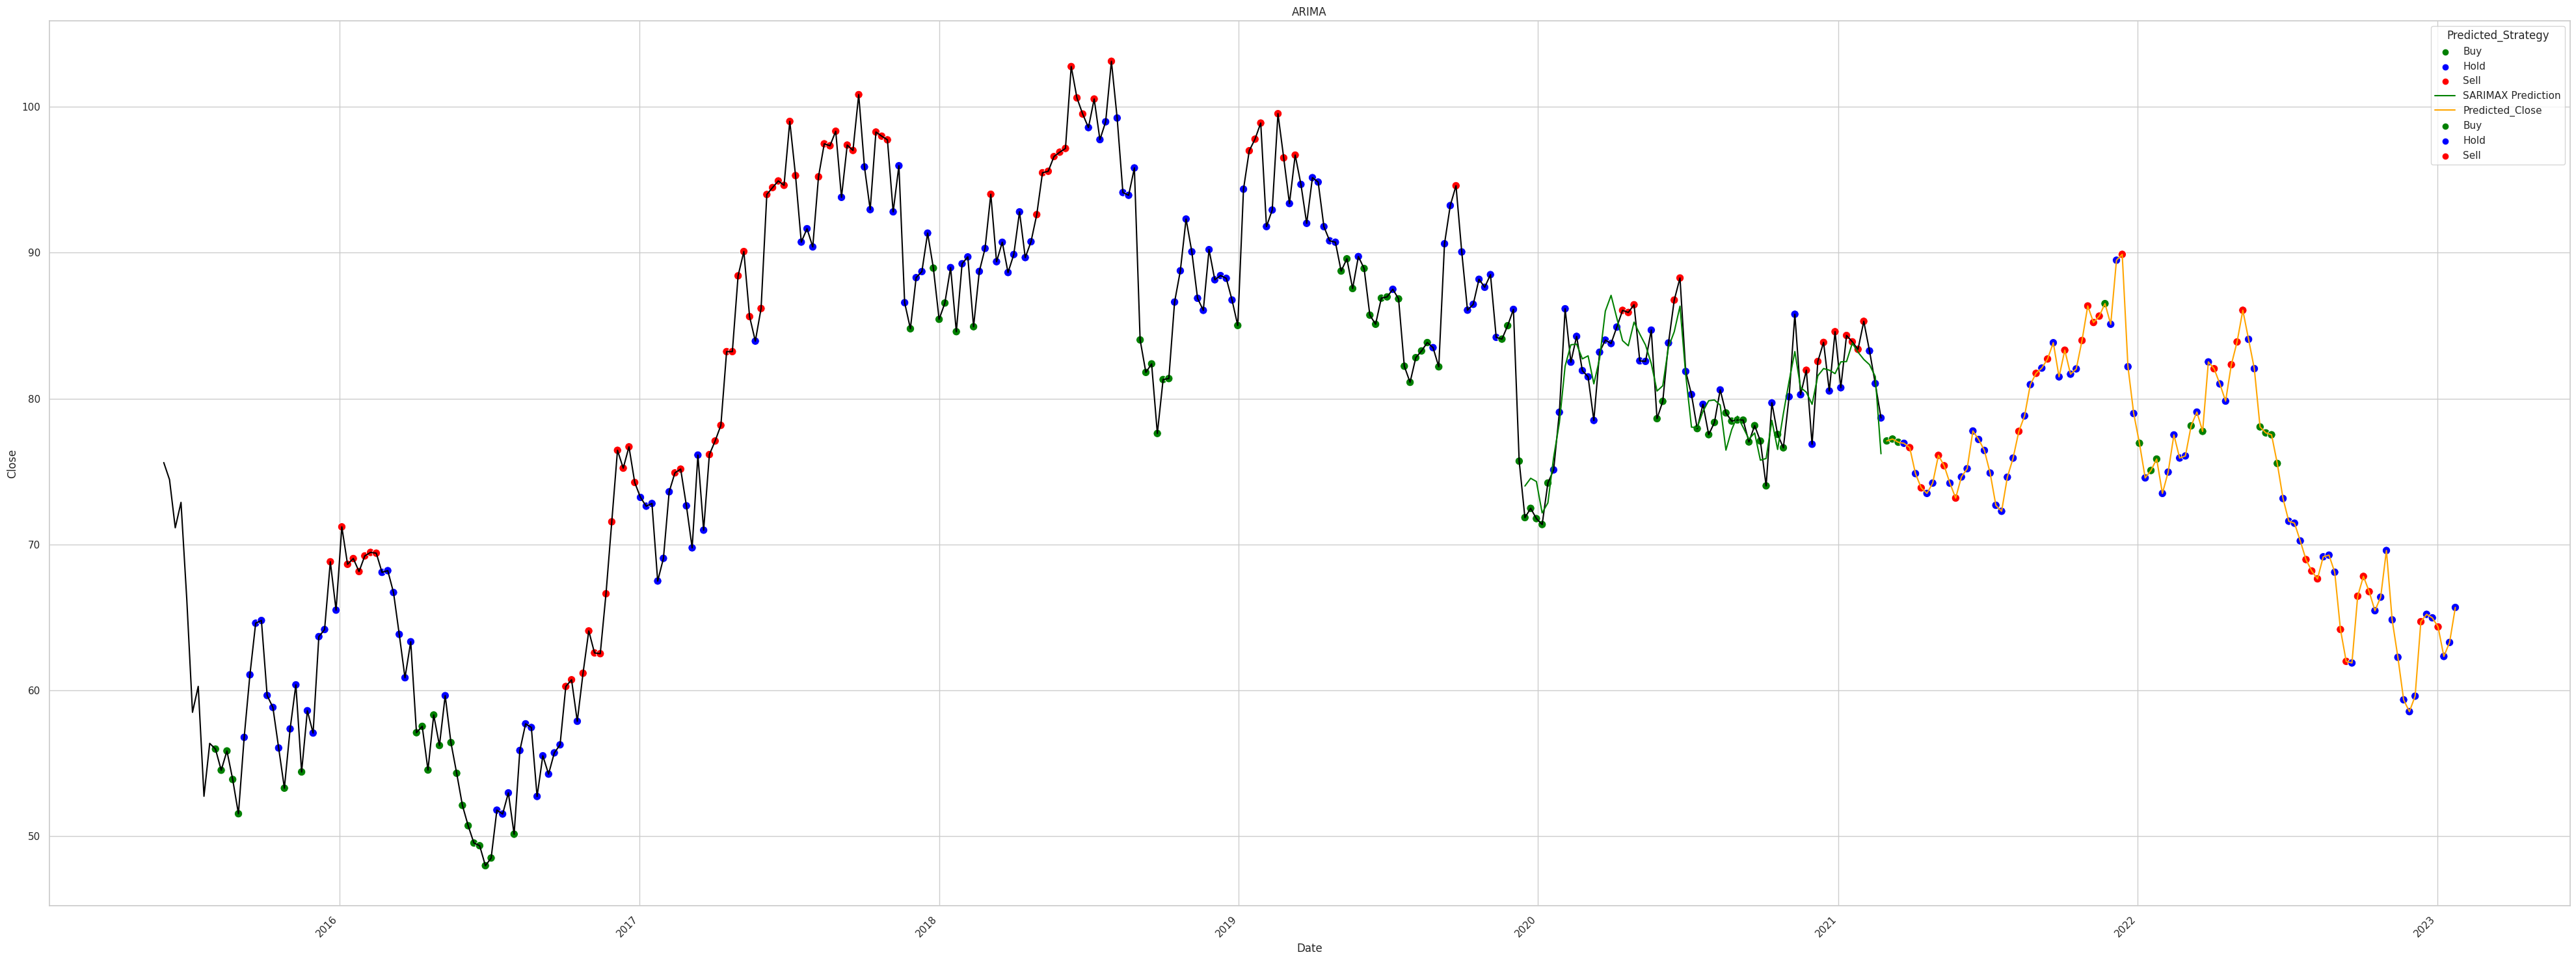

In [229]:
model = GradientBoostingClassifier(random_state=42, learning_rate = 0.1, max_depth = 3, n_estimators = 500)
# {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
# {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
y_encoded = sgy_encoder.transform(y)
model.fit(subX, y_encoded)

y_pred = model.predict(test_df_scaled)
# y_pred = classifiers[5].predict(test_df_scaled)

# CATBOOST: y_pred.reshape(1,len(y_pred))[0]

test_df['Predicted_Strategy'] = sgy_encoder.inverse_transform(y_pred)
test_df['Predicted_Close'] = df_submission['Close'].values
# test_df.head()

plt.figure(figsize=(50,20))
plt.plot(df_fe['Close'], color = "black")

sub_plot_df = df_fe.copy()
sub_plot_df['Strategy'] = y
sns.scatterplot(data = sub_plot_df,x='Date', y='Close', hue='Strategy', palette={'Buy':'green','Hold':'blue','Sell':'red'}, s=80) # Hold, Buy, Sell

# plt.plot(y_test, color = "red")
plt.plot(test['predicted_Sarimax'] , color='green', label = 'SARIMAX Prediction')
test_df['Predicted_Close'].plot(color = 'orange')
sns.scatterplot(data = test_df,x='Date', y='Close', hue='Predicted_Strategy', palette={'Buy':'green','Hold':'blue','Sell':'red'}, s=80) # Sell Hold Buy

plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("ARIMA")
plt.show()

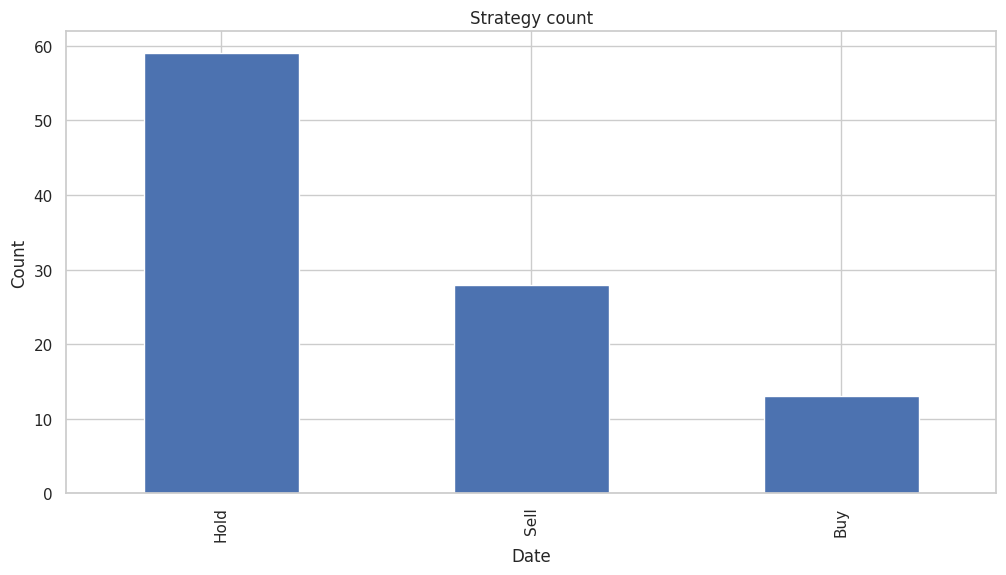

In [230]:
plt.figure(figsize=(12, 6))
test_df['Predicted_Strategy'].value_counts().plot(kind='bar')
plt.title('Strategy count')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

In [334]:
df_submission['Strategy'] = test_df['Predicted_Strategy'].values
df_submission.head()

id        Date      Close Strategy
0   0  2021-03-01  77.084318      Buy
1   1  2021-03-08  77.219020      Buy
2   2  2021-03-15  77.012890      Buy
3   3  2021-03-22  76.954508     Hold
4   4  2021-03-29  76.654310     Sell

In [335]:
df_submission.to_csv('BR_2_Overfitted_577_578_594_26.csv', index = False)

## Predicting with XGBoost using RSI, MACD and Bollinger Bands

In [231]:
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")
train = train.drop(['id'],axis = 1)
train['Date'] = pd.to_datetime(train['Date'])
train.index = train.Date
train = train.drop(['Date'],axis = 1)
train.head()

Open      Close     Volume Strategy
Date                                                
2015-06-01  66.208486  75.609978  298506300     Hold
2015-06-08  64.116235  74.443331  227974800     Hold
2015-06-15  47.701942  71.140831  250670900      Buy
2015-06-22  54.754816  72.881344  223614300     Hold
2015-06-29  48.031899  66.284718  406814900      Buy

In [232]:
test["Close"] = df_submission['Close'].values

test = test.drop(['id'],axis = 1)
test['Date'] = pd.to_datetime(test['Date'])
test.index = test.Date
test = test.drop(['Date'],axis = 1)

test.head()

Open     Volume      Close
Date                                       
2021-03-01  72.708331  205897600  77.096016
2021-03-08  73.310886  214095600  77.225853
2021-03-15  70.610119  151601700  77.007149
2021-03-22  70.256017  193982500  76.933724
2021-03-29  68.258324  220238400  76.636064

In [233]:
df = pd.concat([train, test], axis=0)
df.head()

Open      Close     Volume Strategy
Date                                                
2015-06-01  66.208486  75.609978  298506300     Hold
2015-06-08  64.116235  74.443331  227974800     Hold
2015-06-15  47.701942  71.140831  250670900      Buy
2015-06-22  54.754816  72.881344  223614300     Hold
2015-06-29  48.031899  66.284718  406814900      Buy

### Feature Engineering the variables

In [68]:
df["Difference_Close"] = df.Close.diff(1)
df["Difference_Open"] = df.Open.diff(1)
df["Difference_Volume"] = df.Volume.diff(1)
df["MA_5"] = df["Close"].rolling(5).mean()
df["Close_Lag1"] = df["Close"].shift(1)
df["MA_10"] = df['Close'].rolling(10).mean()
df.head()

Open      Close     Volume Strategy  Difference_Close  \
Date                                                                     
2015-06-01  66.208486  75.609978  298506300     Hold               NaN   
2015-06-08  64.116235  74.443331  227974800     Hold         -1.166647   
2015-06-15  47.701942  71.140831  250670900      Buy         -3.302500   
2015-06-22  54.754816  72.881344  223614300     Hold          1.740512   
2015-06-29  48.031899  66.284718  406814900      Buy         -6.596626   

            Difference_Open  Difference_Volume      MA_5  Close_Lag1  MA_10  
Date                                                                         
2015-06-01              NaN                NaN       NaN         NaN    NaN  
2015-06-08        -2.092251        -70531500.0       NaN   75.609978    NaN  
2015-06-15       -16.414294         22696100.0       NaN   74.443331    NaN  
2015-06-22         7.052875        -27056600.0       NaN   71.140831    NaN  
2015-06-29        -6.722917        183200600.0  72.07204   72.881344    NaN

In [69]:
df["Close-Open_percentage"] = (df["Close"]-df["Open"])/df["Open"]
df.head()

Open      Close     Volume Strategy  Difference_Close  \
Date                                                                     
2015-06-01  66.208486  75.609978  298506300     Hold               NaN   
2015-06-08  64.116235  74.443331  227974800     Hold         -1.166647   
2015-06-15  47.701942  71.140831  250670900      Buy         -3.302500   
2015-06-22  54.754816  72.881344  223614300     Hold          1.740512   
2015-06-29  48.031899  66.284718  406814900      Buy         -6.596626   

            Difference_Open  Difference_Volume      MA_5  Close_Lag1  MA_10  \
Date                                                                          
2015-06-01              NaN                NaN       NaN         NaN    NaN   
2015-06-08        -2.092251        -70531500.0       NaN   75.609978    NaN   
2015-06-15       -16.414294         22696100.0       NaN   74.443331    NaN   
2015-06-22         7.052875        -27056600.0       NaN   71.140831    NaN   
2015-06-29        -6.722917        183200600.0  72.07204   72.881344    NaN   

            Close-Open_percentage  
Date                               
2015-06-01               0.141998  
2015-06-08               0.161068  
2015-06-15               0.491361  
2015-06-22               0.331049  
2015-06-29               0.380015

### Getting RSI, MACD and Bollinger Bands

In [84]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI'] = calculate_rsi(df['Close'])

def calculate_macd(data, n_fast=12, n_slow=26):
    ema_fast = data.ewm(span=n_fast, min_periods=n_slow).mean()
    ema_slow = data.ewm(span=n_slow, min_periods=n_slow).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=9, min_periods=9).mean()
    return macd, signal
macd, signal = calculate_macd(df['Close'])
df['MACD'] = macd
df['Signal'] = signal

def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band
upper_band, lower_band = calculate_bollinger_bands(df['Close'])
df['Upper_Band'] = upper_band
df['Lower_Band'] = lower_band

df.head()

Open      Close     Volume Strategy  Difference_Close  \
Date                                                                     
2015-06-01  66.208486  75.609978  298506300     Hold               NaN   
2015-06-08  64.116235  74.443331  227974800     Hold         -1.166647   
2015-06-15  47.701942  71.140831  250670900      Buy         -3.302500   
2015-06-22  54.754816  72.881344  223614300     Hold          1.740512   
2015-06-29  48.031899  66.284718  406814900      Buy         -6.596626   

            Difference_Open  Difference_Volume      MA_5  Close_Lag1  MA_10  \
Date                                                                          
2015-06-01              NaN                NaN       NaN         NaN    NaN   
2015-06-08        -2.092251        -70531500.0       NaN   75.609978    NaN   
2015-06-15       -16.414294         22696100.0       NaN   74.443331    NaN   
2015-06-22         7.052875        -27056600.0       NaN   71.140831    NaN   
2015-06-29        -6.722917        183200600.0  72.07204   72.881344    NaN   

            Close-Open_percentage        OBV      Gain      Loss  RSI  MACD  \
Date                                                                          
2015-06-01               0.141998          0       NaN       NaN  NaN   NaN   
2015-06-08               0.161068 -227974800       NaN       NaN  NaN   NaN   
2015-06-15               0.491361 -478645700       NaN       NaN  NaN   NaN   
2015-06-22               0.331049 -255031400       NaN       NaN  NaN   NaN   
2015-06-29               0.380015 -661846300  0.348102  2.213154  NaN   NaN   

            Signal  Upper_Band  Lower_Band  
Date                                        
2015-06-01     NaN         NaN         NaN  
2015-06-08     NaN         NaN         NaN  
2015-06-15     NaN         NaN         NaN  
2015-06-22     NaN         NaN         NaN  
2015-06-29     NaN         NaN         NaN

### Calculating OBV Value

In [85]:
obv = []
prev_obv = 0  # Initialize previous OBV as 0
for i in range(1, len(df)):
    if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
        current_obv = prev_obv + df['Volume'].iloc[i]
    elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
        current_obv = prev_obv - df['Volume'].iloc[i]
    else:
        current_obv = prev_obv  # If closing price is unchanged

    obv.append(current_obv)
    prev_obv = current_obv

obv = [0] + obv
df['OBV'] = obv
df.head()

Open      Close     Volume Strategy  Difference_Close  \
Date                                                                     
2015-06-01  66.208486  75.609978  298506300     Hold               NaN   
2015-06-08  64.116235  74.443331  227974800     Hold         -1.166647   
2015-06-15  47.701942  71.140831  250670900      Buy         -3.302500   
2015-06-22  54.754816  72.881344  223614300     Hold          1.740512   
2015-06-29  48.031899  66.284718  406814900      Buy         -6.596626   

            Difference_Open  Difference_Volume      MA_5  Close_Lag1  MA_10  \
Date                                                                          
2015-06-01              NaN                NaN       NaN         NaN    NaN   
2015-06-08        -2.092251        -70531500.0       NaN   75.609978    NaN   
2015-06-15       -16.414294         22696100.0       NaN   74.443331    NaN   
2015-06-22         7.052875        -27056600.0       NaN   71.140831    NaN   
2015-06-29        -6.722917        183200600.0  72.07204   72.881344    NaN   

            Close-Open_percentage        OBV      Gain      Loss  RSI  MACD  \
Date                                                                          
2015-06-01               0.141998          0       NaN       NaN  NaN   NaN   
2015-06-08               0.161068 -227974800       NaN       NaN  NaN   NaN   
2015-06-15               0.491361 -478645700       NaN       NaN  NaN   NaN   
2015-06-22               0.331049 -255031400       NaN       NaN  NaN   NaN   
2015-06-29               0.380015 -661846300  0.348102  2.213154  NaN   NaN   

            Signal  Upper_Band  Lower_Band  
Date                                        
2015-06-01     NaN         NaN         NaN  
2015-06-08     NaN         NaN         NaN  
2015-06-15     NaN         NaN         NaN  
2015-06-22     NaN         NaN         NaN  
2015-06-29     NaN         NaN         NaN

- Adding Difference Value as a feature

In [86]:
df["Difference_Close"] = df["Close"].diff(1)
df.head()

Open      Close     Volume Strategy  Difference_Close  \
Date                                                                     
2015-06-01  66.208486  75.609978  298506300     Hold               NaN   
2015-06-08  64.116235  74.443331  227974800     Hold         -1.166647   
2015-06-15  47.701942  71.140831  250670900      Buy         -3.302500   
2015-06-22  54.754816  72.881344  223614300     Hold          1.740512   
2015-06-29  48.031899  66.284718  406814900      Buy         -6.596626   

            Difference_Open  Difference_Volume      MA_5  Close_Lag1  MA_10  \
Date                                                                          
2015-06-01              NaN                NaN       NaN         NaN    NaN   
2015-06-08        -2.092251        -70531500.0       NaN   75.609978    NaN   
2015-06-15       -16.414294         22696100.0       NaN   74.443331    NaN   
2015-06-22         7.052875        -27056600.0       NaN   71.140831    NaN   
2015-06-29        -6.722917        183200600.0  72.07204   72.881344    NaN   

            Close-Open_percentage        OBV      Gain      Loss  RSI  MACD  \
Date                                                                          
2015-06-01               0.141998          0       NaN       NaN  NaN   NaN   
2015-06-08               0.161068 -227974800       NaN       NaN  NaN   NaN   
2015-06-15               0.491361 -478645700       NaN       NaN  NaN   NaN   
2015-06-22               0.331049 -255031400       NaN       NaN  NaN   NaN   
2015-06-29               0.380015 -661846300  0.348102  2.213154  NaN   NaN   

            Signal  Upper_Band  Lower_Band  
Date                                        
2015-06-01     NaN         NaN         NaN  
2015-06-08     NaN         NaN         NaN  
2015-06-15     NaN         NaN         NaN  
2015-06-22     NaN         NaN         NaN  
2015-06-29     NaN         NaN         NaN

- Getting gain and loss

In [87]:
df['Gain'] = df['Difference_Close'].apply(lambda x: x if x > 0 else 0).rolling(window=5).mean()
df['Loss'] = df['Difference_Close'].apply(lambda x: abs(x) if x < 0 else 0).rolling(window=5).mean()
df.head()

Open      Close     Volume Strategy  Difference_Close  \
Date                                                                     
2015-06-01  66.208486  75.609978  298506300     Hold               NaN   
2015-06-08  64.116235  74.443331  227974800     Hold         -1.166647   
2015-06-15  47.701942  71.140831  250670900      Buy         -3.302500   
2015-06-22  54.754816  72.881344  223614300     Hold          1.740512   
2015-06-29  48.031899  66.284718  406814900      Buy         -6.596626   

            Difference_Open  Difference_Volume      MA_5  Close_Lag1  MA_10  \
Date                                                                          
2015-06-01              NaN                NaN       NaN         NaN    NaN   
2015-06-08        -2.092251        -70531500.0       NaN   75.609978    NaN   
2015-06-15       -16.414294         22696100.0       NaN   74.443331    NaN   
2015-06-22         7.052875        -27056600.0       NaN   71.140831    NaN   
2015-06-29        -6.722917        183200600.0  72.07204   72.881344    NaN   

            Close-Open_percentage        OBV      Gain      Loss  RSI  MACD  \
Date                                                                          
2015-06-01               0.141998          0       NaN       NaN  NaN   NaN   
2015-06-08               0.161068 -227974800       NaN       NaN  NaN   NaN   
2015-06-15               0.491361 -478645700       NaN       NaN  NaN   NaN   
2015-06-22               0.331049 -255031400       NaN       NaN  NaN   NaN   
2015-06-29               0.380015 -661846300  0.348102  2.213154  NaN   NaN   

            Signal  Upper_Band  Lower_Band  
Date                                        
2015-06-01     NaN         NaN         NaN  
2015-06-08     NaN         NaN         NaN  
2015-06-15     NaN         NaN         NaN  
2015-06-22     NaN         NaN         NaN  
2015-06-29     NaN         NaN         NaN

In [88]:
train = df.iloc[:300, :]
test = df.iloc[300:, :]
test = test.drop(["Strategy"], axis=1)
test.head()

Open      Close     Volume  Difference_Close  \
Date                                                            
2021-03-01  72.708331  77.096016  205897600         -1.575991   
2021-03-08  73.310886  77.225853  214095600          0.129837   
2021-03-15  70.610119  77.007149  151601700         -0.218704   
2021-03-22  70.256017  76.933724  193982500         -0.073425   
2021-03-29  68.258324  76.636064  220238400         -0.297660   

            Difference_Open  Difference_Volume       MA_5  Close_Lag1  \
Date                                                                    
2021-03-01         3.089711       -127081600.0  81.071241   78.672007   
2021-03-08         0.602555          8198000.0  79.457431   77.096016   
2021-03-15        -2.700767        -62493900.0  78.205570   77.225853   
2021-03-22        -0.354102         42380800.0  77.386950   77.007149   
2021-03-29        -1.997693         26255900.0  76.979761   76.933724   

                MA_10  Close-Open_percentage        OBV      Gain      Loss  \
Date                                                                          
2021-03-01  82.226826               0.060346  282326200  0.384281  1.639777   
2021-03-08  81.491068               0.053402  496421800  0.025967  1.639777   
2021-03-15  81.117685               0.090597  344820100  0.025967  1.277828   
2021-03-22  80.378618               0.095048  150837600  0.025967  0.844588   
2021-03-29  79.653249               0.122736  -69400800  0.025967  0.433156   

                  RSI      MACD    Signal  Upper_Band  Lower_Band  
Date                                                               
2021-03-01  43.614161  0.033189  0.502960   87.267985   75.563791  
2021-03-08  50.541839 -0.282662  0.345836   87.297729   75.502473  
2021-03-15  39.953210 -0.544349  0.167799   87.253686   75.584855  
2021-03-22  36.859724 -0.749029 -0.015567   87.409232   75.110408  
2021-03-29  41.660206 -0.924599 -0.197373   86.896790   74.708617

In [89]:
train = train.dropna()
train.head()

Open      Close     Volume Strategy  Difference_Close  \
Date                                                                     
2016-01-18  60.976699  69.033523  192219500     Sell          0.394774   
2016-01-25  61.698951  68.142328  149882700     Sell         -0.891196   
2016-02-01  61.279744  69.215696  248911600     Sell          1.073369   
2016-02-08  60.675982  69.454158  187507500     Sell          0.238462   
2016-02-15  61.679659  69.402758  253044000     Sell         -0.051400   

            Difference_Open  Difference_Volume       MA_5  Close_Lag1  \
Date                                                                    
2016-01-18        -4.096301        -33705800.0  68.637821   68.638750   
2016-01-25         0.722251        -42336800.0  68.503546   69.033523   
2016-02-01        -0.419206         99028900.0  69.247378   68.142328   
2016-02-08        -0.603763        -61404100.0  68.896891   69.215696   
2016-02-15         1.003677         65536500.0  69.049693   69.454158   

                MA_10  Close-Open_percentage        OBV      Gain      Loss  \
Date                                                                          
2016-01-18  64.111992               0.132130  304918200  2.150186  1.177002   
2016-01-25  65.485716               0.104433  155035500  1.220966  1.355241   
2016-02-01  66.546936               0.129504  403947100  1.435640  0.691808   
2016-02-08  67.785144               0.144673  591454600  0.341321  0.691808   
2016-02-15  68.357165               0.125213  338410600  0.341321  0.188519   

                  RSI      MACD    Signal  Upper_Band  Lower_Band  
Date                                                               
2016-01-18  60.617130  2.184989  1.255741   72.256368   51.134508  
2016-01-25  63.098234  2.263592  1.481559   72.932884   51.594466  
2016-02-01  67.897441  2.379732  1.678074   73.761969   51.580416  
2016-02-08  64.876111  2.461232  1.846263   74.388166   51.439564  
2016-02-15  61.974582  2.492816  1.983096   74.958159   51.331034

In [90]:
scaler = StandardScaler()
X = train.drop(["Strategy"], axis=1)
y = train["Strategy"]
X[:5]

Open      Close     Volume  Difference_Close  \
Date                                                            
2016-01-18  60.976699  69.033523  192219500          0.394774   
2016-01-25  61.698951  68.142328  149882700         -0.891196   
2016-02-01  61.279744  69.215696  248911600          1.073369   
2016-02-08  60.675982  69.454158  187507500          0.238462   
2016-02-15  61.679659  69.402758  253044000         -0.051400   

            Difference_Open  Difference_Volume       MA_5  Close_Lag1  \
Date                                                                    
2016-01-18        -4.096301        -33705800.0  68.637821   68.638750   
2016-01-25         0.722251        -42336800.0  68.503546   69.033523   
2016-02-01        -0.419206         99028900.0  69.247378   68.142328   
2016-02-08        -0.603763        -61404100.0  68.896891   69.215696   
2016-02-15         1.003677         65536500.0  69.049693   69.454158   

                MA_10  Close-Open_percentage        OBV      Gain      Loss  \
Date                                                                          
2016-01-18  64.111992               0.132130  304918200  2.150186  1.177002   
2016-01-25  65.485716               0.104433  155035500  1.220966  1.355241   
2016-02-01  66.546936               0.129504  403947100  1.435640  0.691808   
2016-02-08  67.785144               0.144673  591454600  0.341321  0.691808   
2016-02-15  68.357165               0.125213  338410600  0.341321  0.188519   

                  RSI      MACD    Signal  Upper_Band  Lower_Band  
Date                                                               
2016-01-18  60.617130  2.184989  1.255741   72.256368   51.134508  
2016-01-25  63.098234  2.263592  1.481559   72.932884   51.594466  
2016-02-01  67.897441  2.379732  1.678074   73.761969   51.580416  
2016-02-08  64.876111  2.461232  1.846263   74.388166   51.439564  
2016-02-15  61.974582  2.492816  1.983096   74.958159   51.331034

In [91]:
column = X.columns
column

Index(['Open', 'Close', 'Volume', 'Difference_Close', 'Difference_Open',
       'Difference_Volume', 'MA_5', 'Close_Lag1', 'MA_10',
       'Close-Open_percentage', 'OBV', 'Gain', 'Loss', 'RSI', 'MACD', 'Signal',
       'Upper_Band', 'Lower_Band'],
      dtype='object')

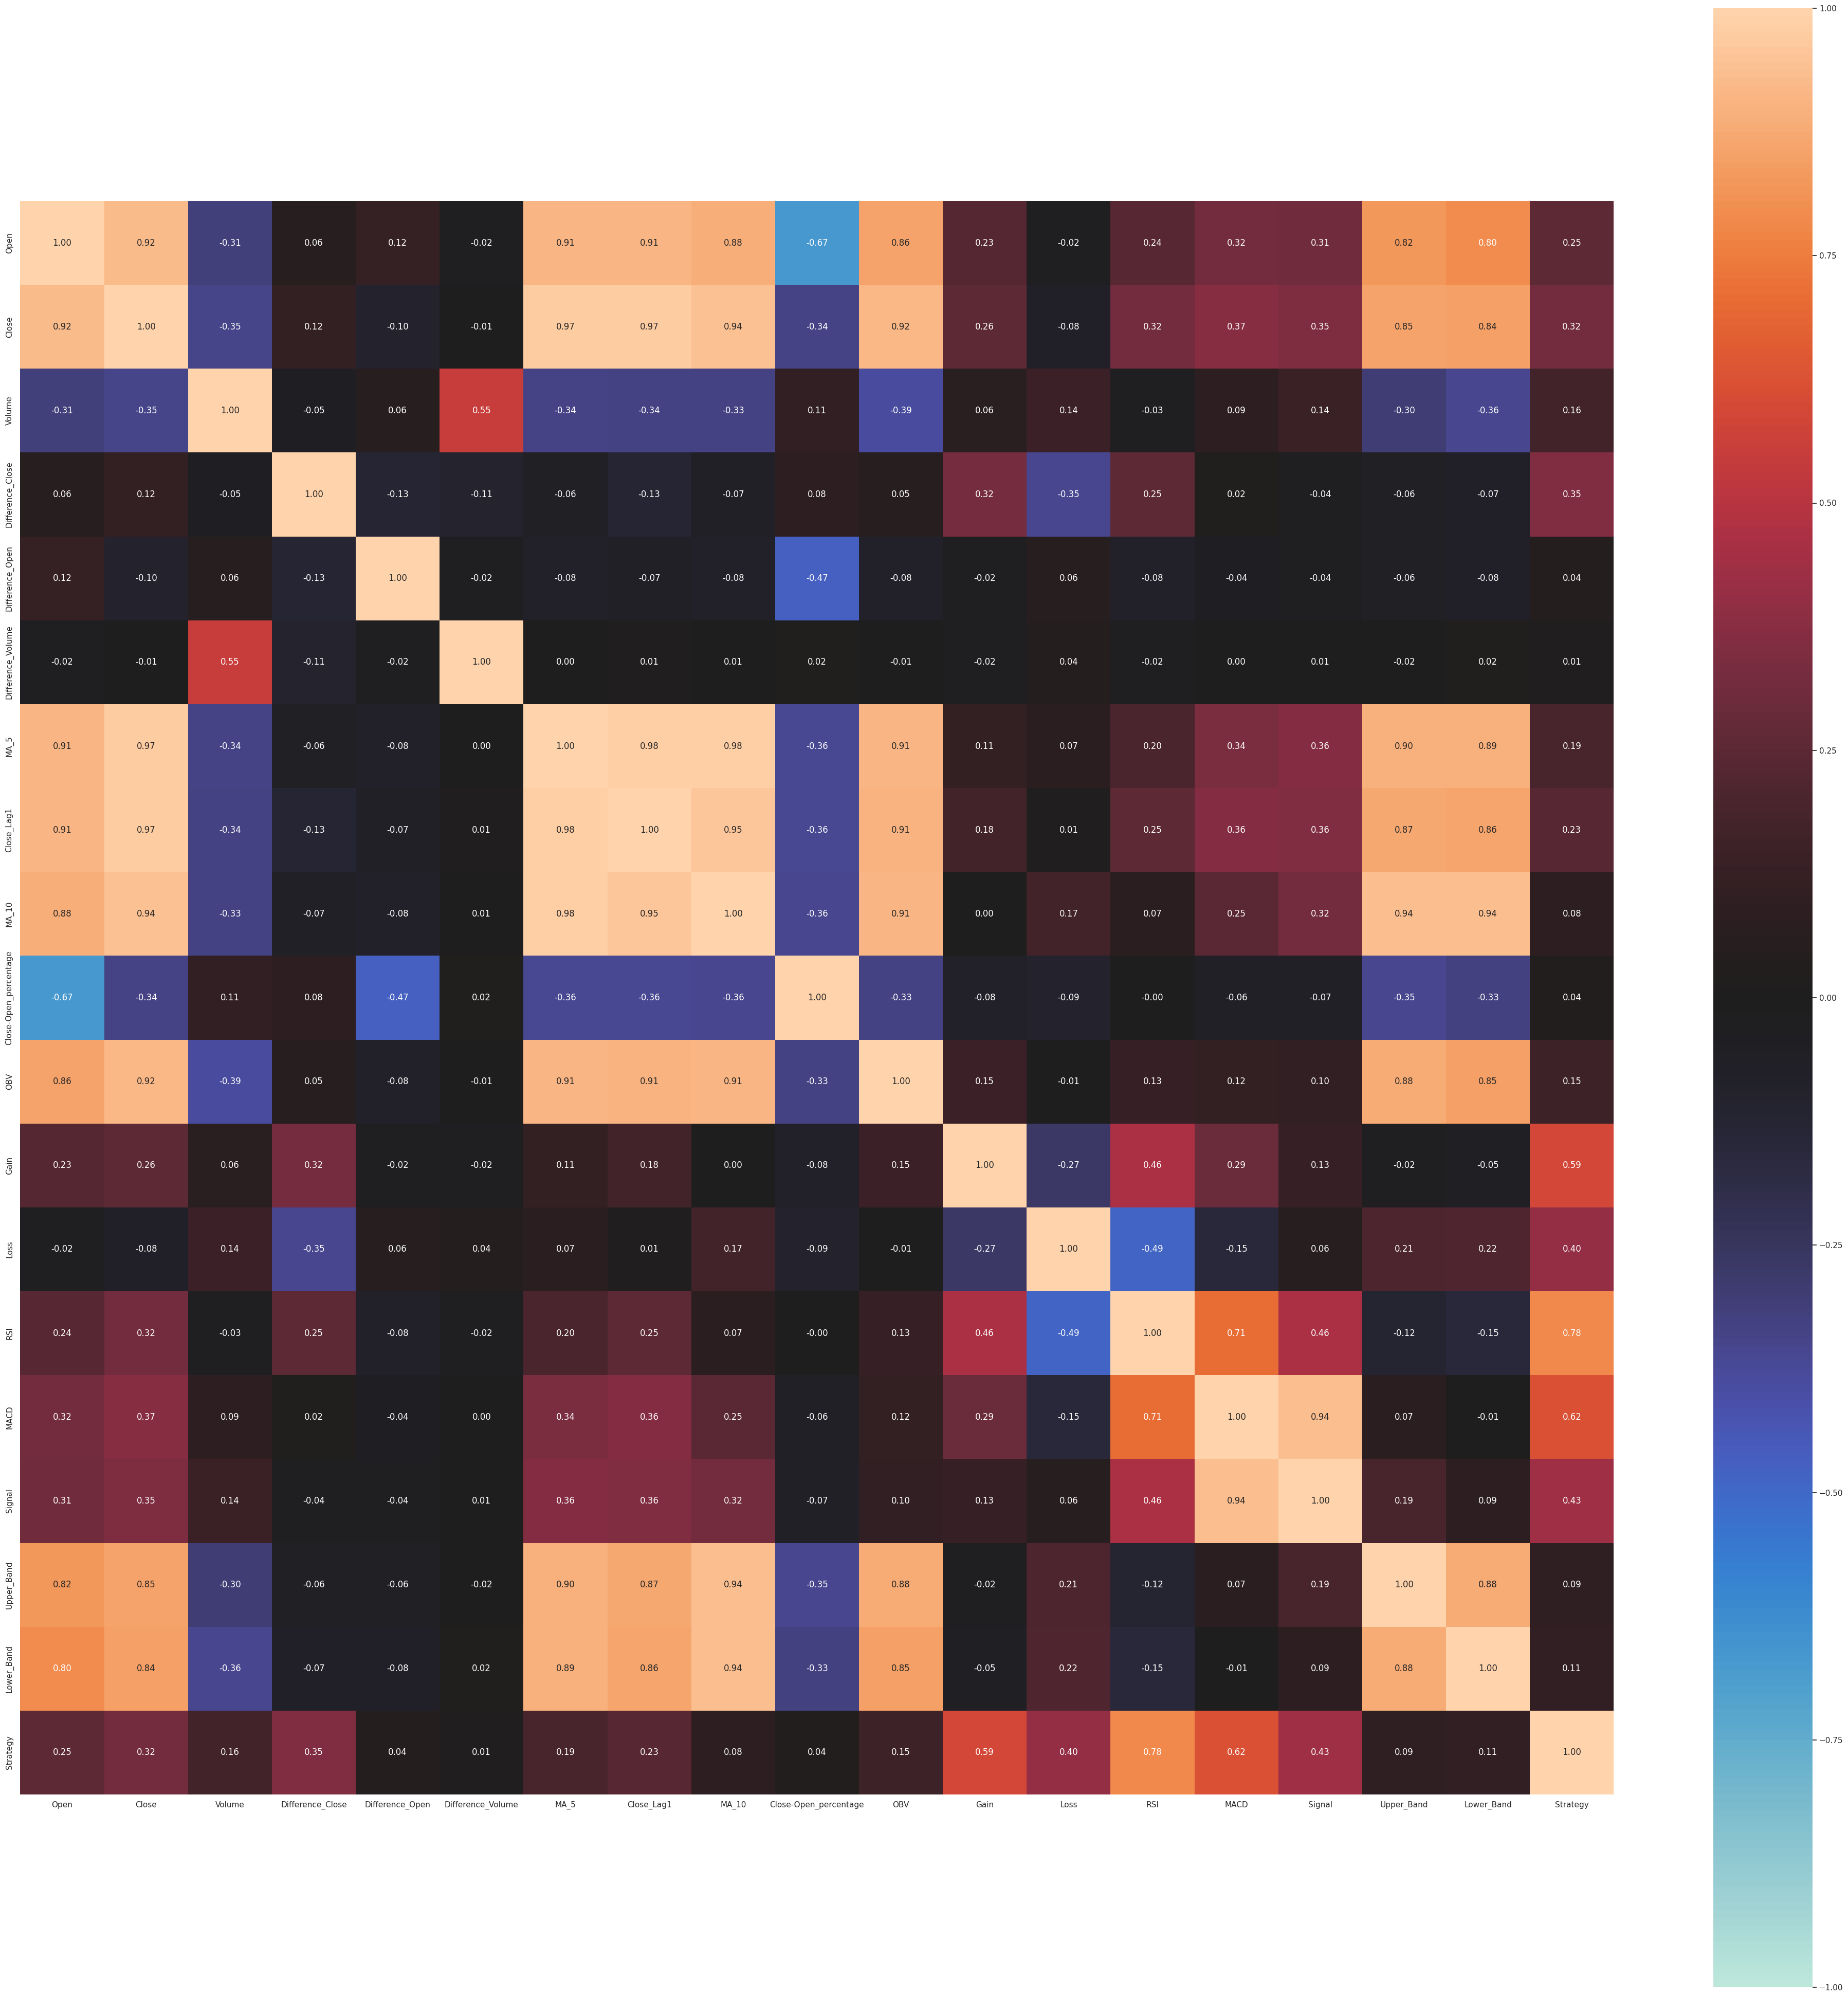

Open     Close    Volume  Difference_Close  \
Open                   1.000000  0.922901 -0.313058          0.057160   
Close                  0.922901  1.000000 -0.347095          0.115910   
Volume                -0.313058 -0.347095  1.000000         -0.045651   
Difference_Close       0.057160  0.115910 -0.045651          1.000000   
Difference_Open        0.118215 -0.101000  0.058972         -0.126350   
Difference_Volume     -0.021149 -0.014729  0.554205         -0.105963   
MA_5                   0.909824  0.971046 -0.340489         -0.057346   
Close_Lag1             0.907155  0.969653 -0.335228         -0.130444   
MA_10                  0.883979  0.939378 -0.332459         -0.068552   
Close-Open_percentage -0.667320 -0.342444  0.105380          0.078524   
OBV                    0.859224  0.919767 -0.386557          0.050555   
Gain                   0.229256  0.256940  0.063282          0.323365   
Loss                  -0.018012 -0.077363  0.142138         -0.354851   
RSI                    0.238831  0.315660 -0.032459          0.254941   
MACD                   0.319840  0.370477  0.090416          0.022581   
Signal                 0.310055  0.348373  0.135428         -0.036444   
Upper_Band             0.820685  0.854942 -0.303470         -0.061479   
Lower_Band             0.796001  0.844769 -0.355070         -0.074195   
Strategy               0.250943  0.317895  0.164181          0.354954   

                       Difference_Open  Difference_Volume      MA_5  \
Open                          0.118215          -0.021149  0.909824   
Close                        -0.101000          -0.014729  0.971046   
Volume                        0.058972           0.554205 -0.340489   
Difference_Close             -0.126350          -0.105963 -0.057346   
Difference_Open               1.000000          -0.021117 -0.080898   
Difference_Volume            -0.021117           1.000000  0.004305   
MA_5                         -0.080898           0.004305  1.000000   
Close_Lag1                   -0.069716           0.011380  0.983397   
MA_10                        -0.080145           0.006778  0.982340   
Close-Open_percentage        -0.473881           0.016186 -0.361113   
OBV                          -0.081695          -0.008712  0.913836   
Gain                         -0.023313          -0.024711  0.112418   
Loss                          0.056323           0.044215  0.074545   
RSI                          -0.082846          -0.015835  0.199343   
MACD                         -0.043810           0.001328  0.341755   
Signal                       -0.038083           0.006848  0.359812   
Upper_Band                   -0.058181          -0.015548  0.897659   
Lower_Band                   -0.075291           0.021508  0.893633   
Strategy                      0.040126           0.014522  0.192044   

                       Close_Lag1     MA_10  Close-Open_percentage       OBV  \
Open                     0.907155  0.883979              -0.667320  0.859224   
Close                    0.969653  0.939378              -0.342444  0.919767   
Volume                  -0.335228 -0.332459               0.105380 -0.386557   
Difference_Close        -0.130444 -0.068552               0.078524  0.050555   
Difference_Open         -0.069716 -0.080145              -0.473881 -0.081695   
Difference_Volume        0.011380  0.006778               0.016186 -0.008712   
MA_5                     0.983397  0.982340              -0.361113  0.913836   
Close_Lag1               1.000000  0.954546              -0.361150  0.905653   
MA_10                    0.954546  1.000000              -0.355472  0.908544   
Close-Open_percentage   -0.361150 -0.355472               1.000000 -0.334647   
OBV                      0.905653  0.908544              -0.334647  1.000000   
Gain                     0.176880  0.002894              -0.079746  0.145203   
Loss                     0.010122  0.169496              -0.093781 -0.006845   
RSI                      

In [92]:
from dython.nominal import associations
some_df = pd.concat([X, y], axis=1)
complete_correlation= associations(some_df, filename= 'complete_correlation.png', figsize=(50,50))
corr_matrix = complete_correlation["corr"]
complete_correlation["corr"]

In [93]:
correlations_above_threshold = corr_matrix["Strategy"][corr_matrix["Strategy"] > 0.3]
correlations_above_threshold

Close               0.317895
Difference_Close    0.354954
Gain                0.590766
Loss                0.400661
RSI                 0.781695
MACD                0.624185
Signal              0.433850
Strategy            1.000000
Name: Strategy, dtype: float64

In [94]:
scaled_train_data = some_df[["Close","Difference_Close", "RSI", "MACD", "Signal","Gain","Loss"]]
scaled_test_data = test[["Close","Difference_Close", "RSI", "MACD", "Signal","Gain","Loss"]]
scaled_test_data

Close  Difference_Close        RSI      MACD    Signal  \
Date                                                                     
2021-03-01  77.096016         -1.575991  43.614161  0.033189  0.502960   
2021-03-08  77.225853          0.129837  50.541839 -0.282662  0.345836   
2021-03-15  77.007149         -0.218704  39.953210 -0.544349  0.167799   
2021-03-22  76.933724         -0.073425  36.859724 -0.749029 -0.015567   
2021-03-29  76.636064         -0.297660  41.660206 -0.924599 -0.197373   
...               ...               ...        ...       ...       ...   
2022-12-26  64.970784         -0.240126  55.095877 -2.599635 -3.074419   
2023-01-02  64.345666         -0.625118  46.011539 -2.385600 -2.936655   
2023-01-09  62.323273         -2.022393  39.868655 -2.352054 -2.819735   
2023-01-16  63.282839          0.959567  43.550937 -2.222420 -2.700272   
2023-01-23  65.682244          2.399404  50.398722 -1.904123 -2.541042   

                Gain      Loss  
Date                            
2021-03-01  0.384281  1.639777  
2021-03-08  0.025967  1.639777  
2021-03-15  0.025967  1.277828  
2021-03-22  0.025967  0.844588  
2021-03-29  0.025967  0.433156  
...              ...       ...  
2022-12-26  1.334235  0.210233  
2023-01-02  1.334235  0.173049  
2023-01-09  1.121695  0.577528  
2023-01-16  0.292885  0.577528  
2023-01-23  0.671794  0.577528  

[100 rows x 7 columns]

In [95]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(scaled_train_data)
scaled_X_test = scaler.transform(scaled_test_data)
scaled_X_train[:5]

array([[-0.98371951,  0.11281905,  0.65293664,  0.6626796 ,  0.31068099,
         1.19577519, -0.03003773],
       [-1.05313028, -0.29334973,  0.82560681,  0.69431911,  0.40945134,
        -0.04474322,  0.20722432],
       [-0.96953096,  0.32715084,  1.1596032 ,  0.74106789,  0.49540531,
         0.24184873, -0.67590075],
       [-0.95095835,  0.06344857,  0.94933654,  0.77387326,  0.56896985,
        -1.21908   , -0.67590075],
       [-0.95496167, -0.02810343,  0.74740725,  0.7865866 ,  0.62881935,
        -1.21908   , -1.34585094]])

In [98]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y)
y_train_encoded, len(y_train_encoded)

(array([2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2,
        2, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2,
        1, 1, 1]),
 267)

In [99]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'num_class': [3]
}

xgb_model = xgb.XGBClassifier(objective='multi:softmax')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_result = grid_search.fit(scaled_X_train, y_train_encoded)

print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy Score: ", grid_result.best_score_)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_class': 3}
Best Accuracy Score:  0.789937106918239


In [100]:
best_params = grid_result.best_params_

best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(scaled_X_train, y_train_encoded)

predictions = best_xgb_model.predict(scaled_X_test)
print("Predictions:", predictions)

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 2 2 2 2 2 1 2 1 2 2 2 1
 2 2 1 2 2 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 2 1 1 2 2 2 2 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1]


In [101]:
predictions = label_encoder.inverse_transform(predictions)
predictions

array(['Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Sell', 'Hold', 'Sell',
       'Sell', 'Sell', 'Hold', 'Sell', 'Sell', 'Hold', 'Sell', 'Sell',
       'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Sell', 'Hold', 'Hold',
       'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Hold', 'Hold', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Buy', 'Buy',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold'], dtype=object)

In [102]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax')
xgb_model.fit(scaled_X_train, y_train_encoded)
predictions_new = xgb_model.predict(scaled_X_test)
predictions_new = label_encoder.inverse_transform(predictions_new)
predictions_new

array(['Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Sell', 'Hold', 'Sell',
       'Sell', 'Sell', 'Hold', 'Sell', 'Sell', 'Hold', 'Sell', 'Sell',
       'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold',
       'Buy', 'Buy', 'Hold', 'Buy', 'Buy', 'Hold', 'Sell', 'Hold', 'Hold',
       'Sell', 'Hold', 'Sell', 'Sell', 'Hold', 'Hold', 'Hold', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold'], dtype=object)

In [103]:
predictions_new == predictions

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [104]:
test['predicted_xgboost'] = predictions
test.head()

Open      Close     Volume  Difference_Close  \
Date                                                            
2021-03-01  72.708331  77.096016  205897600         -1.575991   
2021-03-08  73.310886  77.225853  214095600          0.129837   
2021-03-15  70.610119  77.007149  151601700         -0.218704   
2021-03-22  70.256017  76.933724  193982500         -0.073425   
2021-03-29  68.258324  76.636064  220238400         -0.297660   

            Difference_Open  Difference_Volume       MA_5  Close_Lag1  \
Date                                                                    
2021-03-01         3.089711       -127081600.0  81.071241   78.672007   
2021-03-08         0.602555          8198000.0  79.457431   77.096016   
2021-03-15        -2.700767        -62493900.0  78.205570   77.225853   
2021-03-22        -0.354102         42380800.0  77.386950   77.007149   
2021-03-29        -1.997693         26255900.0  76.979761   76.933724   

                MA_10  Close-Open_percentage        OBV      Gain      Loss  \
Date                                                                          
2021-03-01  82.226826               0.060346  282326200  0.384281  1.639777   
2021-03-08  81.491068               0.053402  496421800  0.025967  1.639777   
2021-03-15  81.117685               0.090597  344820100  0.025967  1.277828   
2021-03-22  80.378618               0.095048  150837600  0.025967  0.844588   
2021-03-29  79.653249               0.122736  -69400800  0.025967  0.433156   

                  RSI      MACD    Signal  Upper_Band  Lower_Band  \
Date                                                                
2021-03-01  43.614161  0.033189  0.502960   87.267985   75.563791   
2021-03-08  50.541839 -0.282662  0.345836   87.297729   75.502473   
2021-03-15  39.953210 -0.544349  0.167799   87.253686   75.584855   
2021-03-22  36.859724 -0.749029 -0.015567   87.409232   75.110408   
2021-03-29  41.660206 -0.924599 -0.197373   86.896790   74.708617   

           predicted_xgboost  
Date                          
2021-03-01               Buy  
2021-03-08               Buy  
2021-03-15               Buy  
2021-03-22               Buy  
2021-03-29               Buy

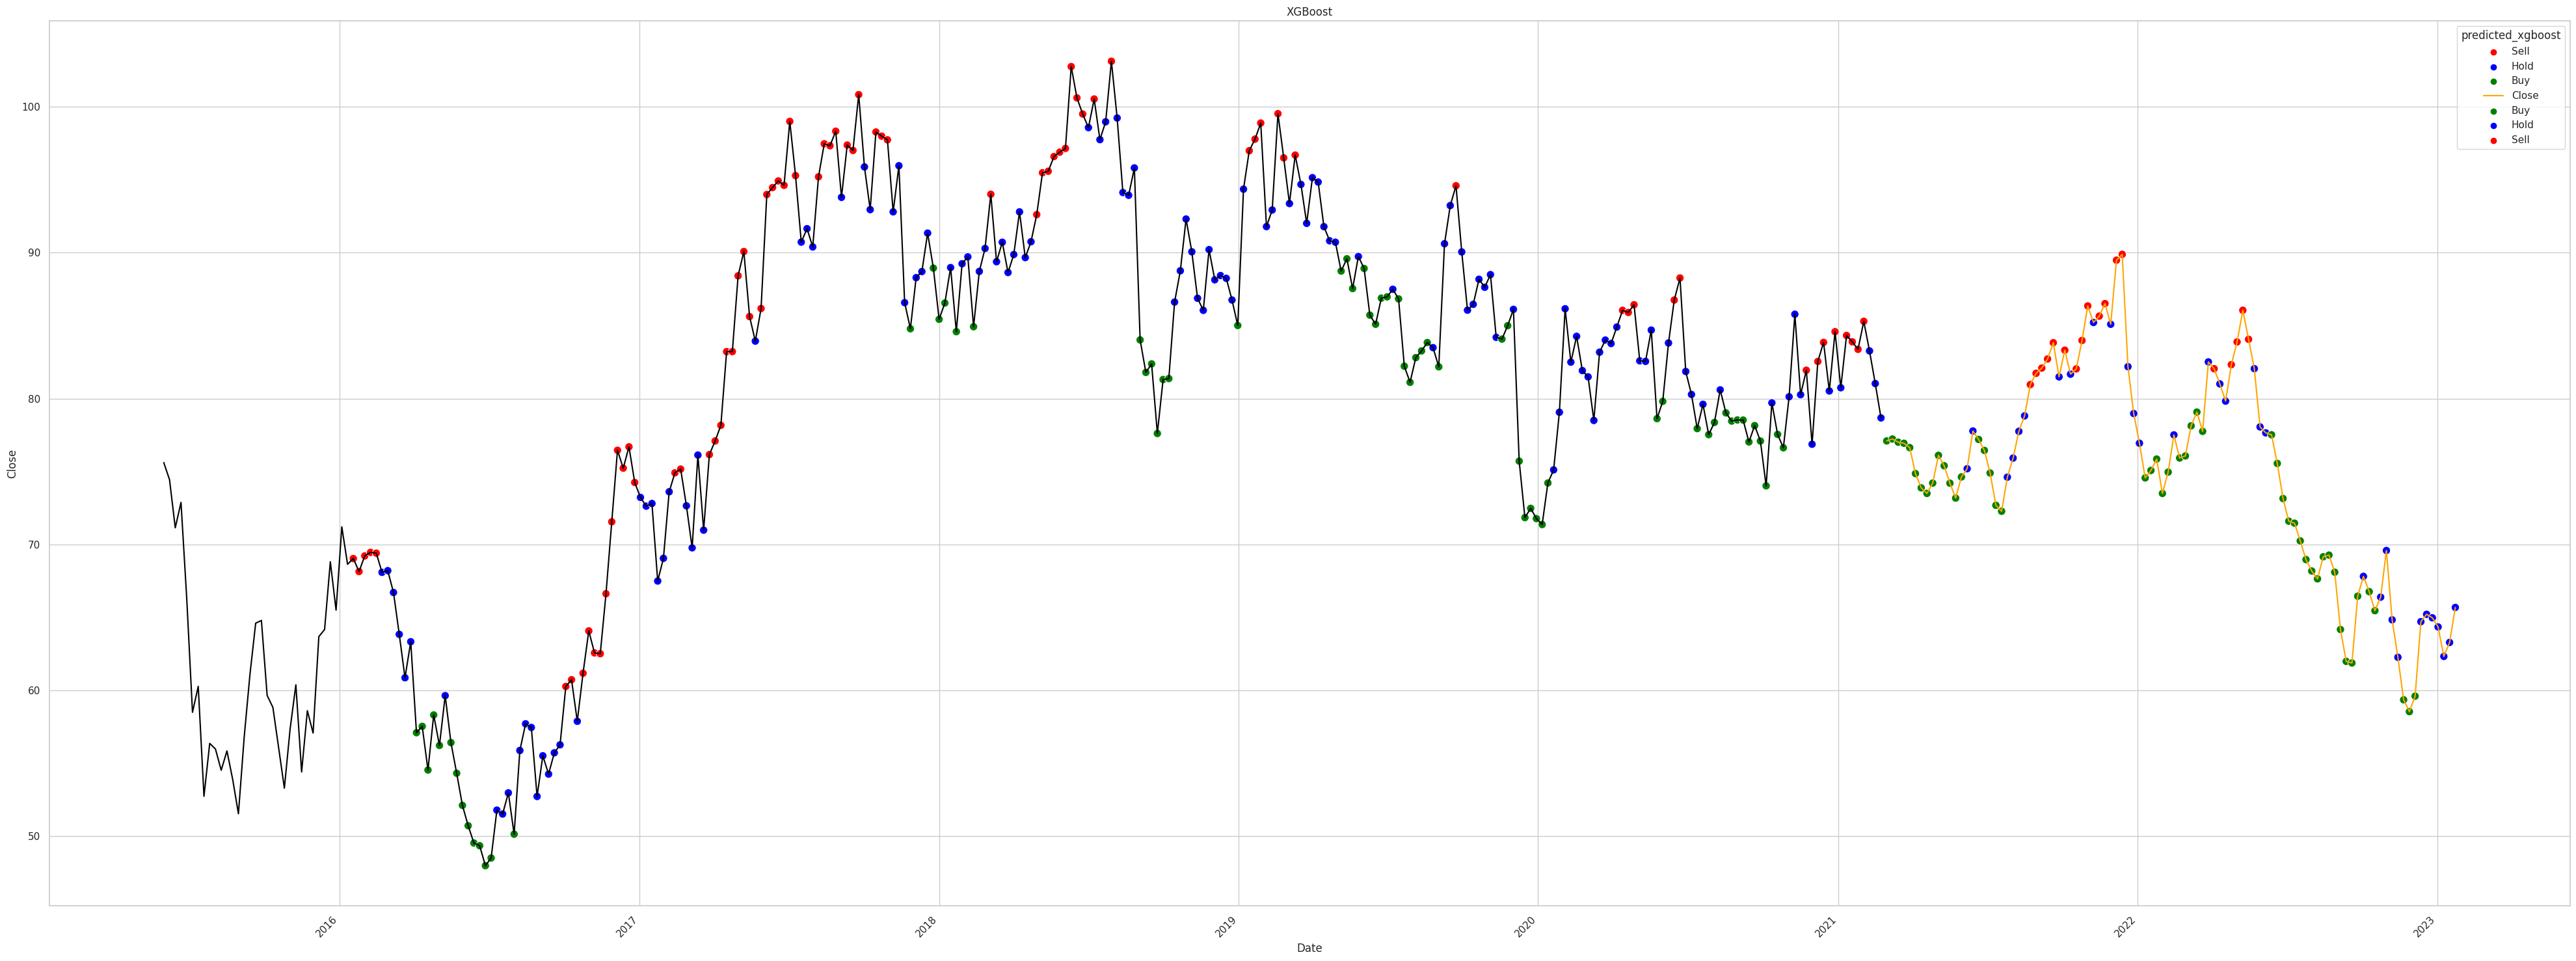

In [108]:
plt.figure(figsize=(50,20))
plt.plot(df_fe['Close'], color = "black")

sub_plot_df = df_fe.copy()
sub_plot_df['Strategy'] = y
sns.scatterplot(data = sub_plot_df,x='Date', y='Close', hue='Strategy', palette={'Buy':'green','Hold':'blue','Sell':'red'}, s=80) # Hold, Buy, Sell

# plt.plot(y_test, color = "red")
# plt.plot(test['predicted_xgboost'] , color='green', label = 'XGBoost Prediction')
test["Close"].plot(color = 'orange')
sns.scatterplot(data = test,x='Date', y='Close', hue='predicted_xgboost', palette={'Buy':'green','Hold':'blue','Sell':'red'}, s=80) # Sell Hold Buy

plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("XGBoost")
plt.show()

In [ ]:
stop = 

## Depricated

In [ ]:
# X['Lag1_Close'] = X['Close'].shift(1)
# X['Lag2_Close'] = X['Close'].shift(2)
# X['Lag3_Close'] = X['Close'].shift(3)
# X['Lag4_Close'] = X['Close'].shift(4)
# X['Lag5_Close'] = X['Close'].shift(5)

# X['Ahead1_Close'] = X['Close'].shift(-1)
# X['Ahead2_Close'] = X['Close'].shift(-2)
# X['Ahead3_Close'] = X['Close'].shift(-3)

# X['Lag1_Open'] = X['Open'].shift(1)
# X['Lag2_Open'] = X['Open'].shift(2)
# X['Lag3_Open'] = X['Open'].shift(3)
# X['Lag4_Open'] = X['Open'].shift(4)
# X['Lag5_Open'] = X['Open'].shift(5)

# X['Lag1_Volume'] = X['Volume'].shift(1)
# X['Lag2_Volume'] = X['Volume'].shift(2)
# X['Lag3_Volume'] = X['Volume'].shift(3)
# X['Lag4_Volume'] = X['Volume'].shift(4)


# X['Open_Pct_Change'] = X['Open'].pct_change()
# X['Close_Pct_Change'] = X['Close'].pct_change()
# # X['Volume_Pct_Change'] = X['Volume'].pct_change()

# X['Lag1_Close'] = X['Close'].shift(1)
# X['Lag1_Open'] = X['Open'].shift(1)

# X['Rolling_Mean_Open'] = X['Open'].rolling(window=3).mean()
# X['Rolling_Mean_Close'] = X['Close'].rolling(window=3).mean()

# result = seasonal_decompose(X['Open'], model='additive', period=12)
# X['Trend_Open'] = result.trend
# X['Seasonal_Open'] = result.seasonal
# X['Residual_Open'] = result.resid

# result = seasonal_decompose(X['Close'], model='additive', period=12)
# X['Trend_Close'] = result.trend
# X['Seasonal_Close'] = result.seasonal
# X['Residual_Close'] = result.resid

# X['Residual_Open'] = X['Open'] - X['Trend_Open'] - X['Seasonal_Open']
# X['Residual_Close'] = X['Close'] - X['Trend_Close'] - X['Seasonal_Close']

# X['Ahead1_Open'] = X['Open'].shift(-1)
# X['Ahead2_Open'] = X['Open'].shift(-2)
# X['Ahead3_Open'] = X['Open'].shift(-3)

# X['Close-Open'] = X['Close']-X['Open']
# X['COLag1'] = X['Close-Open'].shift(1)
# X['COLag2'] = X['Close-Open'].shift(2)
# X['COLag3'] = X['Close-Open'].shift(3)

# X['COAhead1'] = X['Close-Open'].shift(-1)
# X['COAhead2'] = X['Close-Open'].shift(-2)
# X['COAhead3'] = X['Close-Open'].shift(-3)
# # print(X.head())

# X['MA_Close_5'] = X['Close'].rolling(window=5).mean()
# X['MA_Open_5'] = X['Open'].rolling(window=5).mean()
# X['MA_Volume_5'] = X['Volume'].rolling(window=5).mean()

# X['MA_Close_10'] = X['Close'].rolling(window=10).mean()
# X['MA_Open_10'] = X['Open'].rolling(window=10).mean()
# X['MA_Volume_10'] = X['Volume'].rolling(window=10).mean()

# ['Volume', 'Lag2_Close','Lag3_Close', 'Lag4_Close', 'Lag5_Close', 'Lag5_Open', 'Lag1_Volume','Lag2_Volume', 'Open_Pct_Change', 'Close_Pct_Change','Trend_Open','Ahead1_Open','Ahead2_Open','Ahead3_Open',
# 'Close-Open','COLag1','COLag2','COLag3','COAhead1','COAhead2','COAhead3','MA_Close_5','MA_Volume_5','MA_Close_10','MA_Volume_10']
# X['Close'].shift(3)
# X['Close'].shift(4)
# X['Open'].shift(5)
# X['Volume'].shift(1)
# X['Volume'].shift(2)
# X['Open'].pct_change()
# X['Close'].pct_change()
# result = seasonal_decompose(X['Open'], model='additive', period=12)
# X['Trend_Open'] = result.trend
# X['Ahead1_Open'] = X['Open'].shift(-1)
# X['Ahead2_Open'] = X['Open'].shift(-2)
# X['Ahead3_Open'] = X['Open'].shift(-3)
# X['Close-Open'] = X['Close']-X['Open']
# X['Close-Open'].shift(1)
# X['Close-Open'].shift(2)
# X['Close-Open'].shift(3)
# X['Close-Open'].shift(-1)
# X['Close-Open'].shift(-2)
# X['Close-Open'].shift(-3)
# X['Close'].rolling(window=5).mean()
# X['Volume'].rolling(window=5).mean()
# X['Close'].rolling(window=10).mean()
# X['Volume'].rolling(window=10).mean()
features


In [ ]:
f = 'start'

subX = X.copy()

from sklearn.preprocessing import StandardScaler # Volume
# from sklearn.preprocessing import RobustScaler # Close and Open
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

# Scaling the Volume Column
# sub_volume_scaler = StandardScaler()

# sub_volume_scaler.fit(subX[['Volume', 'Lag1_Volume', 'Lag2_Volume', 'Lag3_Volume', 'Lag4_Volume','MA_Volume_10']])
# subX[['Volume_scaled', 'Lag1_Volume_scaled', 'Lag2_Volume_scaled', 'Lag3_Volume_scaled', 'Lag4_Volume_scaled','MA_Volume_10_scaled']] = volume_scaler.transform(subX[[ 'Volume', 'Lag1_Volume', 'Lag2_Volume', 'Lag3_Volume', 'Lag4_Volume','MA_Volume_10']])

# # Scaling the Close and Open column
# sub_close_open_scaler = StandardScaler()
# sub_MA_close_open_scaler = StandardScaler()

# subX[['Open_scaled','Close_scaled', 'Lag1_Close_scaled', 'Lag1_Open_scaled', 'Lag2_Open_scaled', 'Lag3_Open_scaled', 'Lag4_Open_scaled']] = sub_close_open_scaler.fit_transform(subX[['Open','Close', 'Lag1_Close', 'Lag1_Open', 'Lag2_Open', 'Lag3_Open', 'Lag4_Open']])
# subX[['MA_Open_10_scaled']] = sub_MA_close_open_scaler.fit_transform(subX[['MA_Open_10']])

# # Dropping columns which are not required
# subX = subX.drop(['Open','Close','Volume','MA_Open_5','MA_Close_5','MA_Volume_5', 'MA_Close_10','MA_Open_10','MA_Volume_10'],axis = 1)

# # Getting Close-Open column
# subX['Close-Open'] = subX['Close_scaled'] - subX['Open_scaled']


# Standard Scaling
# [ 'Lag5_Close', 'Ahead2_Open','Ahead3_Open','Close-Open','COLag1','COLag2','COLag3','COAhead1','COAhead2','COAhead3']

sc_Lag4_Close = StandardScaler()
subX[['Lag4_Close']] = sc_Lag4_Close.fit_transform(subX[['Lag4_Close']])

sc_Lag5_Close = StandardScaler()
subX[['Lag5_Close']] = sc_Lag5_Close.fit_transform(subX[['Lag5_Close']])

sc_Ahead2_Open = StandardScaler()
subX[['Ahead2_Open']] = sc_Ahead2_Open.fit_transform(subX[['Ahead2_Open']])

sc_Ahead3_Open = StandardScaler()
subX[['Ahead3_Open']] = sc_Ahead3_Open.fit_transform(subX[['Ahead3_Open']])

sc_CO = StandardScaler()
subX[['Close-Open']] = sc_CO.fit_transform(subX[['Close-Open']])

sc_COLag1 = StandardScaler()
subX[['COLag1']] = sc_COLag1.fit_transform(subX[['COLag1']])

sc_COLag2 = StandardScaler()
subX[['COLag2']] = sc_COLag2.fit_transform(subX[['COLag2']])

sc_COLag3 = StandardScaler()
subX[['COLag3']] = sc_COLag3.fit_transform(subX[['COLag3']])

sc_COAhead1 = StandardScaler()
subX[['COAhead1']] = sc_COAhead1.fit_transform(subX[['COAhead1']])

sc_COAhead2 = StandardScaler()
subX[['COAhead2']] = sc_COAhead2.fit_transform(subX[['COAhead2']])

sc_COAhead3 = StandardScaler()
subX[['COAhead3']] = sc_COAhead3.fit_transform(subX[['COAhead3']])

# Getting only requrired features
subX = subX[features]

# Label Encoding the y
sub_sgy_encoder = LabelEncoder()

y_encoded = sub_sgy_encoder.fit_transform(y)

print(len(subX),len(y_encoded))


# Model Building

estimators = [
#     ('kn', KNeighborsClassifier()),
#     ('gb', GradientBoostingClassifier(random_state=42)),
#     ('cb',CatBoostClassifier(random_state=42,verbose = False)),
#     ('lg',lgb.LGBMClassifier(random_state = 42)),
#     ('ab', AdaBoostClassifier(random_state=42)),
#     ('bg', BaggingClassifier(random_state=42)),
    ('et', ExtraTreesClassifier(random_state=42)),
    ('xg', xgb.XGBClassifier(random_state = 42)),
]

classifiers = [
#     SVC(random_state=42),
#     SVC(random_state=42, kernel = 'rbf'),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    ExtraTreesClassifier(random_state = 42),
    ExtraTreesClassifier(random_state = 42, max_features='auto', min_samples_split=10, n_estimators=500),
    HistGradientBoostingClassifier(random_state=42),
    xgb.XGBClassifier(random_state = 42),
    DecisionTreeClassifier(random_state = 42),
    SGDClassifier(random_state = 42),
    MLPClassifier(random_state = 42),
    lgb.LGBMClassifier(random_state = 42),
    lgb.DaskLGBMClassifier(random_state = 42),
    LogisticRegression(random_state = 42),
    CatBoostClassifier(random_state=42,verbose = False),
    StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42))
]

classifier_pred = {}

for i, model in enumerate(classifiers):
    sub_model = model
    try:
        sub_model.fit(subX, y_encoded)
    except:
        print(f"Name: {type(model).__name__} : Error")
        continue

    # Importing Test.csv
    test_df = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

    # Making Date as the index
    test_df = test_df.drop(['id'],axis = 1)
    test_df['Date'] = pd.to_datetime(test_df['Date'])
    test_df.index = test_df.Date
    test_df = test_df.drop(['Date'],axis = 1)

    # Merging predicted Close with the test_df
    test_df['Close'] = df_submission['Close']

    # Merging train and test to find moving average
#     print(len(X), len(test_df))
    train_test_merge = pd.concat([X, test_df], axis=0)
    train_test_merge = train_test_merge[['Open','Close','Volume']]
#     train_test_merge = train_test_merge['Open','Close','Volume']
#     print(len(train_test_merge))

    # FEATURES REQUIRED
    # ['Volume', 'Lag2_Close','Lag3_Close', 'Lag4_Close', 'Lag5_Close', 'Lag5_Open', 'Lag1_Volume','Lag2_Volume', 'Open_Pct_Change', 'Close_Pct_Change','Trend_Open','Ahead1_Open','Ahead2_Open','Ahead3_Open',
    # 'Close-Open','COLag1','COLag2','COLag3','COAhead1','COAhead2','COAhead3','MA_Close_5','MA_Volume_5','MA_Close_10','MA_Volume_10']
    
    # Preprocessing for test data 
#     X['Close'].shift(3)
#     X['Close'].shift(4)
#     X['Open'].shift(5)
#     X['Volume'].shift(1)
#     X['Volume'].shift(2)
#     X['Open'].pct_change()
#     X['Close'].pct_change()
#     result = seasonal_decompose(X['Open'], model='additive', period=12)
#     X['Trend_Open'] = result.trend
#     X['Ahead1_Open'] = X['Open'].shift(-1)
#     X['Ahead2_Open'] = X['Open'].shift(-2)
#     X['Ahead3_Open'] = X['Open'].shift(-3)
#     X['Close-Open'] = X['Close']-X['Open']
#     X['Close-Open'].shift(1)
#     X['Close-Open'].shift(2)
#     X['Close-Open'].shift(3)
#     X['Close-Open'].shift(-1)
#     X['Close-Open'].shift(-2)
#     X['Close-Open'].shift(-3)
#     X['Close'].rolling(window=5).mean()
#     X['Volume'].rolling(window=5).mean()
#     X['Close'].rolling(window=10).mean()
#     X['Volume'].rolling(window=10).mean()

    train_test_merge['Lag2_Close'] = train_test_merge['Close'].shift(2)
    train_test_merge['Lag3_Close'] = train_test_merge['Close'].shift(3)
    train_test_merge['Lag4_Close'] = train_test_merge['Close'].shift(4) #
    train_test_merge['Lag5_Close'] = train_test_merge['Close'].shift(5) #
    train_test_merge['Lag5_Open'] = train_test_merge['Open'].shift(5)
    train_test_merge['Lag1_Volume'] = train_test_merge['Volume'].shift(1)
    train_test_merge['Lag2_Volume'] = train_test_merge['Volume'].shift(2)
    train_test_merge['Open_Pct_Change'] = train_test_merge['Open'].pct_change()
    train_test_merge['Close_Pct_Change'] = train_test_merge['Close'].pct_change()
    result = seasonal_decompose(train_test_merge['Open'], model='additive', period=12)
    train_test_merge['Trend_Open'] = result.trend
    train_test_merge['Ahead1_Open'] = train_test_merge['Open'].shift(-1)
    train_test_merge['Ahead2_Open'] = train_test_merge['Open'].shift(-2) #
    train_test_merge['Ahead3_Open'] = train_test_merge['Open'].shift(-3) #
    train_test_merge['Close-Open'] = train_test_merge['Close'] - train_test_merge['Open'] #
    train_test_merge['COLag1'] = train_test_merge['Close-Open'].shift(1) #
    train_test_merge['COLag2'] = train_test_merge['Close-Open'].shift(2) #
    train_test_merge['COLag3'] = train_test_merge['Close-Open'].shift(3) #
    train_test_merge['COAhead1'] = train_test_merge['Close-Open'].shift(-1) #
    train_test_merge['COAhead2'] = train_test_merge['Close-Open'].shift(-2) #
    train_test_merge['COAhead3'] = train_test_merge['Close-Open'].shift(-3) #
    train_test_merge['MA_Close_5'] = train_test_merge['Close'].rolling(window=5).mean()
    train_test_merge['MA_Volume_5'] = train_test_merge['Volume'].rolling(window=5).mean()
    train_test_merge['MA_Close_10'] = train_test_merge['Close'].rolling(window=10).mean()
    train_test_merge['MA_Volume_10'] = train_test_merge['Volume'].rolling(window=10).mean()
    
    
#     train_test_merge['Lag1_Close'] = train_test_merge['Close'].shift(1)
    
#     train_test_merge['Lag1_Open'] = train_test_merge['Open'].shift(1)
#     train_test_merge['Lag2_Open'] = train_test_merge['Open'].shift(2)
#     train_test_merge['Lag3_Open'] = train_test_merge['Open'].shift(3)
#     train_test_merge['Lag4_Open'] = train_test_merge['Open'].shift(4)
    
#     train_test_merge['Close_Pct_Change'] = train_test_merge['Close'].pct_change()
    
#     train_test_merge['Close-Open'] = train_test_merge['Close']-train_test_merge['Open']
#     train_test_merge['COLag2'] = train_test_merge['Close-Open'].shift(2)
#     train_test_merge['COLag3'] = train_test_merge['Close-Open'].shift(3)
# #     train_test_merge = train_test_merge.drop(['Close-Open', axis = 1])
    
#     train_test_merge['MA_Open_10'] = train_test_merge['Open'].rolling(window=10).mean()    
    
    test_df = train_test_merge[285:]
    test_df['COAhead1'] = test_df['COAhead1'].fillna(method='ffill')
    test_df['COAhead2'] = test_df['COAhead2'].fillna(method='ffill')
    test_df['COAhead3'] = test_df['COAhead3'].fillna(method='ffill')
    
    test_df['Ahead1_Open'] = test_df['Ahead1_Open'].fillna(method='ffill')
    test_df['Ahead2_Open'] = test_df['Ahead2_Open'].fillna(method='ffill')
    test_df['Ahead3_Open'] = test_df['Ahead3_Open'].fillna(method='ffill')
    
    test_df['Trend_Open'] = test_df['Trend_Open'].fillna(method='ffill')
#     print(test_df.head())
    # Scaling the columns
#     test_df[['Open_scaled','Close_scaled', 'Lag1_Close_scaled', 'Lag1_Open_scaled', 'Lag2_Open_scaled', 'Lag3_Open_scaled', 'Lag4_Open_scaled']] = sub_close_open_scaler.transform(test_df[['Open','Close', 'Lag1_Close', 'Lag1_Open', 'Lag2_Open', 'Lag3_Open', 'Lag4_Open']])
#     test_df[['MA_Open_10_scaled']] = sub_MA_close_open_scaler.transform(test_df[['MA_Open_10']])
    

    # Finding Moving average for the test dataframe
#     train_test_merge['MA_Close_5'] = train_test_merge['Close'].rolling(window=5).mean()
#     train_test_merge['MA_Open_5'] = train_test_merge['Open'].rolling(window=5).mean()
#     train_test_merge['MA_Volume_5'] = train_test_merge['Volume'].rolling(window=5).mean()

#     train_test_merge['MA_Close_10'] = train_test_merge['Close'].rolling(window=10).mean()
#     train_test_merge['MA_Open_10'] = train_test_merge['Open'].rolling(window=10).mean()
#     train_test_merge['MA_Volume_10'] = train_test_merge['Volume'].rolling(window=10).mean()

#     test_df = train_test_merge[274:]

#     # Performing Preprocessing for test dataframe
#     test_df[['Volume_scaled', 'MA_Volume_5_scaled', 'MA_Volume_10_scaled']] = sub_volume_scaler.transform(test_df[['Volume', 'MA_Volume_5', 'MA_Volume_10']])

#     test_df[['Close_scaled', 'Open_scaled']] = sub_close_open_scaler.transform(test_df[['Close', 'Open']])
#     test_df[['MA_Close_5_scaled', 'MA_Open_5_scaled', 'MA_Close_10_scaled', 'MA_Open_10_scaled']] = sub_MA_close_open_scaler.transform(test_df[['MA_Close_5', 'MA_Open_5', 'MA_Close_10', 'MA_Open_10']])

#     test_df = test_df.drop(['Open','Close','Volume','MA_Open_5','MA_Close_5','MA_Volume_5', 'MA_Close_10','MA_Open_10','MA_Volume_10'],axis = 1)

#     test_df['Close-Open'] = test_df['Close_scaled'] - test_df['Open_scaled']


    # Standard Scaling Features
#     [ 'Lag5_Close', 'Ahead2_Open','Ahead3_Open','Close-Open','COLag1','COLag2','COLag3','COAhead1','COAhead2','COAhead3']
    test_df[['Lag4_Close']] = sc_Lag4_Close.transform(test_df[['Lag4_Close']])
    test_df[['Lag5_Close']] = sc_Lag5_Close.transform(test_df[['Lag5_Close']])
    test_df[['Ahead2_Open']] = sc_Ahead2_Open.transform(test_df[['Ahead2_Open']])
    test_df[['Ahead3_Open']] = sc_Ahead3_Open.transform(test_df[['Ahead3_Open']])
    test_df[['Close-Open']] = sc_CO.transform(test_df[['Close-Open']])
    test_df[['COLag1']] = sc_COLag1.transform(test_df[['COLag1']])
    test_df[['COLag2']] = sc_COLag2.transform(test_df[['COLag2']])
    test_df[['COLag3']] = sc_COLag3.transform(test_df[['COLag3']])
    test_df[['COAhead1']] = sc_COAhead1.transform(test_df[['COAhead1']])
    test_df[['COAhead2']] = sc_COAhead2.transform(test_df[['COAhead2']])
    test_df[['COAhead3']] = sc_COAhead3.transform(test_df[['COAhead3']])


    test_df = test_df[features]

    sub_predictions = sub_model.predict(test_df)
    sub_predictions = sub_sgy_encoder.inverse_transform(sub_predictions)
    classifier_pred[i] = sub_predictions

    prev_pred = pd.read_csv("/kaggle/input/lstmsubmission/BR_2_Overfitted_577_578_594_6.csv")
    print(f"[{i}]Name: {type(model).__name__} : Accuracy: {accuracy_score(np.array(prev_pred['Strategy']), sub_predictions)}")

In [ ]:
# classifier_pred[3]

In [ ]:
# from sklearn.metrics import f1_score
# # f1_score(y_true, y_pred, average='macro')
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[1], average=None)}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[6], average=None)}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[7], average=None)}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[8], average=None)}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[11], average=None)}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[14], average=None)}")

# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[1], average='macro')}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[6], average='macro')}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[7], average='macro')}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[8], average='macro')}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[11], average='macro')}")
# print(f"f1_score: {f1_score(np.array(prev_pred['Strategy']), classifier_pred[14], average='macro')}")

## Testing Side

In [ ]:
# f = 'start'

# subX = X.copy()

# from sklearn.preprocessing import StandardScaler # Volume
# from sklearn.preprocessing import RobustScaler # Close and Open
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import accuracy_score

# # Scaling the Volume Column
# sub_volume_scaler = StandardScaler()

# sub_volume_scaler.fit(subX[['Volume', 'MA_Volume_5', 'MA_Volume_10']])
# subX[['Volume_scaled', 'MA_Volume_5_scaled', 'MA_Volume_10_scaled']] = volume_scaler.transform(subX[['Volume', 'MA_Volume_5', 'MA_Volume_10']])

# # Scaling the Close and Open column
# sub_close_open_scaler = MinMaxScaler()
# sub_MA_close_open_scaler = MinMaxScaler()

# subX[['Close_scaled', 'Open_scaled']] = sub_close_open_scaler.fit_transform(subX[['Close', 'Open']])
# subX[['MA_Close_5_scaled', 'MA_Open_5_scaled', 'MA_Close_10_scaled', 'MA_Open_10_scaled']] = sub_MA_close_open_scaler.fit_transform(subX[['MA_Close_5', 'MA_Open_5', 'MA_Close_10', 'MA_Open_10']])

# # Dropping columns which are not required
# subX = subX.drop(['Open','Close','Volume','MA_Open_5','MA_Close_5','MA_Volume_5', 'MA_Close_10','MA_Open_10','MA_Volume_10'],axis = 1)

# # Getting Close-Open column
# subX['Close-Open'] = subX['Close_scaled'] - subX['Open_scaled']

# # Getting only requrired features
# subX = subX[features]

# # Label Encoding the y
# sub_sgy_encoder = LabelEncoder()

# y_encoded = sub_sgy_encoder.fit_transform(y)

# # print(len(subX),len(y_encoded))

# # Model Building
# sub_model = ExtraTreesClassifier(random_state = 42)
# sub_model.fit(subX, y_encoded)

# # Importing Test.csv
# test_df = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

# # Making Date as the index
# test_df = test_df.drop(['id'],axis = 1)
# test_df['Date'] = pd.to_datetime(test_df['Date'])
# test_df.index = test_df.Date
# test_df = test_df.drop(['Date'],axis = 1)

# # Merging predicted Close with the test_df
# test_df['Close'] = df_submission['Close']

# # Merging train and test to find moving average
# print(len(X), len(test_df))
# train_test_merge = pd.concat([X, test_df], axis=0)
# print(len(train_test_merge))

# # Finding Moving average for the test dataframe
# train_test_merge['MA_Close_5'] = train_test_merge['Close'].rolling(window=5).mean()
# train_test_merge['MA_Open_5'] = train_test_merge['Open'].rolling(window=5).mean()
# train_test_merge['MA_Volume_5'] = train_test_merge['Volume'].rolling(window=5).mean()

# train_test_merge['MA_Close_10'] = train_test_merge['Close'].rolling(window=10).mean()
# train_test_merge['MA_Open_10'] = train_test_merge['Open'].rolling(window=10).mean()
# train_test_merge['MA_Volume_10'] = train_test_merge['Volume'].rolling(window=10).mean()

# test_df = train_test_merge[274:]

# # Performing Preprocessing for test dataframe
# test_df[['Volume_scaled', 'MA_Volume_5_scaled', 'MA_Volume_10_scaled']] = sub_volume_scaler.transform(test_df[['Volume', 'MA_Volume_5', 'MA_Volume_10']])

# test_df[['Close_scaled', 'Open_scaled']] = sub_close_open_scaler.transform(test_df[['Close', 'Open']])
# test_df[['MA_Close_5_scaled', 'MA_Open_5_scaled', 'MA_Close_10_scaled', 'MA_Open_10_scaled']] = sub_MA_close_open_scaler.transform(test_df[['MA_Close_5', 'MA_Open_5', 'MA_Close_10', 'MA_Open_10']])

# test_df = test_df.drop(['Open','Close','Volume','MA_Open_5','MA_Close_5','MA_Volume_5', 'MA_Close_10','MA_Open_10','MA_Volume_10'],axis = 1)

# test_df['Close-Open'] = test_df['Close_scaled'] - test_df['Open_scaled']

# test_df = test_df[features]

# sub_predictions = sub_model.predict(test_df)
# sub_predictions = sub_sgy_encoder.inverse_transform(sub_predictions)

# prev_pred = pd.read_csv("/kaggle/input/lstmsubmission/BR_2_Overfitted_577_578_594_6.csv")

# accuracy_score(np.array(prev_pred['Strategy']), sub_predictions)

In [ ]:
# subX = X.copy()
# subX.head()

- Scale Volume

In [ ]:
# from sklearn.preprocessing import StandardScaler # Volume

# sub_volume_scaler = StandardScaler()

# sub_volume_scaler.fit(subX[['Volume', 'Lag1_Volume', 'Lag2_Volume', 'Lag3_Volume', 'Lag4_Volume','MA_Volume_10']])
# subX[['Volume_scaled', 'Lag1_Volume_scaled', 'Lag2_Volume_scaled', 'Lag3_Volume_scaled', 'Lag4_Volume_scaled','MA_Volume_10_scaled']] = volume_scaler.transform(subX[[ 'Volume', 'Lag1_Volume', 'Lag2_Volume', 'Lag3_Volume', 'Lag4_Volume','MA_Volume_10']])

# subX.head()

- Scale Close and Open

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# sub_close_open_scaler = MinMaxScaler()
# sub_MA_close_open_scaler = MinMaxScaler()

# subX[['Close_scaled', 'Open_scaled']] = sub_close_open_scaler.fit_transform(subX[['Close', 'Open']])
# subX[['MA_Close_5_scaled', 'MA_Open_5_scaled', 'MA_Close_10_scaled', 'MA_Open_10_scaled']] = sub_MA_close_open_scaler.fit_transform(subX[['MA_Close_5', 'MA_Open_5', 'MA_Close_10', 'MA_Open_10']])

# subX.head()

- Drop unnecessary columns

In [ ]:
# subX = subX.drop(['Open','Close','Volume','MA_Open_5','MA_Close_5','MA_Volume_5', 'MA_Close_10','MA_Open_10','MA_Volume_10'],axis = 1)
# subX.head()

- Create Close-open column

In [ ]:
# subX['Close-Open'] = subX['Close_scaled'] - subX['Open_scaled']
# subX.head()

- Re-format the dataframe

In [ ]:
# X_train.head()

In [ ]:
# subX = subX[features]
# subX.head()

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# sub_sgy_encoder = LabelEncoder()

# y_encoded = sub_sgy_encoder.fit_transform(y)
# y_encoded

In [ ]:
# print(len(subX),len(y_encoded))

In [ ]:
# sub_model = HistGradientBoostingClassifier(random_state=42)
# sub_model.fit(subX, y_encoded)

In [ ]:
# test_df = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

# test_df = test_df.drop(['id'],axis = 1)
# test_df['Date'] = pd.to_datetime(test_df['Date'])
# test_df.index = test_df.Date
# test_df = test_df.drop(['Date'],axis = 1)

# test_df.head()

In [ ]:
# test_df['Close'] = df_submission['Close']
# test_df.head()

- Preprocessing the test data

In [ ]:
# print(len(X), len(test_df))
# train_test_merge = pd.concat([X, test_df], axis=0)
# print(len(train_test_merge))

In [ ]:
# train_test_merge['MA_Close_5'] = train_test_merge['Close'].rolling(window=5).mean()
# train_test_merge['MA_Open_5'] = train_test_merge['Open'].rolling(window=5).mean()
# train_test_merge['MA_Volume_5'] = train_test_merge['Volume'].rolling(window=5).mean()

# train_test_merge['MA_Close_10'] = train_test_merge['Close'].rolling(window=10).mean()
# train_test_merge['MA_Open_10'] = train_test_merge['Open'].rolling(window=10).mean()
# train_test_merge['MA_Volume_10'] = train_test_merge['Volume'].rolling(window=10).mean()

# train_test_merge.head()

In [ ]:
# test_df = train_test_merge[274:]
# test_df.head()

In [ ]:
# test_df[['Volume_scaled', 'MA_Volume_5_scaled', 'MA_Volume_10_scaled']] = sub_volume_scaler.transform(test_df[['Volume', 'MA_Volume_5', 'MA_Volume_10']])

# test_df[['Close_scaled', 'Open_scaled']] = sub_close_open_scaler.transform(test_df[['Close', 'Open']])
# test_df[['MA_Close_5_scaled', 'MA_Open_5_scaled', 'MA_Close_10_scaled', 'MA_Open_10_scaled']] = sub_MA_close_open_scaler.transform(test_df[['MA_Close_5', 'MA_Open_5', 'MA_Close_10', 'MA_Open_10']])

# test_df = test_df.drop(['Open','Close','Volume','MA_Open_5','MA_Close_5','MA_Volume_5', 'MA_Close_10','MA_Open_10','MA_Volume_10'],axis = 1)

# test_df['Close-Open'] = test_df['Close_scaled'] - test_df['Open_scaled']

# test_df = test_df[features]
# test_df.head()

In [ ]:
# test_df = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

# test_df = test_df.drop(['id'],axis = 1)
# test_df['Date'] = pd.to_datetime(test_df['Date'])
# test_df.index = test_df.Date
# test_df = test_df.drop(['Date'],axis = 1)

# # test_df.head()

# test_df['Close'] = df_submission['Close']
# # test_df.head()
# # Preparing testDF for lags and aheads
# # features = ['Open','Close','Lag1_Close','Ahead1_Close','Ahead2_Close','Ahead3_Close','Lag1_Open','Lag2_Open','Lag3_Open','Lag4_Open','Ahead1_Open','Ahead2_Open','Ahead3_Open','COLag2','COLag3']

# test_df = test_df.drop(['Volume'], axis = 1)
# test_df['Lag1_Close'] = test_df['Close'].shift(1)
# test_df['Ahead1_Close'] = test_df['Close'].shift(-1)
# test_df['Ahead2_Close'] = test_df['Close'].shift(-2)
# test_df['Ahead3_Close'] = test_df['Close'].shift(-3)
# test_df['Lag1_Open'] = test_df['Open'].shift(1)
# test_df['Lag2_Open'] = test_df['Open'].shift(2)
# test_df['Lag3_Open'] = test_df['Open'].shift(3)
# test_df['Lag4_Open'] = test_df['Open'].shift(4)
# test_df['Ahead1_Open'] = test_df['Open'].shift(-1)
# test_df['Ahead2_Open'] = test_df['Open'].shift(-2)
# test_df['Ahead3_Open'] = test_df['Open'].shift(-3)
# test_df['Close-Open'] = test_df['Close']-test_df['Open']
# test_df['COLag2'] = test_df['Close-Open'].shift(2)
# test_df['COLag3'] = test_df['Close-Open'].shift(3)

# test_df = test_df.drop(['Close-Open'], axis = 1)


# test_df['Lag1_Close'] = test_df['Lag1_Close'].fillna(method='bfill')
# test_df['Lag1_Open'] = test_df['Lag1_Open'].fillna(method='bfill')
# test_df['Lag2_Open'] = test_df['Lag2_Open'].fillna(method='bfill')
# test_df['Lag3_Open'] = test_df['Lag3_Open'].fillna(method='bfill')
# test_df['Lag4_Open'] = test_df['Lag4_Open'].fillna(method='bfill')
# test_df['COLag2'] = test_df['COLag2'].fillna(method='bfill')
# test_df['COLag3'] = test_df['COLag3'].fillna(method='bfill')

# test_df['Ahead1_Close'] = test_df['Ahead1_Close'].fillna(method='ffill')
# test_df['Ahead2_Close'] = test_df['Ahead2_Close'].fillna(method='ffill')
# test_df['Ahead3_Close'] = test_df['Ahead3_Close'].fillna(method='ffill')
# test_df['Ahead1_Open'] = test_df['Ahead1_Open'].fillna(method='ffill')
# test_df['Ahead2_Open'] = test_df['Ahead2_Open'].fillna(method='ffill')
# test_df['Ahead3_Open'] = test_df['Ahead3_Open'].fillna(method='ffill')

# print(test_df.shape)
# test_df.head()

# # Forwaard fill for ahead
# # Backward fill for lag

In [ ]:
# sub_predictions = sub_model.predict(test_df)
# sub_predictions = sub_sgy_encoder.inverse_transform(sub_predictions)
# sub_predictions

In [ ]:
# prev_pred = pd.read_csv("/kaggle/input/lstmsubmission/BR_2_Overfitted_577_578_594_6.csv")
# prev_pred.head()

In [ ]:
# from sklearn.metrics import accuracy_score
# accuracy_score(np.array(prev_pred['Strategy']), sub_predictions)

In [ ]:
# df_submission['Strategy'] = sub_predictions
# df_submission.head()

In [ ]:
# df_submission = df_submission.drop(['Open','Volume'], axis = 1)
# df_submission

In [ ]:
# prev_pred['Close'] = df_submission['Close'].values
# prev_pred['Strategy'] = df_submission['Strategy'].values
# prev_pred.head()

In [ ]:
# accuracy_score(np.array(pd.read_csv("/kaggle/working/BR_2_Overfitted_577_578_594_9.csv")['Strategy']), prev_pred['Strategy'])

In [ ]:
# prev_pred.to_csv('BR_2_Overfitted_577_578_594_11.csv', index = False)